#Apartado 1: MLFlow, funciones.py, main.py!

## Carga de datos

El objetivo de la práctica es el de desarrollar un clasificador capaz de categorizar documentos en categorías predefinidas. Para ello, es necesario descargar un dataset que contengan textos con el fin de que utilizando técnicas de NPL, se pueda clasificar el texto leído en categorías predefinidas. Por ello, lo primero consiste en decidir cuales van a ser los documentos con los que se va a trabajar.

Los documentos con los que se van a trabajar van a ser reseñas de usuarios de Amazon sobre productos relacionados con películas y TV. He decidido decantarme por esta opción poque el dataset está disponible en la red, el dataset es bastante completo (posee muchos registros) y porque el tópico que trata creo me es conocido por lo que creo que puede suponer un plus conocer un poco acerca de los datos con los que se trabaja. El dataset contiene un buen número de valoraciones (concretamente 16891888 valoraciones) por lo que dado que voy a entrenar un modelo NPL con técnicas de DeepLearning, creo que es mejor tener el mayor número posible de valoraciones.Por lo tanto, utilizando la función !wget descargo el fichero comprimido y lo descomprimo con la función !gunzip.

In [ ]:
# Descarga el archivo JSON comprimido
!wget http://snap.stanford.edu/data/amazon/productGraph/categoryFiles/reviews_Movies_and_TV_5.json.gz

# Descomprime el archivo JSON comprimido
!gunzip reviews_Movies_and_TV_5.json.gz


--2024-05-17 21:17:38--  http://snap.stanford.edu/data/amazon/productGraph/categoryFiles/reviews_Movies_and_TV_5.json.gz
Resolving snap.stanford.edu (snap.stanford.edu)... 171.64.75.80
Connecting to snap.stanford.edu (snap.stanford.edu)|171.64.75.80|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 708988936 (676M) [application/x-gzip]
Saving to: ‘reviews_Movies_and_TV_5.json.gz’

reviews_Movies_and_ 100%[===================>] 676.14M  18.6MB/s    in 28s     

2024-05-17 21:18:06 (24.3 MB/s) - ‘reviews_Movies_and_TV_5.json.gz’ saved [708988936/708988936]



Descargado el fichero, voy a crear un diccionario con todas las valoraciones. De primeras he intentado realizlo con la función json.load pero existen valoraciones que están mal formateadas, por lo que no es posible hacerlo todo de golpe. Es por eso que utilizo try y except para que en caso de que una valoración este mal formateada, no la incluya en el diccionario.

In [ ]:
import json

ruta_archivo = "reviews_Movies_and_TV_5.json"
reviews_dict = {}

with open(ruta_archivo, "r") as archivo:
    for linea in archivo:
        try:
            # Analizo la línea como un objeto JSON, obtiene su identidicador único y almacena la reseña utilizando el identificador
            review = json.loads(linea)
            review_id = review['reviewerID']
            reviews_dict[review_id] = review
        except json.JSONDecodeError:
            # Si hay un error al analizar la línea como JSON, la omite
            continue



Para comprobar que se ha cargado todo correctamente, observo cinco valoraciones aleatorias.

In [ ]:
import random

# Obtengo una lista de cinco claves aleatorias del diccionario
claves_aleatorias = random.sample(reviews_dict.keys(), 5)
print(claves_aleatorias)

# Imprimo los elementos correspondientes a las claves aleatorias seleccionadas
for clave in claves_aleatorias:
    print(reviews_dict[clave])


['A38ZOIJ0F62DXT', 'A3K0S346DLN9JM', 'A4O0L1OAJM6I2', 'A1I8F97AHES8YD', 'A3G2FLGQBZ8HR']
{'reviewerID': 'A38ZOIJ0F62DXT', 'asin': 'B005BYBZKY', 'reviewerName': 'DB.Zimmerman', 'helpful': [7, 8], 'reviewText': "This is the box set that I've been waiting for for years: the complete Laurel & Hardy talkie collection remastered on DVD.  The quality of the transfers are uniformly excellent, but they haven't been restored and are therefore consistent with the quality of the prints they're taken from meaning dirt and film damage is evident as you watch them.  However, this does nothing to lessen the enjoyment of watching, and it's still the best these films have looked in years.  Anybody who grew up watching the faded and edited-for-commercials television versions will find this box set a real delight.  Time has done nothing to diminish the joy of Laurel & Hardy, and my young children were in stitches watching Ollie and Stan go through their antics.And this brings me to the primary reason I de

<ipython-input-3-ea4a06c28b5b>:4: DeprecationWarning: Sampling from a set deprecated
since Python 3.9 and will be removed in a subsequent version.
  claves_aleatorias = random.sample(reviews_dict.keys(), 5)


Cada valoración está compuesta por los siguientes campos:
*   Reviewer_ID: Número alfanumérico que identifica cada valoración
*   asin: Numero alfanumérico de 10 carácteres que sirve para identificar los producots de Amazon.
*   reviewerName: Nombre del usuario que realiza la valoración.
*   helpful: Son dos números que representan la calidad de cada valoración.
*   reviewText: Texto libre donde cada usuario indica lo que considera oportuno sobre el producto.
*   Overall: Número flotante que indica la nota que le pone el usuario al proucto.
*   Summary: Resumen de la valoración. Es lo que suele aparecer como título de la valoración.
*   unixReviewTime: Total de segundos que hay entre el 1 de Enero de 1970 a las 00:00:00 UTC y la fecha en que se realizó la valoración. Es una forma distinta de medir la fecha de realización de la review.
*   reviewTime: Fecha en que se produjo la valoración.

El problema lo voy a enfocar como un clasificador binario supervisado. Esto quiere decir que en base a las valoraciones de los usuarios, el modelo va a predecir si una reseña es positiva o negativa. En Amazon una reseña puede tener cinco posibles puntuaciones: 1, 2, 3, 4, 5. Dado que las posibles soluciones son impares y el clasificador va a ser binario el modelo va a intentar predicir aquellas valoraciones cuya nota es superior a 3. Es decir, al modelo le introduciré una valoración y el modelo generará dos posibles salidas: 1, si cree que la nota de esa valoración es superior a tres o 0, si cree que la nota es inferior a 3.

Para poder ajustar el modelo, durante el entrenamiento, el modelo realizará una predicción y calculará el error entre la predicción y la nota real (almacenada en la columna overall del diccionario). En función de este error, el modelo ajustará sus pesos para intentar minimizar el error.

Por lo tanto, como puede apreciarse, para poder realizar este ejercicio, simplemente se necesita la reseña como tal (el mensaje en indicado en reviewText) y la nota de la reseña (columna overall del diccionario). Como consecuencia, no es necesario que almacene todas los demás campos del diccionario dado que no se van a utilizar y por ello, creo un dataframe que contendrá unicamente en la primera columna la valoración y en la segunda, su nota.




In [ ]:
import pandas as pd

# Creo una lista de diccionarios que contenga solo las columnas 'reviewText' y 'overall' y las renombro
data = [{'review_text': review['reviewText'], 'rating_note': review['overall']} for review in reviews_dict.values()]

# Creo el DataFrame e imprimo su dimensión y sus primeras cinco filas
reviews = pd.DataFrame(data)
print(reviews.head())
print(reviews.shape)


                                         review_text  rating_note
0  I'm a big fan of this show and this has always...          5.0
1  Good but not as moving emotionally. I like tha...          3.0
2  ... or is Sheldon Jim Parsons?  Either way, I ...          4.0
3  Disappointment. Father/son conflict in the 60s...          2.0
4  A bit whimsical but a very enjoyable movie.  I...          5.0
(123960, 2)


Tras haber creado el dataframe, es posible apreciar como su longitud es de 123960 valoraciones y dos columnas para cada una: el texto y su nota. Es curioso ver como del fichero original reviews_Movies_and_TV_5.json que contenía más de un millón y  medio de valoraciones (16891888), solamente han permanecido 123960, es decir solamente un 7% de las valoriaciones. Esto en principio no me preocupa ya que considero que 123960 sigue siendo un buen número de valoraciones para entrenar el modelo. Sin embargo, en caso de que durante el entrenamiento observe que necesito más datos, modificaré la forma en que he importado los datos con el fin de poseer más.

Por otro lado, a la hora de entrenar modelos es importante ser cuidadoso entre que datos van a ser utilizados para train y cuales para test. Esto es importante porque el modelo debe ser entrenado unicamente con los datos de train y no con los de test, ya que la idea es tener un modelo que generalice y que dada una muestra que no haya visto nunca, sea capaz de generar un predicción buena. Es por eso que es importante que el modelo no vea los datos de test. Por ello, con el fin de evitar ningún tipo de contaminación, divido el dataset en dos y almaceno los valores en ficheros CSV separados.

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
from sklearn.model_selection import train_test_split

# Divido el DataFrame en train y test (80-20%)
train_data, test_data = train_test_split(reviews, test_size=0.2, random_state=42)

# Guardo los conjuntos de datos en archivos CSV
train_data.to_csv("/content/drive/MyDrive/Práctica Despliegue Algoritmos/data_train.csv", index=False)
test_data.to_csv("/content/drive/MyDrive/Práctica Despliegue Algoritmos/data_test.csv", index=False)


print("Dimensión conjunto de entrenamiento",train_data.shape)
print("Dimensión conjunto de prueba",test_data.shape)


Dimensión conjunto de entrenamiento (99168, 2)
Dimensión conjunto de prueba (24792, 2)


##Exploración del corpus


Cargados los datos, ya se posee lo que se conoce como corpus. El corpus son los textos libres con los que se va entrenar el modelo. Lo primero que se debe hacer es realizar un análisis exploratorio para conocer un poco los datos que se poseen y su distribución. Por ello, importa los datos de train para comenzar con el análisis.

In [ ]:
import pandas as pd
train_data = pd.read_csv("/content/drive/MyDrive/Práctica Despliegue Algoritmos/data_train.csv")
print(train_data.head())
print("Dimensión conjunto de entrenamiento",train_data.shape)

                                         review_text  rating_note
0  I loathe most American detective dramas. There...          5.0
1  The storyline was great.  Looking for the last...          3.0
2  Well, at least the first film was bearable. It...          3.0
3  Whilst not being near the best of Crosby's fil...          5.0
4  Best season so far. The cast has outdone thems...          5.0
Dimensión conjunto de entrenamiento (99168, 2)


En este caso, como el dataframe se ha creado con el texto y las valoraciones y sus notas, el análisis exploratorio sobre el dataframe es muy corto ya que solamente posee dos columnas. Voy a cerciorarme de no poseer valores no nulos o NaN en la columna de tipo texto.

In [ ]:
import pandas as pd

# Cuento los valores NaN en la columna 'review_text'
cantidad_nan = train_data['review_text'].isna().sum()
print(cantidad_nan)

# Calculo el porcentaje de NaN
total_filas = train_data.shape[0]
porcentaje_nan = (cantidad_nan / total_filas) * 100

print("Porcentaje de NaN: {:.4f}%".format(porcentaje_nan))


4
Porcentaje de NaN: 0.0040%


Existen cuatro reviews con valor NaN, por lo que las elimino.

In [ ]:
import pandas as pd

# Elimino filas con NaN en la columna 'review_text'
train_data = train_data.dropna(subset=['review_text'])

# Compruebo si los NaN se eliminaron correctamente
print("Cantidad de valoraciones:", len(train_data))


Cantidad de valoraciones: 99164


Por otro lado compruebo que no haya valores nulos en ambas columnas

In [ ]:
train_data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 99164 entries, 0 to 99167
Data columns (total 2 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   review_text  99164 non-null  object 
 1   rating_note  99164 non-null  float64
dtypes: float64(1), object(1)
memory usage: 2.3+ MB


Cuando se desea crear un modelo de NPL es importante conocer la distribución de los datos ya que a la hora de explicar un modelo y mostrar sus prestaciones, es importante saber con que datos ha sido entrenado y su distribución. En mi caso, la distribución de los datos se puede realizar por medio de la columna rating_note ya que puede ser interesante observar cuantas reseñas posee cada categoría de estrellas. Por ello, muestro la distribución en reseñas totales y tanto por ciento.

In [ ]:
from tabulate import tabulate

# Cuento el número de reseñas por cada nota
conteo_notas = train_data['rating_note'].value_counts()

# Calculo el total de valoraciones, las valoraciones por categoría y los porcentajes
total_valoraciones = len(train_data)
valoraciones_categoria = [sum(train_data['rating_note'] == i) for i in range(1, 6)]
porcentajes = [(valoraciones / total_valoraciones) * 100 for valoraciones in valoraciones_categoria]

# Creo una lista con la información
tabla_data = []
for i in range(1, 6):
    tabla_data.append([i, conteo_notas[i], f"{porcentajes[i-1]:.2f}%"])

# Imprimo la tabla
print(tabulate(tabla_data, headers=["Nota", "Total de Reseñas", "Porcentaje"]))



  Nota    Total de Reseñas  Porcentaje
------  ------------------  ------------
     1                7320  7.38%
     2                5925  5.97%
     3               10610  10.70%
     4               19538  19.70%
     5               55771  56.24%


Es interesante observar como los datos están muy desbalanceados. Más de la mitad de las valoraciones poseen una nota de 5 mientras que solamente un 6% poseen una nota de 2. Esto está produciendo un desbalanceo que puede llegar a ser malo ya que puede hacer que el modelo puede sesgarse hacia la clase dominante y no aprender correctamente las clases minoritarias. Para solucionar este problema voy a aplicar la técnica de undersampling aunque eso suponga la pérdida de datos. Sin embargo, creo que esta pérdida está justificada porque gracias a ella se consigue una mejor distribución de los datos. Por ello, implemento esta técnica.

In [ ]:
pip install pandas scikit-learn


In [ ]:
import pandas as pd
from sklearn.utils import resample

# Tamaño de la clase minoritaria
min_count = train_data['rating_note'].value_counts().min()

# Lista para almacenar los dataframes resampleados
resampled_frames = []

# Realizo el submuestreo para cada clase
for rating in train_data['rating_note'].unique():
    df_class = train_data[train_data['rating_note'] == rating]
    df_class_undersampled = resample(df_class,
                                     replace=False,
                                     n_samples=min_count,
                                     random_state=42)
    resampled_frames.append(df_class_undersampled)

# Combino todas las clases submuestreadas
train_data = pd.concat(resampled_frames)
print(train_data['rating_note'].value_counts())



rating_note
5.0    5925
3.0    5925
1.0    5925
4.0    5925
2.0    5925
Name: count, dtype: int64


## Normalización del corpus

El primer paso que hay que realizar a la hora de realizar la limpieza consiste en tokenizar cada reseña. En mi caso voy a tokenizar cada reseña en palabras. Sin embargo, hay un punto que hay que tener en cuenta y es que las valoraciones están escritas en inglés. En inglés es muy común utilizar contracciones para algunas palabras, como puede ser can't en vez de can not o won't en vez de will not. Además para la posesión de objetos también se utilizan contracciones. Por ejemplo, el coche de Pedro se escribiría Pedro's car. Ambas casuísticas son importantes valorarlas ya que si se realiza la tokenización por palabra sin considerar esto, se pueden generar tokens como "'s", "n't" "'ll". Por ello con el fin de evitar este problema, voy a expandir todas las contracciones utilizando la librería contractions y para la posesión voy a eliminar los apóstrofes. Como consecuencia palabras como can´t se convertiran en can not y palabras como Pedro´s se convertiran en Pedro.


In [ ]:
pip install contractions

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 289.9/289.9 kB 1.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 110.7/110.7 kB 8.3 MB/s eta 0:00:00


In [ ]:
import contractions

# Función para expandir contracciones y quitar posesiones
def  contactions_possesion(text):
    expanded_text = contractions.fix(text)
    text_without_possession = expanded_text.replace("'s", "")
    return text_without_possession

# Aplico la función a la columna 'review_text' y lo almaceno en la misma columna
train_data['review_text'] = train_data['review_text'].apply(contactions_possesion)


Tras haber expandido las contracciones y haber eliminado las posesiones, tokenizo cada reseña en palabras. El resultado de esta tokenización lo voy a almacenar en una nueva columna denominda review_tokens. Esto lo hago porque deseo ir viendo la evolución de cada reseña. Más adelante crearé un pipeline que realizará la limpieza de cada reseña en una sola celda y como resultado reemplazará cada valoración directamente por sus tokens limpios.

In [ ]:
import nltk
from nltk.tokenize import word_tokenize
nltk.download('punkt')
import pandas as pd


# Tokenizo las reviews utilizando NLTK
train_data['review_tokens'] = train_data['review_text'].apply(lambda x: word_tokenize(x))
print(train_data.head())



[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


                                             review_text  rating_note  \
26163  The movie Coraline, based on the novella by Br...          5.0   
41021  I loved this series. Sad to see it canceled. I...          5.0   
91131  I loved this whole series-Dodger is my favorit...          5.0   
44450  The story of this film is similar to &quot;A C...          5.0   
56326  It is a breath of fresh air to see a film with...          5.0   

                                           review_tokens  
26163  [The, movie, Coraline, ,, based, on, the, nove...  
41021  [I, loved, this, series, ., Sad, to, see, it, ...  
91131  [I, loved, this, whole, series-Dodger, is, my,...  
44450  [The, story, of, this, film, is, similar, to, ...  
56326  [It, is, a, breath, of, fresh, air, to, see, a...  


Lo siguiente que voy a hacer es transformar todas las mayúsculas en minúsculas, eliminar las palabras stopwords entrenadas en el modelo NLTK y eliminar los signos de puntuación que no aporten valor. Para ello, voy a crear una función, la cual aplicaré a la columna de tokens y como resultado generará una nueva columna que se añadirá al dataframe con los tokens limpios.

In [ ]:
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
import string
import pandas as pd

# Descargo las stopwords
nltk.download('stopwords')

# Creo un conjunto con los signos de puntuación y stop_words
stop_words = set(stopwords.words('english'))
punctuation = set(string.punctuation) #Los símbolos de puntuación que van a ser eliminados son: {'!', '"', '#', '$', '%', '&', "'", '(', ')', '*', '+', ',', '-', '.', '/', ':', ';', '<', '=', '>', '?', '@', '[', '\\', ']', '^', '_', '`', '{', '|', '}', '~'}

# Creo la función para limpiar los tokens
def limpieza_tokens(tokens):
    tokens_limpios = [token.lower() for token in tokens if token.lower() not in stop_words and token not in punctuation]
    return tokens_limpios

# Aplico la función de preprocesamiento a los tokens de cada review
train_data['clean_tokens'] = train_data['review_tokens'].apply(limpieza_tokens)

# Compruebo los primeros cinco registros
print(train_data.head())


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


                                             review_text  rating_note  \
26163  The movie Coraline, based on the novella by Br...          5.0   
41021  I loved this series. Sad to see it canceled. I...          5.0   
91131  I loved this whole series-Dodger is my favorit...          5.0   
44450  The story of this film is similar to &quot;A C...          5.0   
56326  It is a breath of fresh air to see a film with...          5.0   

                                           review_tokens  \
26163  [The, movie, Coraline, ,, based, on, the, nove...   
41021  [I, loved, this, series, ., Sad, to, see, it, ...   
91131  [I, loved, this, whole, series-Dodger, is, my,...   
44450  [The, story, of, this, film, is, similar, to, ...   
56326  [It, is, a, breath, of, fresh, air, to, see, a...   

                                            clean_tokens  
26163  [movie, coraline, based, novella, british, aut...  
41021  [loved, series, sad, see, canceled, would, rec...  
91131  [loved, whole, s

Por hacerme una idea, reviso la lista de stop_words de NLTK para saber que tipo de palabras se han eliminado.

In [ ]:
stop_words

{'a',
 'about',
 'above',
 'after',
 'again',
 'against',
 'ain',
 'all',
 'am',
 'an',
 'and',
 'any',
 'are',
 'aren',
 "aren't",
 'as',
 'at',
 'be',
 'because',
 'been',
 'before',
 'being',
 'below',
 'between',
 'both',
 'but',
 'by',
 'can',
 'couldn',
 "couldn't",
 'd',
 'did',
 'didn',
 "didn't",
 'do',
 'does',
 'doesn',
 "doesn't",
 'doing',
 'don',
 "don't",
 'down',
 'during',
 'each',
 'few',
 'for',
 'from',
 'further',
 'had',
 'hadn',
 "hadn't",
 'has',
 'hasn',
 "hasn't",
 'have',
 'haven',
 "haven't",
 'having',
 'he',
 'her',
 'here',
 'hers',
 'herself',
 'him',
 'himself',
 'his',
 'how',
 'i',
 'if',
 'in',
 'into',
 'is',
 'isn',
 "isn't",
 'it',
 "it's",
 'its',
 'itself',
 'just',
 'll',
 'm',
 'ma',
 'me',
 'mightn',
 "mightn't",
 'more',
 'most',
 'mustn',
 "mustn't",
 'my',
 'myself',
 'needn',
 "needn't",
 'no',
 'nor',
 'not',
 'now',
 'o',
 'of',
 'off',
 'on',
 'once',
 'only',
 'or',
 'other',
 'our',
 'ours',
 'ourselves',
 'out',
 'over',
 'own',
 'r

Asimismo, la eliminación de signos de puntuación y de stopwords lo he realizado en base a la librería NLTK. Sin embargo, puede ocurrir que se hayan generado algunos tokens con símbolos que no estaban incluidos en el vocabulario de NLTK y que sea necesario elimarlos porque no aportan sentiod. Por ello, voy a comprobar cuales son los tokens que más se repiten en el corpus por medio de un histograma.

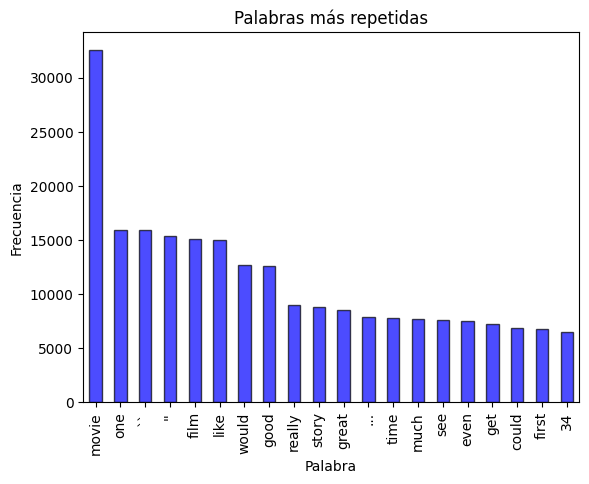

Palabras más repetidas y su frecuencia:
movie     32547
one       15942
``        15879
''        15404
film      15061
like      14998
would     12683
good      12550
really     9001
story      8784
great      8508
...        7850
time       7791
much       7669
see        7548
even       7469
get        7194
could      6834
first      6731
34         6507
Name: count, dtype: int64


In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

# Convierto la columna 'review' en una sola lista de tokens y cuento su frecuencia
all_tokens = [token for sublist in train_data['clean_tokens'] for token in sublist]
token_counts = pd.Series(all_tokens).value_counts()

# Selecciono las 20 palabras más repetidas
top_words = token_counts.head(20)

# Creo el histograma
top_words.plot(kind='bar', color='blue', alpha=0.7, edgecolor='black')
plt.xlabel('Palabra')
plt.ylabel('Frecuencia')
plt.title('Palabras más repetidas')
plt.show()

# Muestro las palabras más repetidas y su frecuencia
print("Palabras más repetidas y su frecuencia:")
print(top_words)


Como puede apreciarse en el gráfico, hay dos tokens (``,'') que no tiene sentido mantenerlos ya que no son palabras como sí, sino que son símbolos que trás haber hecho la separación en tokens, estos símbolos se han considerado como tokens. Estos tokens creo que no van a aportar ningún valor al modelo, por lo que voy a revisar una lista con los tokens más repetidos para comprobar si existe algún otro token extraño que pueda ser eliminado.

In [ ]:
# Ajustar la configuración de visualización para mostrar más filas y columnas
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)

# Imprimir la serie completa token_counts
print(token_counts.head(500))


movie            32547
one              15942
``               15879
''               15404
film             15061
like             14998
would            12683
good             12550
really            9001
story             8784
great             8508
...               7850
time              7791
much              7669
see               7548
even              7469
get               7194
could             6834
first             6731
34                6507
dvd               6457
well              6260
watch             6109
movies            6099
show              5574
love              5364
series            5173
way               5167
bad               5130
people            5077
better            5050
think             4962
also              4892
characters        4737
make              4674
character         4500
two               4426
made              4413
many              4362
little            4328
know              4256
season            4067
acting            4027
never      

Observando la lista de 500 tokens más repetidos es posible apreciar como existen seis tokens que no tiene sentido mantenérlos:
*   ``
*   ''
*   ...
*   --
*   ..
*   ....

Por ello, procedo a su eliminación.










In [ ]:
import pandas as pd
import re


# Defino los símbolos a eliminar
symbols_to_remove = ["``", "''", "...", "--", "..", "..."]

def remove_symbols(tokens):
    clean_tokens = [re.sub('|'.join(map(re.escape, symbols_to_remove)), '', token) for token in tokens]
    clean_tokens = [token.strip() for token in clean_tokens if token.strip()]  # Eliminar espacios en blanco adicionales
    return clean_tokens

# Aplico la función a la columna clean_tokens
train_data['clean_tokens'] = train_data['clean_tokens'].apply(lambda tokens: remove_symbols(tokens))


Compruebo que los símbolos se han eliminado correctamente.

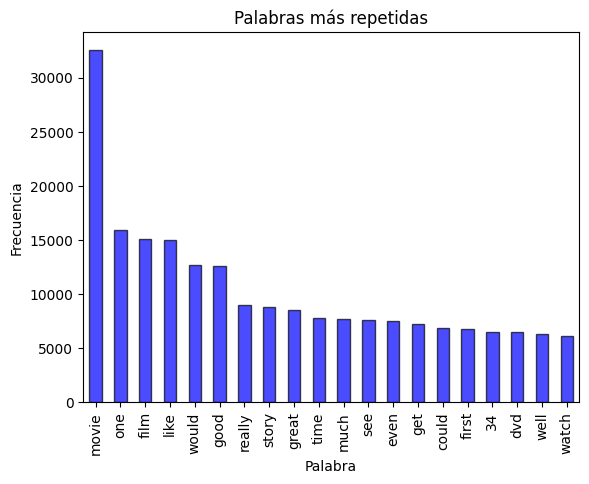

Palabras más repetidas y su frecuencia:
movie     32547
one       15942
film      15061
like      14998
would     12683
good      12550
really     9001
story      8784
great      8508
time       7791
much       7669
see        7548
even       7469
get        7194
could      6834
first      6731
34         6507
dvd        6457
well       6260
watch      6109
Name: count, dtype: int64


In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

# Convierto la columna 'review' en una sola lista de tokens y cuento su frecuencia
all_tokens = [token for sublist in train_data['clean_tokens'] for token in sublist]
token_counts = pd.Series(all_tokens).value_counts()

# Selecciono las 20 palabras más repetidas
top_words = token_counts.head(20)

# Creo el histograma
top_words.plot(kind='bar', color='blue', alpha=0.7, edgecolor='black')
plt.xlabel('Palabra')
plt.ylabel('Frecuencia')
plt.title('Palabras más repetidas')
plt.show()

# Muestro las palabras más repetidas y su frecuencia
print("Palabras más repetidas y su frecuencia:")
print(top_words)

Con el fin de asegurarme, cambio la configuración del notebook para poder visualziar las 500 palabras más repetidas.

In [ ]:
# Ajusto la configuración de visualización para mostrar más filas y columnas
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)

# Imprimo la serie completa token_counts
print(token_counts.head(500))


movie            32547
one              15942
film             15061
like             14998
would            12683
good             12550
really            9001
story             8784
great             8508
time              7791
much              7669
see               7548
even              7469
get               7194
could             6834
first             6731
34                6507
dvd               6457
well              6260
watch             6109
movies            6099
show              5574
love              5364
series            5173
way               5167
bad               5130
people            5077
better            5050
think             4962
also              4892
characters        4737
make              4674
character         4500
two               4426
made              4413
many              4362
little            4328
know              4256
season            4067
acting            4027
never             3928
best              3926
still             3887
watching   

Seguidamente, procedo a aplicar la lematización a los tokens limpios. Me decanto por esta técnica en vez de por la de stemming porque deseo que las palabras resultantes sean palabras reales y que se tenga en cuante el análisis morfológico. Por medio del stemming a veces se consiguen palabras que no existen como lik en vez de like por lo que creo que es más correcto utilizar la lematización.

In [ ]:
import nltk
from nltk.stem import WordNetLemmatizer
from nltk.corpus import wordnet

# Descargolos recursos necesarios de NLTK
nltk.download('wordnet')
nltk.download('averaged_perceptron_tagger')

# Inicializo el lematizador
lemmatizer = WordNetLemmatizer()

# Función para lemmatizar los tokens
def lemmatize_tokens(tokens):
    lemmatized_tokens = []
    for word in tokens:
        # Obtengo la categoría gramatical de la palabra
        pos_tag = nltk.pos_tag([word])[0][1][0].upper()
        # Mapeo la categoría gramatical de NLTK a la de WordNet
        wordnet_pos = {
            'N': wordnet.NOUN,
            'V': wordnet.VERB,
            'J': wordnet.ADJ,
            'R': wordnet.ADV
        }.get(pos_tag, wordnet.NOUN)
        lemmatized_word = lemmatizer.lemmatize(word, pos=wordnet_pos).lower().strip()
        lemmatized_tokens.append(lemmatized_word)
    return lemmatized_tokens

# Aplico la función a la columna 'clean_tokens' y almaceno el resultado en una nueva columna 'lemmatized_tokens'
train_data['lemmatized_tokens'] = train_data['clean_tokens'].apply(lemmatize_tokens)

# Compruebo el resultado
print(train_data.head())

[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Unzipping taggers/averaged_perceptron_tagger.zip.


                                             review_text  rating_note  \
26163  The movie Coraline, based on the novella by Br...          5.0   
41021  I loved this series. Sad to see it canceled. I...          5.0   
91131  I loved this whole series-Dodger is my favorit...          5.0   
44450  The story of this film is similar to &quot;A C...          5.0   
56326  It is a breath of fresh air to see a film with...          5.0   

                                           review_tokens  \
26163  [The, movie, Coraline, ,, based, on, the, nove...   
41021  [I, loved, this, series, ., Sad, to, see, it, ...   
91131  [I, loved, this, whole, series-Dodger, is, my,...   
44450  [The, story, of, this, film, is, similar, to, ...   
56326  [It, is, a, breath, of, fresh, air, to, see, a...   

                                            clean_tokens  \
26163  [movie, coraline, based, novella, british, aut...   
41021  [loved, series, sad, see, canceled, would, rec...   
91131  [loved, whole

Selecciono un review aleatorio y compruebo que se ha aplicado correctamente.

In [ ]:
import random

# Genero un índice aleatorio
random_index = random.randint(0, len(train_data) - 1)

# Obtengo los tokens originales y los tokens lematizados para el índice aleatorio
clean_tokens = train_data.loc[random_index, 'clean_tokens']
lemmatized_tokens = train_data.loc[random_index, 'lemmatized_tokens']

# Compruebo ambas columnas
print("Tokens originales:", clean_tokens)
print("Tokens lematizados:", lemmatized_tokens)



Tokens originales: ['right', 'writing', 'review', 'watching', "'the", 'snow', 'queen', 'really', 'really', 'disappointed.it', 'really', 'really', 'really', 'lame.the', 'movie', 'starts', 'well', 'good', 'music', 'good', 'atmosphere', 'passable', 'acting', 'like', 'see', 'adult', 'gerta', 'whole', 'movie', 'goes', 'downhill.the', 'script', 'horrible', 'makes', 'one', 'feel', 'though', 'writers', 'deliberately', 'chose', 'awkward', 'phrases', 'movie', 'make', 'one', 'flinch', 'acting', 'wooden', 'two', 'main', 'characters', 'likable', 'least', 'although', 'liked', 'snow', 'queen', 'first', 'time', 'gerta', 'saw', 'dark-maiden', 'glory', 'lessened', 'next', 'time', 'came', 'along', 'felt', 'made', 'major', 'mistake', 'making', 'snow', 'queen', 'american', 'accent', 'speak', 'casually', 'makes', 'seem', 'much', 'less', 'regal', 'imposing', 'cringed', 'said', "c'mere", 'bother', 'watching', 'movie', 'long', 'dumb', 'boring']
Tokens lematizados: ['right', 'write', 'review', 'watch', "'the", 

Se puede comprobar como la lematización se ha aplicado correctamente. Por ejemplo palabras en plural como writers se ha transformado en singular y verbo en gerundio como writing se ha transformado en write.

Por otro lado, en todo este proceso de normalización del texto, no he hecho ningún cambio sobre los tokens de tipo numérico. El problema que se está intentando implementar es el de clasificar unas reseñas en función de los comentarios de los usuarios y en mi opinión, creo que los números en el texto pueden tener relevancia semántica y su contexto puede ser importante. Es por eso que he decidido no realizar ningún cambio sobre los números y los he mantenido en formato numérico.



Tras haber finalizado la lemitazación, doy por concluida la normalización de los datos. Como resultado, se obtiene el siguiente dataframe.

In [ ]:
print(train_data.shape)
train_data.head(10)

(29625, 5)


,review_text,rating_note,review_tokens,clean_tokens,lemmatized_tokens
26163,"The movie Coraline, based on the novella by Br...",5.0,"[The, movie, Coraline, ,, based, on, the, nove...","[movie, coraline, based, novella, british, aut...","[movie, coraline, base, novella, british, auth..."
41021,I loved this series. Sad to see it canceled. I...,5.0,"[I, loved, this, series, ., Sad, to, see, it, ...","[loved, series, sad, see, canceled, would, rec...","[love, series, sad, see, cancel, would, recomm..."
91131,I loved this whole series-Dodger is my favorit...,5.0,"[I, loved, this, whole, series-Dodger, is, my,...","[loved, whole, series-dodger, favorite, charac...","[love, whole, series-dodger, favorite, charact..."
44450,The story of this film is similar to &quot;A C...,5.0,"[The, story, of, this, film, is, similar, to, ...","[story, film, similar, quot, civil, action, qu...","[story, film, similar, quot, civil, action, qu..."
56326,It is a breath of fresh air to see a film with...,5.0,"[It, is, a, breath, of, fresh, air, to, see, a...","[breath, fresh, air, see, film, great, actors,...","[breath, fresh, air, see, film, great, actor, ..."
76096,My daughter is on her 10th viewing. It is SB d...,5.0,"[My, daughter, is, on, her, 10th, viewing, ., ...","[daughter, 10th, viewing, sb, 't, judge, loved...","[daughter, 10th, view, sb, 't, judge, love, fa..."
84458,this movie is very funny and very true to some...,5.0,"[this, movie, is, very, funny, and, very, true...","[movie, funny, true, politician, get, elected,...","[movie, funny, true, politician, get, elect, c..."
45135,The perfect tribute for the perfect artist wit...,5.0,"[The, perfect, tribute, for, the, perfect, art...","[perfect, tribute, perfect, artist, perfect, l...","[perfect, tribute, perfect, artist, perfect, l..."
26968,I stumbled across this Nova documentary at the...,5.0,"[I, stumbled, across, this, Nova, documentary,...","[stumbled, across, nova, documentary, public, ...","[stumble, across, nova, documentary, public, l..."
71536,I lived and worked in Sedona.we are all skept...,5.0,"[I, lived, and, worked, in, Sedona.we, are, al...","[lived, worked, sedona.we, skeptical, get, mel...","[live, work, sedona.we, skeptical, get, mellow..."


Dado que ejecutar toda esta limpieza lleva su tiempo, voy a guardar el resultado obtenido en un fichero CSV para que pueda acceder a los datos siempre que quiera.

Asimismo, y para finalizar este apartado, destacar que este proceso de limpieza se ha realizado paso a paso para ir comprobando como se iba realizando. Sin embargo, lo interesante es generar un pipeline el cual permita limpiar las reseñas en una misma celda. Este pipeline se creará más adelante una vez haya explorado más en detalle los datos.

In [ ]:
import pandas as pd

# Ruta donde guardar el archivo CSV
ruta_archivo = "/content/drive/MyDrive/Práctica Despliegue Algoritmos/data_train_clean.csv"

# Guardo el DataFrame en un archivo CSV
train_data.to_csv(ruta_archivo, index=False, sep=';')




##Cardinalidad del vocabulario

Ahora que las reseñas han sido normalizadas, voy a calcular la cardinalidad de todo el vocabulario y de cada una de las reviews. Me parece interesante saber ambas métricas porque creo que es interesante conocer la distribución de los tokens con lo que se trabaja.

Lo primero que voy a hacer es importar de nuevo el archivo. Esto lo hago para tener un punto de control durante la práctica.

In [ ]:
import pandas as pd
train_data = pd.read_csv("/content/drive/MyDrive/Práctica Despliegue Algoritmos/data_train_clean.csv",sep=';')
print(train_data.head())
print("Dimensión conjunto de entrenamiento",train_data.shape)

                                         review_text  rating_note  \
0  The movie Coraline, based on the novella by Br...          5.0   
1  I loved this series. Sad to see it canceled. I...          5.0   
2  I loved this whole series-Dodger is my favorit...          5.0   
3  The story of this film is similar to &quot;A C...          5.0   
4  It is a breath of fresh air to see a film with...          5.0   

                                       review_tokens  \
0  ['The', 'movie', 'Coraline', ',', 'based', 'on...   
1  ['I', 'loved', 'this', 'series', '.', 'Sad', '...   
2  ['I', 'loved', 'this', 'whole', 'series-Dodger...   
3  ['The', 'story', 'of', 'this', 'film', 'is', '...   
4  ['It', 'is', 'a', 'breath', 'of', 'fresh', 'ai...   

                                        clean_tokens  \
0  ['movie', 'coraline', 'based', 'novella', 'bri...   
1  ['loved', 'series', 'sad', 'see', 'canceled', ...   
2  ['loved', 'whole', 'series-dodger', 'favorite'...   
3  ['story', 'film', 'si

In [ ]:
train_data.head()

,review_text,rating_note,review_tokens,clean_tokens,lemmatized_tokens
0,"The movie Coraline, based on the novella by Br...",5.0,"['The', 'movie', 'Coraline', ',', 'based', 'on...","['movie', 'coraline', 'based', 'novella', 'bri...","['movie', 'coraline', 'base', 'novella', 'brit..."
1,I loved this series. Sad to see it canceled. I...,5.0,"['I', 'loved', 'this', 'series', '.', 'Sad', '...","['loved', 'series', 'sad', 'see', 'canceled', ...","['love', 'series', 'sad', 'see', 'cancel', 'wo..."
2,I loved this whole series-Dodger is my favorit...,5.0,"['I', 'loved', 'this', 'whole', 'series-Dodger...","['loved', 'whole', 'series-dodger', 'favorite'...","['love', 'whole', 'series-dodger', 'favorite',..."
3,The story of this film is similar to &quot;A C...,5.0,"['The', 'story', 'of', 'this', 'film', 'is', '...","['story', 'film', 'similar', 'quot', 'civil', ...","['story', 'film', 'similar', 'quot', 'civil', ..."
4,It is a breath of fresh air to see a film with...,5.0,"['It', 'is', 'a', 'breath', 'of', 'fresh', 'ai...","['breath', 'fresh', 'air', 'see', 'film', 'gre...","['breath', 'fresh', 'air', 'see', 'film', 'gre..."


Como he ido almacenando los valores en distintas columnas, los tokens se han almacenado como cadenas en lugar de como listas reales. Como deseo calcular la cardinalidad de las reseñas, convierto las cadenas en listas.

In [ ]:
# Convierto la cadena de la lista en una lista real
train_data['clean_tokens'] = train_data['clean_tokens'].apply(eval)

# Convierto la cadena de la lista lematizada en una lista real
train_data['lemmatized_tokens'] = train_data['lemmatized_tokens'].apply(eval)


Calculo la cardinalidad de todo el vocabulario y la cardinalifad de cada reseña.

In [ ]:
import pandas as pd

# Crear un conjunto vacío para almacenar los tokens únicos
tokens_distintos = set()

# Iterar sobre cada lista de tokens en la columna 'lemmatized_tokens' y agregar los tokens únicos al conjunto
train_data['lemmatized_tokens'].apply(lambda tokens: tokens_distintos.update(set(tokens)))

# Imprimir la cantidad de tokens distintos
print("La cantidad de tokens distintos es:", len(tokens_distintos))

# Creo una nueva columna para conocer el numero de tokens de cada review.
train_data['review_cardinality'] = train_data['lemmatized_tokens'].apply(len)

# Compruebo cuantos tokens hay en total
suma_total = train_data['review_cardinality'].sum()

print("El total de tokens en todo el dataset es:", suma_total)
print(train_data['review_cardinality'].describe())


La cantidad de tokens distintos es: 96503
El total de tokens en todo el dataset es: 1929074
count    29625.000000
mean        65.116422
std         93.725884
min          1.000000
25%         16.000000
50%         33.000000
75%         76.000000
max       3351.000000
Name: review_cardinality, dtype: float64


La cardinalidad de todo el vocabulario es de 96503 tokens. Es importante no confundirse con el parámetro count de 29625 ya que ese valor lo que indica es el total de valores no nulos en la columna review_cardinality. Al haber quitado los valores NaN durante el preprocesamiento, este número coincide con el número de filas del dataframe.

Por otro lado, en total el dataframe contiene 1929074 tokens, de los cuales 1832571 están repetidos. Este dato se sabe porque la resta entre el número total de tokens menos el la cardinalidad del vocabulario, da como resultado ese valor. Es muy curioso ver como prácticamente todos los usuarios utilizan las mismas palabras para expresar su opinión. El 95% de los tokens extraidos de las reseñas se repiten por lo que esto demuestra que los seres humanos a la hora de expresar una opinión, solemos utilizar el mismo tipo de lenguaje.

Asimismo, observando los valores obtenidos por la función describe se puede apreciar como de media cada review una vez normalizada es de 65 tokens. Además, el 75% de los tokens se encuentran por debajo de los 76 tokens, lo cual sirve para hacerse una idea de como se distribuyen los tokens. Sin embargo, es interesante ver como el máximo de tokens para una reseña es de 3551, es decir, un 98% más de la media. Voy a pintar un histograma para observar la distribución de los datos y poder determinar si alguna reseña puede ser considerada como outlier. Para ello, voy a utilizar la columna review_cardinality, en vez de la columna unique_tokens porque quiero que el modelo aprenda a generalizar con reseñas que tengan palabras repetidas ya que es algo que es muy caracterísitico cuando se escribe reseñas.

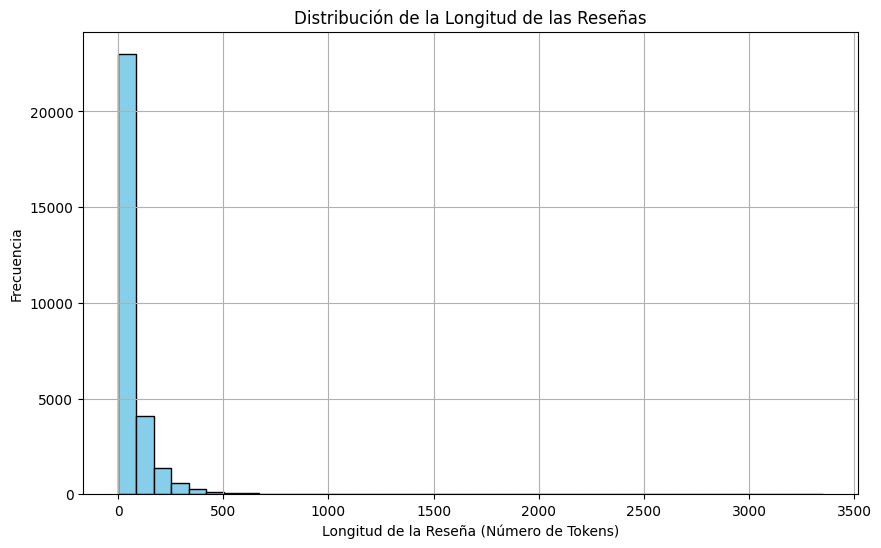

In [ ]:
import matplotlib.pyplot as plt

# Histograma de la columna 'review_cardinality'
plt.figure(figsize=(10, 6))
plt.hist(train_data['review_cardinality'], bins=40, color='skyblue', edgecolor='black')
plt.title('Distribución de la Longitud de las Reseñas')
plt.xlabel('Longitud de la Reseña (Número de Tokens)')
plt.ylabel('Frecuencia')
plt.grid(True)
plt.show()



Como puede apreciarse, la distribución de los token está muy descompensada. Casi todos se agrupan al principio, menos por algunos que se agrupan por encima de una longitud de tokens superior a 500. Voy a comprobar cuantas reseñas poseen más de 500 tokens una vez que se ha aplicado la normalización. Para ello, voy a pintar un gráfico para pintar unicamente las reviews con más de 100 tokens y así poder apreciar con más detalle la distribución.

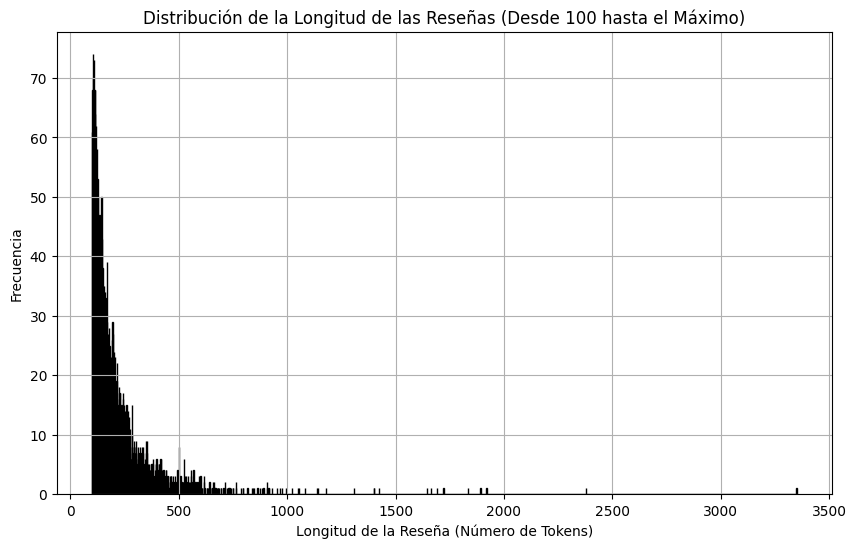

In [ ]:
# Defino el rango para el histograma
max_review_length = train_data['review_cardinality'].max()
rango = range(100, max_review_length + 1)

# Histograma
plt.figure(figsize=(10, 6))
plt.hist(train_data['review_cardinality'], bins=rango, color='skyblue', edgecolor='black')
plt.title('Distribución de la Longitud de las Reseñas (Desde 100 hasta el Máximo)')
plt.xlabel('Longitud de la Reseña (Número de Tokens)')
plt.ylabel('Frecuencia')
plt.grid(True)
plt.show()



El gráfico obtenido es útil porque permite detectar outliers de una forma sencilla. Se puede apreciar como la longitud de tokens va disminuyendo de forma abrupta y como superado el umbral aproximadamente de 600 tokens, apenas hay reseñas. Esto quiere decir que la mayoría de las reseñas poseen menos de 600 tokens y que a partir de 600 tokens algunas reseñas se podrían considerar como outliers. Voy a comprobar cuantas reseñas poseen más de 600 tokens y que consecuencias en tanto por ciento supondría su eliminación.

In [ ]:
# Filtro el DataFrame para obtener las reseñas con más de 500 tokens
reseñas_mas_de_600 = train_data[train_data['review_cardinality'] > 600]
num_reseñas_mas_de_600 = len(reseñas_mas_de_600)
print("Número de reseñas con más de 600 tokens tras aplicar la normalización:", num_reseñas_mas_de_600)


Número de reseñas con más de 600 tokens tras aplicar la normalización: 91


Únicamente 91 reseñas poseen más de 600 tokens. Estas reseñas suponen un 0,3 por ciento del total del dataset, por lo que eliminarlas no supondría una gran pérdida de información y como beneficio, se tendría un dataset con menos ruido. Es por eso que procedo a eliminar aquellas reseñas que tiene más de 600 tokens y dibujo un histograma para como queda esta distribución una vez eliminada.

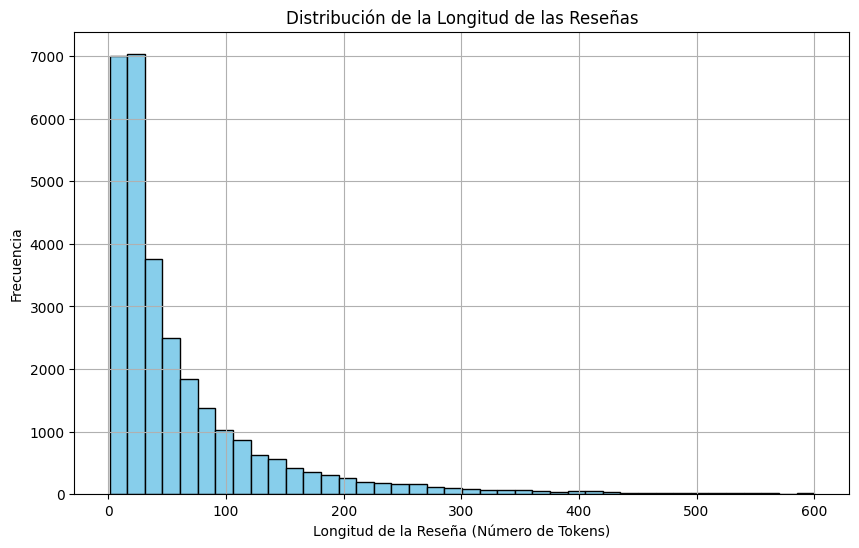

In [ ]:
# Filtro el DataFrame
train_data = train_data[train_data['review_cardinality'] <= 600]

# Histograma de la columna 'review_cardinality'
plt.figure(figsize=(10, 6))
plt.hist(train_data['review_cardinality'], bins=40, color='skyblue', edgecolor='black')
plt.title('Distribución de la Longitud de las Reseñas')
plt.xlabel('Longitud de la Reseña (Número de Tokens)')
plt.ylabel('Frecuencia')
plt.grid(True)
plt.show()



Observando la distribución de datos eliminando aquellas reseñas que poseen más de 600 reseñas, se obtiene un mayor detalle de como se distribuyen los datos. En la última gráfica se puede apreciar como se podría acotar aún más el umbral para considerar una reseña como outlier. Parece que a partir de 400 tokens, apenas hay reviews. Es cierto que si que existen reviews, pero si se observa el gráfico en conjunto, se puede apreciar como elimnar aquellas reviews que tengan más de 400 reviews, no va a suponer una grán pérdida de información. Por ello, voy a calcular cuanto supondría esta pérdida.

In [ ]:
# Filtro el DataFrame para obtener las reseñas con más de 500 tokens
reseñas_mas_de_400 = train_data[train_data['review_cardinality'] > 400]
num_reseñas_mas_de_400 = len(reseñas_mas_de_400)
print("Número de reseñas con más de 400 tokens tras aplicar la normalización:", num_reseñas_mas_de_400)

porcentaje_eliminación = (num_reseñas_mas_de_400*100)/train_data.shape[0]
print("La eliminación de las reseñas con más de 400 tokens supondría la eliminación del:", porcentaje_eliminación,"%" )

Número de reseñas con más de 400 tokens tras aplicar la normalización: 287
La eliminación de las reseñas con más de 400 tokens supondría la eliminación del: 0.9717613597887181 %


Dado que la eliminación supone apenas un 0,97, fijo el umbral en 400. Esto significa que todas las reviews que posean más de 400 tokens, serán eliminadas.

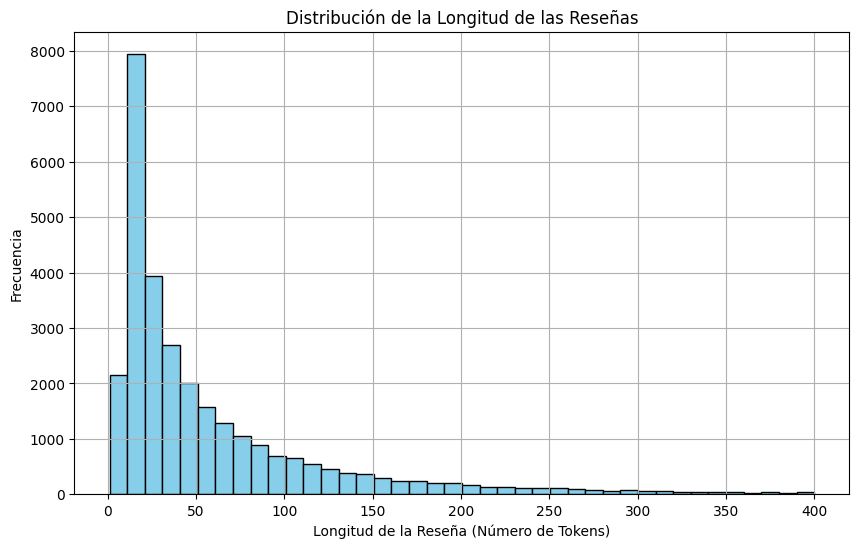

In [ ]:
# Elimino las filas donde review_cardinality sea superior a 400
train_data = train_data[train_data['review_cardinality'] <= 400]

# Histograma de la columna 'review_cardinality'
plt.figure(figsize=(10, 6))
plt.hist(train_data['review_cardinality'], bins=40, color='skyblue', edgecolor='black')
plt.title('Distribución de la Longitud de las Reseñas')
plt.xlabel('Longitud de la Reseña (Número de Tokens)')
plt.ylabel('Frecuencia')
plt.grid(True)
plt.show()


In [ ]:
train_data['review_cardinality'].describe()

count    29247.000000
mean        58.435429
std         65.634505
min          1.000000
25%         16.000000
50%         32.000000
75%         74.000000
max        400.000000
Name: review_cardinality, dtype: float64

Haciendo esta eliminación de outliers,la cardinalidad cambia. Ahora la media de tokens disminuye a 58 por reseña y el tercer cuartil se situa en 74 cuando antes estaba en 76. Obviamente esto es normal ya que he eliminado las reseñas con gran cantidad de tokens. Es un cambio pequeño pero que aportar beneficio al modelo ya que permite la eliminación de ruido de los datos. Este cambio hay que tener en cuenta a la hora de generar el modelo y reportar las métricas.

Por último, genero el comando para comprobar cual es la nueva dimensión del dataset, teniendo en cuenta que se han eliminado 378 reseñas.

In [ ]:
train_data.shape

(29247, 6)

## Distribución de las reseñas por nota

Aunque durante el proceso de normalización de los datos se han distribuido todos uniformamamente en función de la categoría con menor número de datos, durante el proceso de la cardinalidad se han eliminado 378 reseñas porque han sido consideradas como outliers. Por ello, aunque el cambio haya sido mínimo, voy a pintar un histrograma para ver que categorías se han visto más afectadas tras esta eliminación.

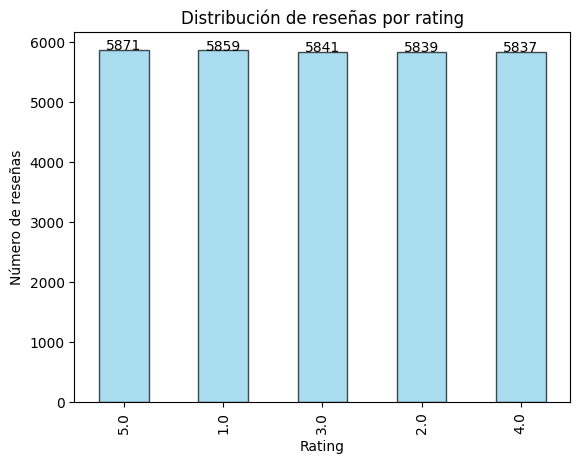

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

# Contar el número de reseñas por categoría de rating
rating_counts = train_data['rating_note'].value_counts()

# Crear el histograma
ax = rating_counts.plot(kind='bar', color='skyblue', alpha=0.7, edgecolor='black')

# Añadir etiquetas y título
plt.xlabel('Rating')
plt.ylabel('Número de reseñas')
plt.title('Distribución de reseñas por rating')

# Añadir los valores en las barras
for i, count in enumerate(rating_counts):
    ax.text(i, count + 0.1, str(count), ha='center')

# Mostrar el histograma
plt.show()


La siguiente tabla recoge los principales cambios debidos a la eliminación de outliers.


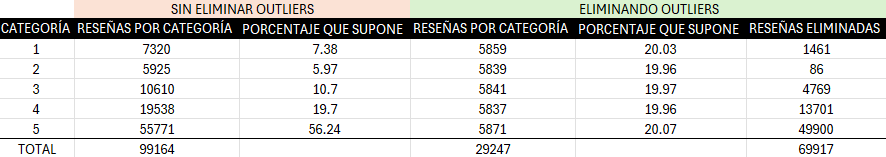


Las principales conclusiones que se pueden estraer son:

*   Todas las categorías se han visto afectadas por la eliminación de outliers y la distribucón equitativa por categorías. Se puede apreciar que aunque se hayan eliminado algunas reseñas, prácticamente el dataset está perfectamente balanceado (20% por categoría).

*   Al contrario de lo que podría parecer, las reseñas de categoría 2, 3, 4 eran las más largas y por lo tanto las que más se han eliminado. Esto tiene sentido dado que es normal que cuando un ser humano marca un producto como una de esas categorías, utilice más palabras para justificar su nota.

*   Por último, destacar que tras la eliminación de outliers y la distribución de datos, el dataset ha disminuido en un 70%.






##N-grams más frecuentes

Durante el preprocesamiento de los datos, otro detalle que suele ser interesante de consultar es el conocer las palabras más frecuente o n-gramas más frecuentes que componen el corpus ya que eso puede dar una idea acerca de los datos que se está trabajando. En este caso ya se sabe que los datos corresponden a reseñas de películas y televisión escritas por los usuarios en Amazon pero aún así es una buena práctica realizar este análisis.

Además, es cierto aunque durante la normalización se ha estudiado cuales eran las palabras más comunes pero esto se ha hecho unicamente para ver si había algún signo de puntuación que no se había eliminado y debía ser eliminado. Sin embargo no se ha profundizado en el estudio del mismo. Es por eso a continuación se presenta un análisis sobre los n-grams más frecuentes.

Para realizar este análisis lo primero que se ha hecho es definir una función. Dado que el análisis se va a centrar en realizar unigramas, bigramas y trigramas, creo que el modo más eficiente de abordarlos es mediante una función a la cual se le especifique en la entrada el tipo de n-grama que se desea y como resultado genere la lista y el histograma con las palabras más frecuentes.

In [ ]:
import nltk
import matplotlib.pyplot as plt
from nltk import ngrams

# Obtener todas las palabras de todas las reseñas en una lista
all_words = [word for sublist in train_data['lemmatized_tokens'] for word in sublist]

# Crear un objeto Text a partir de la lista de palabras
text = nltk.Text(all_words)

# Función para obtener los n-gramas más frecuentes y mostrar un histograma
def plot_top_ngrams(tokens, n, top=10):
    n_grams = ngrams(tokens, n)
    frequency_dist = nltk.FreqDist(n_grams)
    top_ngrams = frequency_dist.most_common(top)

    # Obtener las frecuencias y los n-gramas
    frequencies = [freq for ngram, freq in top_ngrams]
    ngram_labels = [' '.join(ngram) for ngram, freq in top_ngrams]

    # Crear el histograma
    plt.figure(figsize=(10, 6))
    plt.bar(range(len(top_ngrams)), frequencies, tick_label=ngram_labels)
    plt.xlabel(f'{n}-gramas más frecuentes')
    plt.ylabel('Frecuencia')
    plt.title(f'Histograma de los {top} {n}-gramas más frecuentes')
    plt.xticks(rotation=45, ha='right')
    plt.tight_layout()
    plt.show()




### Unigrama con las 10 palabras más frecuentes

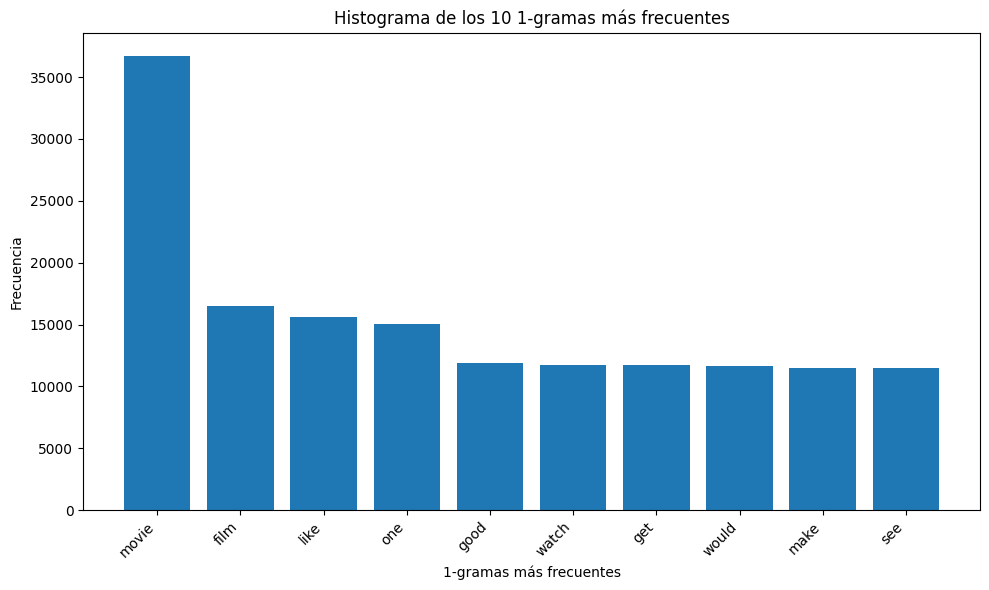

In [ ]:
# Mostrar histograma de los 10 unigramas más frecuentes
plot_top_ngrams(all_words, 1)

Las principales conclusiones que se pueden extraer de este histograma son:

*  **Palabras referentes a películas**: El token más utilizado es movie y el segundo film, las cuales son palabras sinónimas en ingés que expresan película. Obviamente esto tiene sentido ya que los datos con lo que se está trabjando corresponden a reseñas de películas por lo que es normal que los usuarios utilicen estas palabras en sus reseñas.

*   **Verbos referentes a visualizar**: Verbos como watch, see hacen referencia a la acción de ver la película por lo que es normal que estos tokens sean tan comúnes en el dataframe.

*  **Palabras para expresar opinión**: Palabras como like, good. Todas estas palabras tienen en común que hacen referencia a la opinión de una persona sobre algo. En este caso se sabe que son películas por lo que es normal que los usuarios utilicen estas palabras para expresar su opinión.


En definitiva, los tokens que más se repiten en las reseñas tienen sentido con lo que se esperaba ya que todos ellos indican que se está tratando con reseñas referentes a películas.


### Bigrama con las 10 palabras más frecuentes

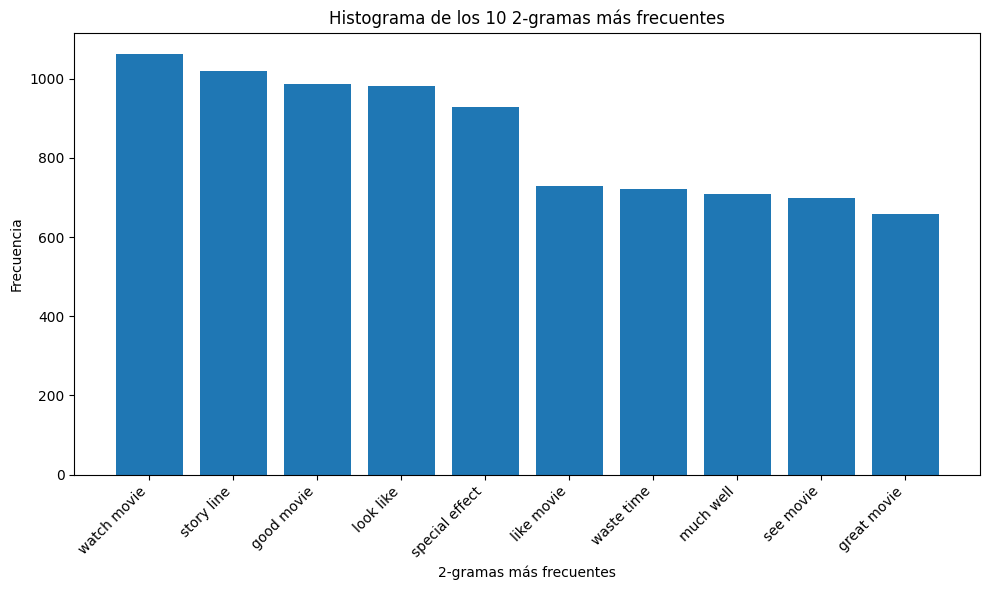

In [ ]:
# Mostrar histograma de los 10 bigramas más frecuentes
plot_top_ngrams(all_words, 2)


El bigrama obtenido es interesante porque permite extraer en este caso conclusiones distintas al apartado anterior:

*   **Contexto de las palabras**: Al realizar el gráfico de bigramas es posible empezar a ver significados que antes no se podría obtener. Por ejemplo, el bigrama good movie, waste time indican lo que se suponía en el apartado anterior y es que se está tratando con reseñas de películas. Ademñas, es interesante ver como a priori no se sabe si las reseñas son positivas o negativas dado que el dataset está balanceado. Esta confirmación se obtiene gracias al contexto de las palabras ya que por ejemplo la palabra movie por separado puede ser positivo o negativo, pero en cambio el bigrama good movie no deja lugar a dudas.

*   **Bigrama referente a reseñas de películas**: Asimismo, el bigrama que más se repite es el de watch movie, lo cual era esperado puesto que se tratan de reseñas de películas por lo que es normal que se repita ese bigrama.

*   **Bigramas que expresan opinión**: Por ejemplo, el bigrama look like o el bigrama much well están compuestas por palabras que por separado no ofrecen mucha información pero en cambio cuando se combinan con la otra palabra, su contexto cambia el significado. Ambos bigramas están indicando que se está expresando una opinión, lo cual es lo esperado en una reseña.

*  **Bigrama referente a películas**: Me parece curioso y creo que merece la pena destacarlos, los bigramas special effect y story line ya que estos bigramas en sí son conceptos. Efectos especiales es el concepto que está compuesto por dos palabras y esto demuestra lo importante que es el contexto en el lengüaje ya que la unión de una palabra con otra, cambia por completo el sentido de la frase. Es por eso que en NPL es importante captutar este sentido.





### Trigrama con las 10 palabras más frecuentes

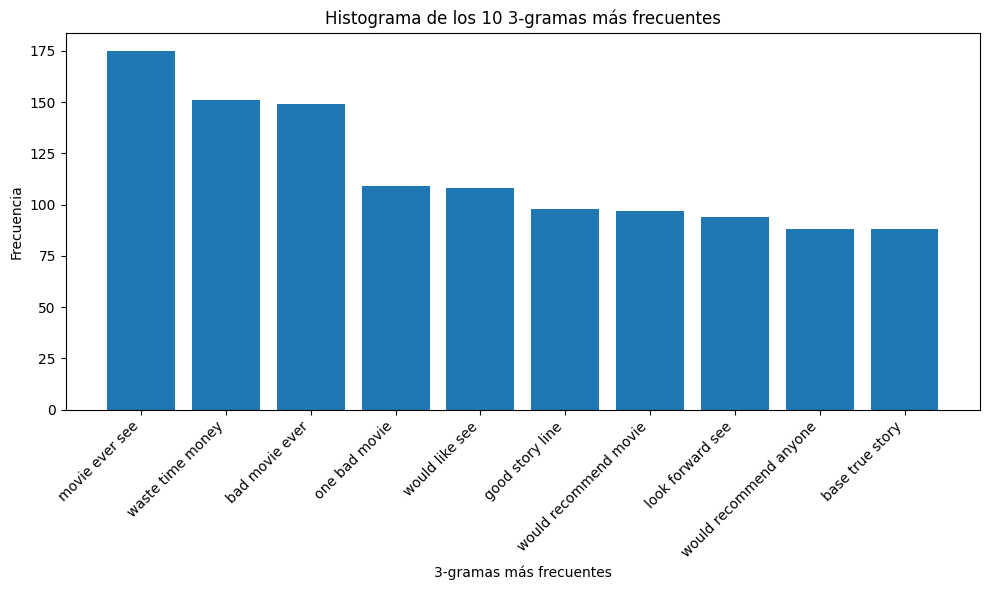

In [ ]:
# Mostrar histograma de los 10 trigramas más frecuentes
plot_top_ngrams(all_words, 3)

Por último, se presenta seguidamente las conclusiones principales de los trigramas:

*   **Refuerzo para expresar opinión**: El ser humano por lo general cuando desea expresar una opinión extrema, tanto positiva como negativa, generalmente tiende a enfatizar su opinión por medio de palabras recurrentes. Esto se puede apreciar en los tres primeros trigramas, en donde se puede visualizar como el usuario está enfatizando lo buena o mala que fue la película. Seguramente, estos trigramas correspondan a reseñas con nota 5 o 1 porque por medio de estos trigramas el usuario está expresando su absoluta conformidad o disconformidad. Este ejemplo aunque es muy obvio y muy simple, sirve para mostrar lo importante que es el contexto en el lenguaje y cuan importante es que el modelo que se entrene capte esta contextualidad.

*   **Trigrama para expresar opinión**: Los trigrams would recommend movie  o would recommend anyone sirven para que se pueda confirmar que se está trabajando con reseñas ya que en ambos casos el usuario está animando al lector a ver la película. Aunque es cierto que en ambos casos, con las dos primeras palabras ya se hubiera identificado que se estaban trabajando con reseñas, está bien poseer más contexto para poder confirmarlo.

*   **Distribución de los datos**: Observando los trigramas se puede ver como reflejan más o menos la distribución equitativa de los datos ya que de diez trigramas, cautro son negativos y cuatro positivos. Esto se debe al balanceo realizado durante el preprocesamiento.



A modo de conclusión para este apartado, en mi opinión creo que a la hora de trabjar con problemas de NLP, el poder conocer los unigramas, bigramas o trigramas puede ser interesante para hacerse una idea de los datos con los que se está trabajando. En este caso ya se sabía con los datos que se estaba trabajando, pero aún así, nos n-gramas pueden servir para confirmar ideas que se puede tener sobre los datos como puede ser su distribución. Es por eso que es interesante realizarlos siempre.

##Nube de palabras

Otra característica que puede ser interesante de conocer cuando se realiza el preprocesamiento es conocer la nube de palabras. En sí, la nube de palabras ofrece la misma información del gráfico unigrama anterior pero con la diferencia de que es más intuitivo. Esto puede ser útil para análisis de negocio o marketing ya que de un simple vistazo, se puede extraer información relevante. Las nubes de palabras funcionan del siguiente modo: las palabras que aparecen en grande son aquellas que aparecen más repetida en el corpus. Es por eso que en este caso las palabras más grandes van a ser aquellas que aparezcan en el diagrama unigrama.

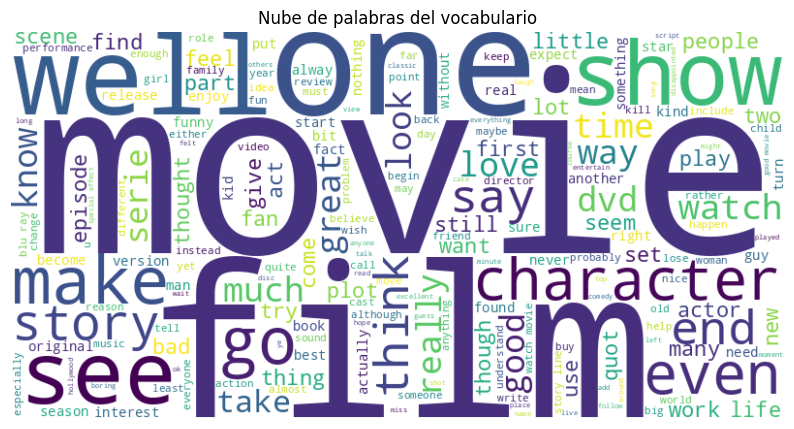

In [ ]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt

# Obtener todas las palabras de todas las reseñas en una lista
all_words = [word for sublist in train_data['lemmatized_tokens'] for word in sublist]

# Unir todas las palabras en un solo texto
text = ' '.join(all_words)

# Crear una WordCloud
wordcloud = WordCloud(width=800, height=400, background_color='white').generate(text)

# Visualizar la WordCloud
plt.figure(figsize=(10, 6))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title('Nube de palabras del vocabulario')
plt.show()


Como se puede apreciar, las palabras coinciden con lo esperado y con un simple vistazo es posible extraer la conclusión de que los datos con los que se está trabajando está referido a películas y reseñas.

Previo a proceder a entrenar un modelo, compruebo el tamaño del dataset hasta este momento y guardo los datos en un fichero como punto de control.

In [ ]:
train_data.head()

,review_text,rating_note,review_tokens,clean_tokens,lemmatized_tokens,review_cardinality
0,"The movie Coraline, based on the novella by Br...",5.0,"['The', 'movie', 'Coraline', ',', 'based', 'on...","[movie, coraline, based, novella, british, aut...","[movie, coraline, base, novella, british, auth...",39
1,I loved this series. Sad to see it canceled. I...,5.0,"['I', 'loved', 'this', 'series', '.', 'Sad', '...","[loved, series, sad, see, canceled, would, rec...","[love, series, sad, see, cancel, would, recomm...",12
2,I loved this whole series-Dodger is my favorit...,5.0,"['I', 'loved', 'this', 'whole', 'series-Dodger...","[loved, whole, series-dodger, favorite, charac...","[love, whole, series-dodger, favorite, charact...",11
3,The story of this film is similar to &quot;A C...,5.0,"['The', 'story', 'of', 'this', 'film', 'is', '...","[story, film, similar, quot, civil, action, qu...","[story, film, similar, quot, civil, action, qu...",73
4,It is a breath of fresh air to see a film with...,5.0,"['It', 'is', 'a', 'breath', 'of', 'fresh', 'ai...","[breath, fresh, air, see, film, great, actors,...","[breath, fresh, air, see, film, great, actor, ...",47


In [ ]:
print(train_data.shape)

(29247, 6)


In [ ]:
# Guardo los conjuntos de datos en archivos CSV
train_data.to_csv("/content/drive/MyDrive/Práctica Despliegue Algoritmos/data_train_processed.csv", index=False)

##Pipeline del proyecto

Cuando se realiza un ejercicio de IA suele ser interesante realizar el pipeline del proyecto el cual englobe en una misma celda todos los cambios introducidos durante el preprocesamiento de los datos. Gracias a esto se consigue una mayor organización y limpieza en el notebook que se traduce como un aumento de la eficiencia del código. Asimismo, dado que más adelante se generarán los fichero main.py y funciones.py, es aconsejable crear este pipeline porque va a permitir crear los ficheros de una forma más sencilla.

Según la definicón actual, en el contexto del Procesamiento del Lenguaje Natural (NLP), un pipeline se refiere a una **secuencia ordenada de pasos** o procesos que **se aplican a un texto o corpus de texto** para realizar una serie de **tareas de procesamiento, análisis o extracción de información**. Estos pasos pueden incluir desde tareas básicas como tokenización y limpieza de texto hasta tareas más complejas como análisis sintáctico, extracción de entidades nombradas, clasificación de sentimientos, entre otros.

Como puede apreciarse, en negrita, se ha señalado los conceptos más importantes de la definición.


*   Secuencia ordenada de pasos: Se refiere a un proceso ordenado en el que se ejecutan una serie de pasos.
*   Se aplican a un texto o corpus de texto: Estos pasos se deben aplicar al corpus con el que se este trabajando, en este caso, las reseñas de Amazon.
*   Tareas de procesamiento, análisis o extracción de información: Con lo que se busca con el pipeline es realizar el preprocesamiento y análisis del corpus.

Por lo tanto, por medio del pipeline lo que se pretende es conseguir realizar todo el preprocesamiento de datos descrito en el apartado 1 de la práctica de forma ordenada y paso por paso, con el fin de conseguir el mismo resultado. Para ello, lo primero que se debe pensar es cuales son los pasos que se han realiado en el apartado anterior.


En el apartado anterior, lo primero que se ha hecho ha sido explorar la distribución de los datos. Se ha podido comprobar como esta los datos no estaban distribuidos equitativamente y como consecuencia, se ha aplicado la técnica de undersampling. Es por eso que en el pipeline se debe aplicar esta distribución de los datos.

A continuación, se ha procedido a realizar la normalización del corpus. Los cambios que se han realizado sobre el corpus han sido:

*   Contracciones: Previo a tokenizar las palabras, primero se han expandido las contracciones dado que las reseñas están escritas en inglés.
*   Tokenización: Se ha divido cada reseña en tokens. El resultado se ha almacenado en la columna review_tokens.
*   Eliminación de stopwords, signos de puntuación y mayúsculas: El resultado se ha almacenado en la columna clean_tokens.
*   Comprobación de símbolos y eliminación de los símbolos ["``", "''", "...", "--", "..", "..."]: Dado que eran tokens que se repetían mucho y que no aportaban información, se han eliminado. El resultado se ha almacenado en la columna clean_tokens.
*   Lematización del vocabulario: Se han lematizado todos los tokens que eran verbos y se han almacenados en la columna lemmatized_tokens.

Una vez que se había conseguido normalizar las reseñas, se ha procedido a analizar la cardinalidad del vocabulario y de cada reseña. Se ha realizado un análisis y como consecuencia de este estudio, se han eliminado todas aquellas reseñas que poseían más de 400 tokens ya normalizados debido a que se han considerado outliers.

Seguidamente, se ha realizado un estudio sobre los datos con los que se trabaja y para ello se han analizado los unigramas, bigramas, trigramas y nube de palabras. Destacar que simplemente se ha analizado y no se han modificado los datos.

Por último, se han generado los embeddings para cada reseña y se han almacenado todos ellos en un tensor resultante de dimensión (98088, 62, 100), siendo 62 el valor del tercer cuartil de los datos y 100 el número de características para cada palabra. Con estos embeddings, más adelante, se han graficado las palabras más similares a una dada.

Por lo tanto, este pipeline tiene que realizar los mismos pasos que se han realiado en el apartado anterior pero solamente aquellos en los que se han modificado los datos. La entrada al pipeline tienen que ser los datos en bruto y la salida tiene que ser el tensor de embeddings. Todos los análisis, gráficas, n-grams, nube de palabras no se deben realizar. Por ello, a continuación procedo a su implementación.

Importo de nuevo para poder comprobar el funcionamiento del pipeline desarrollado.

###Pipeline train

In [ ]:
#Datos de entrenamiento
import pandas as pd
train_data = pd.read_csv("/content/drive/MyDrive/Práctica Despliegue Algoritmos/data_train.csv")
train_data = train_data.dropna(subset=['review_text'])
print(train_data.head())
print("Dimensión conjunto de entrenamiento",train_data.shape)

                                         review_text  rating_note
0  I loathe most American detective dramas. There...          5.0
1  The storyline was great.  Looking for the last...          3.0
2  Well, at least the first film was bearable. It...          3.0
3  Whilst not being near the best of Crosby's fil...          5.0
4  Best season so far. The cast has outdone thems...          5.0
Dimensión conjunto de entrenamiento (99164, 2)


In [ ]:
import pandas as pd
import re
import contractions
import nltk
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords, wordnet
from nltk.stem import WordNetLemmatizer
import string
from sklearn.utils import resample

# Descargar los recursos necesarios de NLTK
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('averaged_perceptron_tagger')

# Inicializar lematizador
lemmatizer = WordNetLemmatizer()

# Símbolos a eliminar
symbols_to_remove = ["``", "''", "...", "--", "..", "..."]

# Conjunto de stopwords y puntuación
stop_words = set(stopwords.words('english'))
punctuation = set(string.punctuation)

# Función para expandir contracciones y quitar posesiones
def clean_text(text):
    expanded_text = contractions.fix(text)
    text_without_possession = expanded_text.replace("'s", "")
    return text_without_possession

# Función para limpiar los tokens
def clean_tokens(tokens):
    clean_tokens = [token.lower() for token in tokens if token.lower() not in stop_words and token not in punctuation]
    return clean_tokens

# Función para eliminar símbolos
def remove_symbols(tokens):
    clean_tokens = [re.sub('|'.join(map(re.escape, symbols_to_remove)), '', token) for token in tokens]
    clean_tokens = [token.strip() for token in clean_tokens if token.strip()]
    return clean_tokens

# Función para lemmatizar los tokens
def lemmatize_tokens(tokens):
    lemmatized_tokens = []
    for word in tokens:
        pos_tag = nltk.pos_tag([word])[0][1][0].upper()
        wordnet_pos = {
            'N': wordnet.NOUN,
            'V': wordnet.VERB,
            'J': wordnet.ADJ,
            'R': wordnet.ADV
        }.get(pos_tag, wordnet.NOUN)
        lemmatized_word = lemmatizer.lemmatize(word, pos=wordnet_pos).lower().strip()
        lemmatized_tokens.append(lemmatized_word)
    return lemmatized_tokens

# Función de submuestreo (undersampling)
def undersample_data(data, label_column):
    min_count = data[label_column].value_counts().min()
    resampled_frames = []
    for label in data[label_column].unique():
        df_class = data[data[label_column] == label]
        df_class_undersampled = resample(df_class,
                                         replace=False,
                                         n_samples=min_count,
                                         random_state=42)
        resampled_frames.append(df_class_undersampled)
    balanced_data = pd.concat(resampled_frames)
    return balanced_data

# Crear pipeline
def nlp_pipeline(text):
    # Expandir contracciones y quitar posesiones
    expanded_text = clean_text(text)
    # Tokenizar el texto
    tokens = word_tokenize(expanded_text)
    # Limpiar los tokens
    cleaned_tokens = clean_tokens(tokens)
    # Eliminar símbolos
    symbols_removed = remove_symbols(cleaned_tokens)
    # Lematizar los tokens
    lemmatized_tokens = lemmatize_tokens(symbols_removed)
    return lemmatized_tokens

# Submuestreo antes de aplicar el pipeline de NLP
train_data = undersample_data(train_data, 'rating_note')

# Aplico el pipeline, elimino la columna review_text y reordeno el dataset
train_data['tokens'] = train_data['review_text'].apply(nlp_pipeline)
train_data['cardinality'] = train_data['tokens'].apply(len)
train_data.drop(columns=['review_text'], inplace=True)
train_data = train_data[['tokens', 'cardinality', 'rating_note']]

# Por último, elimino las filas donde review_cardinality sea superior a 400
train_data = train_data[train_data['cardinality'] <= 400]

# Imprimir la dimensión del dataset para comprobar que todo se ha aplicado correctamente
print("Dimensión del dataset:", train_data.shape)
print(train_data.head())

# Ruta donde guardar el archivo CSV
ruta_archivo = "/content/drive/MyDrive/Práctica Despliegue Algoritmos/data_train_processed.csv"

# Guardo el DataFrame en un archivo CSV
train_data.to_csv(ruta_archivo, index=False, sep=';')


[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!


Dimensión del dataset: (29247, 3)
                                                  tokens  cardinality  \
26163  [movie, coraline, base, novella, british, auth...           39   
41021  [love, series, sad, see, cancel, would, recomm...           12   
91131  [love, whole, series-dodger, favorite, charact...           11   
44450  [story, film, similar, quot, civil, action, qu...           73   
56326  [breath, fresh, air, see, film, great, actor, ...           47   

       rating_note  
26163          5.0  
41021          5.0  
91131          5.0  
44450          5.0  
56326          5.0  


###Pipeline test

Por otro lado, la normalización se ha realizado solamente para los datos de train. Es importante aplicar los mismos cambios a test para que así se pueda generar los modelos y que estos puedan aprender. Lo bueno de haber definido el pipeline es que es muy sencillo aplicar los cambios ya que simplemente es ejecutarlo pero en este caso a test.

In [ ]:
#Datos de test
import pandas as pd
test_data = pd.read_csv("/content/drive/MyDrive/Práctica Despliegue Algoritmos/data_test.csv")
test_data = test_data.dropna(subset=['review_text'])
print(test_data.head())
print("Dimensión conjunto de test",test_data.shape)

                                         review_text  rating_note
0  I cannot say this strongly enough: this is one...          5.0
1  I wonder if these guys were hoping I would be ...          1.0
2  this movie was boring, i mean real boring, don...          1.0
3  Was an interesting movie with good acting and ...          3.0
4  Kids liked this movie probably better than the...          4.0
Dimensión conjunto de test (24790, 2)


In [ ]:
import pandas as pd
import re
import contractions
import nltk
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords, wordnet
from nltk.stem import WordNetLemmatizer
import string
from sklearn.utils import resample

# Descargar los recursos necesarios de NLTK
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('averaged_perceptron_tagger')

# Inicializar lematizador
lemmatizer = WordNetLemmatizer()

# Símbolos a eliminar
symbols_to_remove = ["``", "''", "...", "--", "..", "..."]

# Conjunto de stopwords y puntuación
stop_words = set(stopwords.words('english'))
punctuation = set(string.punctuation)

# Función para expandir contracciones y quitar posesiones
def clean_text(text):
    expanded_text = contractions.fix(text)
    text_without_possession = expanded_text.replace("'s", "")
    return text_without_possession

# Función para limpiar los tokens
def clean_tokens(tokens):
    clean_tokens = [token.lower() for token in tokens if token.lower() not in stop_words and token not in punctuation]
    return clean_tokens

# Función para eliminar símbolos
def remove_symbols(tokens):
    clean_tokens = [re.sub('|'.join(map(re.escape, symbols_to_remove)), '', token) for token in tokens]
    clean_tokens = [token.strip() for token in clean_tokens if token.strip()]
    return clean_tokens

# Función para lemmatizar los tokens
def lemmatize_tokens(tokens):
    lemmatized_tokens = []
    for word in tokens:
        pos_tag = nltk.pos_tag([word])[0][1][0].upper()
        wordnet_pos = {
            'N': wordnet.NOUN,
            'V': wordnet.VERB,
            'J': wordnet.ADJ,
            'R': wordnet.ADV
        }.get(pos_tag, wordnet.NOUN)
        lemmatized_word = lemmatizer.lemmatize(word, pos=wordnet_pos).lower().strip()
        lemmatized_tokens.append(lemmatized_word)
    return lemmatized_tokens

# Función de submuestreo (undersampling)
def undersample_data(data, label_column):
    min_count = data[label_column].value_counts().min()
    resampled_frames = []
    for label in data[label_column].unique():
        df_class = data[data[label_column] == label]
        df_class_undersampled = resample(df_class,
                                         replace=False,
                                         n_samples=min_count,
                                         random_state=42)
        resampled_frames.append(df_class_undersampled)
    balanced_data = pd.concat(resampled_frames)
    return balanced_data

# Crear pipeline
def nlp_pipeline(text):
    # Expandir contracciones y quitar posesiones
    expanded_text = clean_text(text)
    # Tokenizar el texto
    tokens = word_tokenize(expanded_text)
    # Limpiar los tokens
    cleaned_tokens = clean_tokens(tokens)
    # Eliminar símbolos
    symbols_removed = remove_symbols(cleaned_tokens)
    # Lematizar los tokens
    lemmatized_tokens = lemmatize_tokens(symbols_removed)
    return lemmatized_tokens

# Submuestreo antes de aplicar el pipeline de NLP
test_data = undersample_data(test_data, 'rating_note')

# Aplico el pipeline, elimino la columna review_text y reordeno el dataset
test_data['tokens'] = test_data['review_text'].apply(nlp_pipeline)
test_data['cardinality'] = test_data['tokens'].apply(len)
test_data.drop(columns=['review_text'], inplace=True)
test_data = test_data[['tokens', 'cardinality', 'rating_note']]

# Por último, elimino las filas donde review_cardinality sea superior a 400
test_data = test_data[test_data['cardinality'] <= 400]

# Imprimir la dimensión del dataset para comprobar que todo se ha aplicado correctamente
print("Dimensión del dataset:", test_data.shape)
print(test_data.head())

# Ruta donde guardar el archivo CSV
ruta_archivo = "/content/drive/MyDrive/Práctica Despliegue Algoritmos/data_test_processed.csv"

# Guardo el DataFrame en un archivo CSV
test_data.to_csv(ruta_archivo, index=False, sep=';')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!


Dimensión del dataset: (7518, 3)
                                                  tokens  cardinality  \
23115  [enjoy, xmas, film, much, keep, great, selecti...           14   
5474   [love, everything, movie, except, one, thing, ...           81   
14544  [love, video, learn, castle, inspires, downton...           13   
22376  [really, much, people, say, anna, netrebko, ta...           65   
3807   [great, see, vintage, early, alice, dvd, 4, hi...           40   

       rating_note  
23115          5.0  
5474           5.0  
14544          5.0  
22376          5.0  
3807           5.0  


Ahora que se han generado los pipelines, procedo a implementar el modelo.

##Modelo LSTM y Embeddings

Un word embedding es una representación vectorial de una palabra y lo que permite es vectorizar cada reseña con el fin de que el modelo pueda entenderla y pueda aprender a detectar patrones que le ayuden a clasificar la reseña. Es decir, un modelo no es capaz de entender palabras sino que solamente entiende números. Es por eso que es necesario transformar cada palabra en un vector para que el modelo sea capaz de procesarla.

Los pasos que sigue el modelo para generar los vectores son los siguientes:

1. Empieza el entrenamiento y el modelo asocia a cada palabra un vector aleatorio de n dimensiones. n es un parámetro a definir.
2. El entrenamiento consiste en ir ajustando los valores de los vectores para que las palabras que son similares sus vectores también lo sean.
3. Para ajustar el vector, el modelo toma una palabra objetivo y utiliza su vector de palabra para predecir las palabras del contexto (el número de palabras de contexto se especifica como parámetro). Luego, calcula el error entre las predicciones y las palabras reales del contexto. Este error se utiliza para ajustar los parámetros del modelo, específicamente los vectores de palabra, de modo que las predicciones del modelo se acerquen más a las palabras reales del contexto.
4. Una vez que se ha ajustado el vector de la palabra objetivo, el modelo procede a ajustar los vectores de las palabras del contexto. Para cada palabra del contexto, el modelo lee la palabra objetivo y trata de predecirla. Este proceso se repite para todas las palabras del contexto, y los errores se utilizan para ajustar los vectores de las palabras del contexto.

Por ello, lo primero que se debe hacer es generar el modelo y entrenarlo.

In [ ]:
import os
from gensim.models import Word2Vec


# Obtener el número de núcleos de CPU disponibles
cores = os.cpu_count()

# Configuración del modelo Word2Vec
w2v_model = Word2Vec(min_count=20, #solamente consideraré palabra como valida en el entrenamiento aquella que aparezca más de 20 veces
                     window=2, #la ventana de contexto es de 2 por cada lado por lo que cada palabra objetivo tendrá 4 palabras de contexto.
                     vector_size=100, #cada palabra será representada por un vector de 100 dimensiones. dado que el dataset es grande, prefiero generar un vector ¨pequeño¨ para cada palabra.
                     sample=6e-5,
                     alpha=0.03, #tasa de aprendizaje incial
                     min_alpha=0.0007,#tasa de aprendizaje mínima
                     negative=20,#especifico como veinte las palabras de muestreo. Esto quiere decir que aparte del contexto, el modelo intentará predecir 20 palabras como si estuvieran dentro de la ventana de contexto, cuando en realidad no lo están.
                     workers=cores-1,
                     sg=1) #especifico que quiero utilizar Skip-Gram. Esto quiere decir que en base a una palabra, el modelo intentará predecir el contexto.


#Constuyo el vocabulario con todas las tokens del dataframe
from time import time

t = time()
sentences = train_data['tokens'].tolist()
w2v_model.build_vocab(sentences, progress_per=10000)
print('Tiempo para construir el vocabulario: {} mins'.format(round((time() - t) / 60, 2)))


#Entreno el modelo con las palabras del vocabulario
t = time()
w2v_model.train(sentences, total_examples=w2v_model.corpus_count, epochs=30, report_delay=1)
print('Tiempo para entrenar el modelo: {} mins'.format(round((time() - t) / 60, 2)))

# Guardo el modelo entrenado en un archivo como punto de control
ruta_guardado = "/content/drive/MyDrive/Práctica Despliegue Algoritmos/modelo_entrenado.word2vec"
w2v_model.save(ruta_guardado)

Tiempo para construir el vocabulario: 0.02 mins
Tiempo para entrenar el modelo: 6.7 mins


Una vez entrenado el modelo, divido los datos de train en train y validación y genero los embeddings para los tres datafraes. Es importante tener en cuenta que los embeddings de test y validación se deben generar con el modelo que ha sido entrenado con train, ya que sino se estaría cometiendo contaminación de los datos. Primero genero los embeddings de train y luego los de validación y test.

In [ ]:
#Datos de entrenamiento
import pandas as pd
train_data = pd.read_csv("/content/drive/MyDrive/Práctica Despliegue Algoritmos/data_train_processed.csv",sep=';')
train_data['tokens'] = train_data['tokens'].apply(eval)

#Datos de test
import pandas as pd
test_data = pd.read_csv("/content/drive/MyDrive/Práctica Despliegue Algoritmos/data_test_processed.csv",sep=';')
test_data['tokens'] = test_data['tokens'].apply(eval)

# Categorizo train
train_data['category'] = train_data['rating_note'].apply(lambda x: 1 if x >= 3 else 0)


# Categorizo test
test_data['category'] = test_data['rating_note'].apply(lambda x: 1 if x >= 3 else 0)

print("Dimensión conjunto de test",test_data.shape)
print("Dimensión conjunto de entrenamiento",train_data.shape)
print(train_data.head())
print(test_data.head())

Dimensión conjunto de test (7518, 4)
Dimensión conjunto de entrenamiento (29247, 4)
                                              tokens  cardinality  \
0  [movie, coraline, base, novella, british, auth...           39   
1  [love, series, sad, see, cancel, would, recomm...           12   
2  [love, whole, series-dodger, favorite, charact...           11   
3  [story, film, similar, quot, civil, action, qu...           73   
4  [breath, fresh, air, see, film, great, actor, ...           47   

   rating_note  category  
0          5.0         1  
1          5.0         1  
2          5.0         1  
3          5.0         1  
4          5.0         1  
                                              tokens  cardinality  \
0  [enjoy, xmas, film, much, keep, great, selecti...           14   
1  [love, everything, movie, except, one, thing, ...           81   
2  [love, video, learn, castle, inspires, downton...           13   
3  [really, much, people, say, anna, netrebko, ta...           

In [ ]:
from sklearn.model_selection import train_test_split

#Genero las etiquetas
y_train = train_data['category']
y_test = test_data['category']

# Dividir los datos en entrenamiento y validación
train_data, validation_data, y_train, y_validation = train_test_split(train_data, y_train, test_size=0.2, random_state=42)

# Verificar las dimensiones
print("Dimensión conjunto de entrenamiento:", train_data.shape)
print("Dimensión conjunto de validación:", validation_data.shape)
print("Dimensiones de las etiquetas de entrenamiento:", y_train.shape)
print("Dimensiones de las etiquetas de validación:", y_validation.shape)


Dimensión conjunto de entrenamiento: (23397, 4)
Dimensión conjunto de validación: (5850, 4)
Dimensiones de las etiquetas de entrenamiento: (23397,)
Dimensiones de las etiquetas de validación: (5850,)


Genero los embeddings para train, test y validación con el modelo entrenado.

In [ ]:
#Importo el modelo
from gensim.models import Word2Vec

ruta_guardado = "/content/drive/MyDrive/Práctica Despliegue Algoritmos/modelo_entrenado.word2vec"
w2v_model = Word2Vec.load(ruta_guardado)


In [ ]:
from gensim.models import Word2Vec
from sklearn.preprocessing import StandardScaler
import numpy as np

# Obtengo el tercer cuartil de las longitudes de las reseñas
third_quartile = train_data['cardinality'].quantile(0.75)

# Ajusto la longitud de cada vector de reseña con el tercer cuartil
max_length = int(third_quartile)
batch_size = 10000

# Generador para generar los vectores de reseña en lotes
def generate_review_vectors(model, reviews, max_length, batch_size):
    for i in range(0, len(reviews), batch_size):
        batch_reviews = reviews[i:i+batch_size]
        batch_vectors = []
        for tokens in batch_reviews:
            embeddings = [model.wv[token] for token in tokens if token in model.wv]
            if len(embeddings) < max_length:
                embeddings.extend([np.zeros(model.vector_size)] * (max_length - len(embeddings)))
            elif len(embeddings) > max_length:
                embeddings = embeddings[:max_length]
            batch_vectors.append(embeddings)
        yield np.array(batch_vectors)

# Uso la función para generar los vectores de reseña en batches
review_vectors_generator = generate_review_vectors(w2v_model, train_data['tokens'], max_length, batch_size)

# Lista para almacenar los vectores
all_processed_vectors = []

# Escalo los vectores y los agrego a la lista
for batch_index, batch_vectors in enumerate(review_vectors_generator):
    scaler = StandardScaler()
    vectors_scaled = scaler.fit_transform(batch_vectors.reshape(-1, batch_vectors.shape[-1])).reshape(batch_vectors.shape)
    all_processed_vectors.append(vectors_scaled)

# Concateno todos los vectores en un solo tensor
embeddings_train = np.concatenate(all_processed_vectors, axis=0)
print("Forma del tensor resultante de train:", embeddings_train.shape)

Forma del tensor resultante de train: (23397, 73, 100)


In [ ]:
from gensim.models import Word2Vec
from sklearn.preprocessing import StandardScaler
import numpy as np

# Obtengo el tercer cuartil de las longitudes de las reseñas
third_quartile = train_data['cardinality'].quantile(0.75)

# Ajusto la longitud de cada vector de reseña con el tercer cuartil
max_length = int(third_quartile)
batch_size = 10000

# Generador para generar los vectores de reseña en lotes
def generate_review_vectors(model, reviews, max_length, batch_size):
    for i in range(0, len(reviews), batch_size):
        batch_reviews = reviews[i:i+batch_size]
        batch_vectors = []
        for tokens in batch_reviews:
            embeddings = [model.wv[token] for token in tokens if token in model.wv]
            if len(embeddings) < max_length:
                embeddings.extend([np.zeros(model.vector_size)] * (max_length - len(embeddings)))
            elif len(embeddings) > max_length:
                embeddings = embeddings[:max_length]
            batch_vectors.append(embeddings)
        yield np.array(batch_vectors)

# Uso la función para generar los vectores de reseña en batches
review_vectors_generator = generate_review_vectors(w2v_model, validation_data['tokens'], max_length, batch_size)

# Lista para almacenar los vectores
all_processed_vectors = []

# Escalo los vectores y los agrego a la lista
for batch_index, batch_vectors in enumerate(review_vectors_generator):
    scaler = StandardScaler()
    vectors_scaled = scaler.fit_transform(batch_vectors.reshape(-1, batch_vectors.shape[-1])).reshape(batch_vectors.shape)
    all_processed_vectors.append(vectors_scaled)

# Concateno todos los vectores en un solo tensor
embeddings_validation = np.concatenate(all_processed_vectors, axis=0)
print("Forma del tensor resultante de validación:", embeddings_validation.shape)

Forma del tensor resultante de validación: (5850, 73, 100)


In [ ]:
from gensim.models import Word2Vec
from sklearn.preprocessing import StandardScaler
import numpy as np

# Obtengo el tercer cuartil de las longitudes de las reseñas
third_quartile = train_data['cardinality'].quantile(0.75)

# Ajusto la longitud de cada vector de reseña con el tercer cuartil
max_length = int(third_quartile)
batch_size = 10000

# Generador para generar los vectores de reseña en lotes
def generate_review_vectors(model, reviews, max_length, batch_size):
    for i in range(0, len(reviews), batch_size):
        batch_reviews = reviews[i:i+batch_size]
        batch_vectors = []
        for tokens in batch_reviews:
            embeddings = [model.wv[token] for token in tokens if token in model.wv]
            if len(embeddings) < max_length:
                embeddings.extend([np.zeros(model.vector_size)] * (max_length - len(embeddings)))
            elif len(embeddings) > max_length:
                embeddings = embeddings[:max_length]
            batch_vectors.append(embeddings)
        yield np.array(batch_vectors)

# Uso la función para generar los vectores de reseña en batches
review_vectors_generator = generate_review_vectors(w2v_model, test_data['tokens'], max_length, batch_size)

# Lista para almacenar los vectores
all_processed_vectors = []

# Escalo los vectores y los agrego a la lista
for batch_index, batch_vectors in enumerate(review_vectors_generator):
    scaler = StandardScaler()
    vectors_scaled = scaler.fit_transform(batch_vectors.reshape(-1, batch_vectors.shape[-1])).reshape(batch_vectors.shape)
    all_processed_vectors.append(vectors_scaled)

# Concateno todos los vectores en un solo tensor
embeddings_test = np.concatenate(all_processed_vectors, axis=0)
print("Forma del tensor resultante de test:", embeddings_test.shape)

Forma del tensor resultante de test: (7518, 73, 100)


Preparados los datos, se procede a entrenar el modelo. El modelo va a ser un modelo LSTM el cual va tener una serie de parámetros que van a ser posible de modificar. En DeepLearning, el rendimiento de los modelos depende los hiperparámetros con los que ha sido definico. Los tres principales hiperparámetos con lo que se suele jugar para obtener el mayor rendimiento posible son el learning_rate, el número de épocas y el tamaño de batch. En función de los valores que se elijan para esto hiperparámetros el modelo se comportará de una manera o de otra.

Asimismo, lo importante de generar un modelo en DeepLearning es que el modelo sea capaz de generalizar. Esto lo que quiere decir es que el modelo presente un buen comportamiento con cualquier dato con el que trabaje (siendo consciente de que el modelo ha sido entrenado con reseñas para películas). Por ello, con el fin de obtener esta generalización, lo que se suele incoporar es un parámetro denominado dropout el cual permite la desconexión aleatoria entre las neuronas de la red, haciendo que el modelo tenga que aprender a generalizar. Es por eso que en este caso también se incorpora este parámetro.

Por lo tanto, lo que se tiene es un modelo de LSTM en el cual, en función de los valores de los hiperparámetros que se especifique, se comportará de una manera u de otra. Computacionalmente hablando es muy costoso ir probando distintos valores para los hiperparámetros por lo que se suele hacer es generar un espacio de búsqueda acotado para forzar al modelo a que se ejecute dentro de este espacio. Gracias a ello, lo que se consigue es obtener la combinación de los mejores valores que dan como resultado el mejor rendimiento del modelo.

Sin embargo, dado que el objetivo de esta práctica no es el de encontrar el mejor modelo posible sino que se trata de ir probando distintos hiperparámetros y ver una comparación del rendimiento de cada uno de los modelos a través de MLFlow, lo que se va a implementar es una red LSTM básica pero que permita cambiar sus hiperparámetos con el fin de poder hacer esta comparación. Los hiperparámetros que se probarán más adelante serán aleatorios por lo que es normal que no se obtenga el mejor resultado posible. Si se quisiera obtener habría que utilizar la función hyper-opt.

Voy a generar la red una función para que sea más fácil probar distintos valores.

In [ ]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, accuracy_score, precision_score, recall_score, f1_score
import matplotlib.pyplot as plt

def modelo_LSTM(units, epochs, batch_size, dropout):
    # Defino modelo LSTM básico con Dropout
    model = Sequential()
    model.add(LSTM(units=units, input_shape=(embeddings_train.shape[1], 100)))
    model.add(Dropout(dropout))
    model.add(Dense(1, activation='sigmoid'))

    # Compilo el modelo
    model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

    # Entreno el modelo
    history = model.fit(embeddings_train, y_train, validation_data=(embeddings_validation, y_validation), epochs=epochs, batch_size=batch_size)

    # Evaluo el modelo
    _, accuracy = model.evaluate(embeddings_test, y_test)
    print('Accuracy:', accuracy)

    # Realizo predicciones
    y_pred = (model.predict(embeddings_test) > 0.5).astype("int32")

    # Calculo la matriz de confusión
    cm = confusion_matrix(y_test, y_pred)

    # Calculo las métricas adicionales
    sensibilidad = recall_score(y_test, y_pred)  # Sensibilidad o Recall
    especificidad = cm[0,0] / (cm[0,0] + cm[0,1])  # Especificidad
    f1 = f1_score(y_test, y_pred)  # Valor F1

    return accuracy, cm, sensibilidad, especificidad, f1


Pruebo el modelo con unos hiperparámetros aleatorios.

Epoch 1/10
732/732 [==============================] - 63s 81ms/step - loss: 0.6589 - accuracy: 0.6195 - val_loss: 0.6618 - val_accuracy: 0.6138
Epoch 2/10
732/732 [==============================] - 47s 64ms/step - loss: 0.6343 - accuracy: 0.6356 - val_loss: 0.5938 - val_accuracy: 0.6518
Epoch 3/10
732/732 [==============================] - 48s 66ms/step - loss: 0.5883 - accuracy: 0.7205 - val_loss: 0.5747 - val_accuracy: 0.7258
Epoch 4/10
732/732 [==============================] - 57s 78ms/step - loss: 0.5495 - accuracy: 0.7458 - val_loss: 0.5762 - val_accuracy: 0.7140
Epoch 5/10
732/732 [==============================] - 65s 89ms/step - loss: 0.5600 - accuracy: 0.7421 - val_loss: 0.5813 - val_accuracy: 0.7219
Epoch 6/10
732/732 [==============================] - 78s 106ms/step - loss: 0.5453 - accuracy: 0.7519 - val_loss: 0.5794 - val_accuracy: 0.7267
Epoch 7/10
732/732 [==============================] - 72s 99ms/step - loss: 0.5315 - accuracy: 0.7519 - val_loss: 0.5462 - val_accuracy

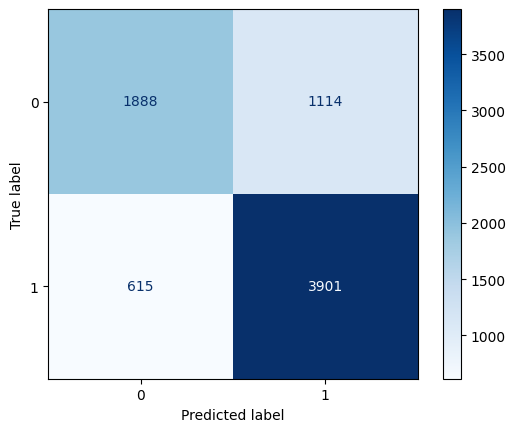

In [ ]:
# Ejemplo de uso de la función modelo_LSTM
accuracy, cm, sensibilidad, especificidad, f1 = modelo_LSTM(units=64, epochs=10, batch_size=32, dropout=0.5)

# Mostrar las métricas por pantalla
print(f'Accuracy: {accuracy}')
print(f'Sensibilidad (Recall): {sensibilidad}')
print(f'Especificidad: {especificidad}')
print(f'F1 Score: {f1}')

# Visualizo la matriz de confusión
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(cmap=plt.cm.Blues)
plt.show()


Pruebo el modelo con otros hiperparámetros.

In [ ]:
# Ejemplo de uso de la función modelo_LSTM
accuracy, cm, sensitivity, specificity, f1 = modelo_LSTM(units=32, epochs=10, batch_size=8, dropout=0.3)

# Mostrar las métricas por pantalla
print(f'Accuracy: {accuracy}')
print(f'Confusion Matrix:\n{cm}')
print(f'Sensibilidad (Recall): {sensibilidad}')
print(f'Especificidad: {especificidad}')
print(f'F1 Score: {f1}')

Epoch 1/10
2925/2925 [==============================] - 122s 39ms/step - loss: 0.6585 - accuracy: 0.6264 - val_loss: 0.6089 - val_accuracy: 0.6882
Epoch 2/10
2925/2925 [==============================] - 130s 44ms/step - loss: 0.5301 - accuracy: 0.7457 - val_loss: 0.5133 - val_accuracy: 0.7494
Epoch 3/10
2925/2925 [==============================] - 114s 39ms/step - loss: 0.4654 - accuracy: 0.7853 - val_loss: 0.5025 - val_accuracy: 0.7605
Epoch 4/10
2925/2925 [==============================] - 105s 36ms/step - loss: 0.4319 - accuracy: 0.8013 - val_loss: 0.4890 - val_accuracy: 0.7591
Epoch 5/10
2925/2925 [==============================] - 107s 36ms/step - loss: 0.4026 - accuracy: 0.8217 - val_loss: 0.4959 - val_accuracy: 0.7631
Epoch 6/10
2925/2925 [==============================] - 117s 40ms/step - loss: 0.3743 - accuracy: 0.8359 - val_loss: 0.4886 - val_accuracy: 0.7634
Epoch 7/10
2925/2925 [==============================] - 112s 38ms/step - loss: 0.3504 - accuracy: 0.8509 - val_loss: 0

Como puede apreciase los dos modelos generados son muy sencillos pero aún así dado que se está utilizando un red LSTM se están obteniendo unos resultados aceptables. De nuevo, resaltar que no se está persiguiendo obtener un modelo con el mejor rendimiento posible sino que se trata de realizar distintas pruebas para poder compararlo con MLFlow.

##MLFlow

Hasta este momento todo lo que se ha implementado ha sido un clasificador básico siguiendo los pasos necesarios que han de seguirse para realizar un ejercicio de NLP. Seguidamente, se va a implementar lo solicitado en la práctica: Utilizar MLflow para registrar métricas y hiperparámetros durante el entrenamiento, facilitando la gestión y comparación de experimentos. Durante este ejercicio es posible apreciar como se han realizado distintas pruebas con los hiperparámetros y como en función de los mismos el resultado ha sido uno u otro. Lo que se pretende por medio de la utilización del MLFlow es poseer en un gráfico una comparación de los distintos modelos generados. Para ello, lo que se hace es para entrenamiento del modelo guardar los resultados en MLFlow y una vez que se poseen todos, la propia herramienta ofrece la comparación.

Este proceso es muy interesante de realizar ya que si se automatiza correctamente permite guardar el registro de las métricas obtenidas durante todos los entrenamientos. No es necesario por ejemplo que los entrenamientos se diferencien por el cambio de hiperparámetros, sino que también puede deberse debido al cambio de datos de entrada. Por ejemplo, puede interesar automatizar un modelo que sepa capaz de predecir nuevas reseñas que se han escrito cada semana. Para ello es necesario automatizar todo el proceso y eso pasa para empezar por generar el archivo de funciones y su orquestador

El archivo de funciones es un archivo que agrupa todas los cambios que se aplican durante el preprocesamiento de los datos. En este caso como se han introducido muchos cambios, para cada cambio se ha definido una función de modo que sea más limpio y eficiente el preprocesamiento. El hecho de que durante el preprocesamiento se haya generado el pipeline y las funciones para generar embeddings y el modelo, hace que generar el archivo funciones sea mucho más sencillo. Lo que se pretende es generar para cada cambio una función y luego generar una función generarl que englobe a todas ellas.

Con el fin de tener todo instalado fuera del fichero de funciones, ejecuto la instalación de las librerías necesarias para realizar el preprocesamiento y la conexión con MLFlow.

In [14]:
!pip install pyngrok
!pip install mlflow
!pip install contractions

In [18]:
import nltk
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords, wordnet
# Descargar los recursos necesarios de NLTK
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('averaged_perceptron_tagger')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!


True

A continuación genero el fichero funciones.py. Es posible observar como este fichero es muy parecido al pipeline generado para train y test en el el apartado de pipelines del ejercicio.

In [18]:
%%writefile "/content/drive/MyDrive/Práctica Despliegue Algoritmos/funciones.py"
import pandas as pd
import re
import contractions
import nltk
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords, wordnet
from nltk.stem import WordNetLemmatizer
import string
from sklearn.utils import resample
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from sklearn.metrics import confusion_matrix, accuracy_score, recall_score, f1_score

# Inicializar lematizador
lemmatizer = WordNetLemmatizer()

# Símbolos a eliminar
symbols_to_remove = ["``", "''", "...", "--", "..", "..."]

# Conjunto de stopwords y puntuación
stop_words = set(stopwords.words('english'))
punctuation = set(string.punctuation)

# Función para expandir contracciones y quitar posesiones
def clean_text(text):
    expanded_text = contractions.fix(text)
    text_without_possession = expanded_text.replace("'s", "")
    return text_without_possession

# Función para limpiar los tokens
def clean_tokens(tokens):
    clean_tokens = [token.lower() for token in tokens if token.lower() not in stop_words and token not in punctuation]
    return clean_tokens

# Función para eliminar símbolos
def remove_symbols(tokens):
    clean_tokens = [re.sub('|'.join(map(re.escape, symbols_to_remove)), '', token) for token in tokens]
    clean_tokens = [token.strip() for token in clean_tokens if token.strip()]
    return clean_tokens

# Función para lemmatizar los tokens
def lemmatize_tokens(tokens):
    lemmatized_tokens = []
    for word in tokens:
        pos_tag = nltk.pos_tag([word])[0][1][0].upper()
        wordnet_pos = {
            'N': wordnet.NOUN,
            'V': wordnet.VERB,
            'J': wordnet.ADJ,
            'R': wordnet.ADV
        }.get(pos_tag, wordnet.NOUN)
        lemmatized_word = lemmatizer.lemmatize(word, pos=wordnet_pos).lower().strip()
        lemmatized_tokens.append(lemmatized_word)
    return lemmatized_tokens

# Función de submuestreo (undersampling)
def undersample_data(data, label_column):
    min_count = data[label_column].value_counts().min()
    resampled_frames = []
    for label in data[label_column].unique():
        df_class = data[data[label_column] == label]
        df_class_undersampled = resample(df_class,
                                         replace=False,
                                         n_samples=min_count,
                                         random_state=42)
        resampled_frames.append(df_class_undersampled)
    balanced_data = pd.concat(resampled_frames)
    return balanced_data

# Crear pipeline
def nlp_pipeline(text):
    expanded_text = clean_text(text)
    tokens = word_tokenize(expanded_text)
    cleaned_tokens = clean_tokens(tokens)
    symbols_removed = remove_symbols(cleaned_tokens)
    lemmatized_tokens = lemmatize_tokens(symbols_removed)
    return lemmatized_tokens

# Función para generar vectores de reseña en batches
def generate_review_vectors(model, reviews, max_length, batch_size):
    for i in range(0, len(reviews), batch_size):
        batch_reviews = reviews[i:i+batch_size]
        batch_vectors = []
        for tokens in batch_reviews:
            embeddings = [model.wv[token] for token in tokens if token in model.wv]
            if len(embeddings) < max_length:
                embeddings.extend([np.zeros(model.vector_size)] * (max_length - len(embeddings)))
            elif len(embeddings) > max_length:
                embeddings = embeddings[:max_length]
            batch_vectors.append(embeddings)
        yield np.array(batch_vectors)

# Función para crear y evaluar el modelo LSTM
def modelo_LSTM(units, epochs, batch_size, dropout, embeddings_train, y_train, embeddings_validation, y_validation, embeddings_test, y_test):
    model = Sequential()
    model.add(LSTM(units=units, input_shape=(embeddings_train.shape[1], 100)))
    model.add(Dropout(dropout))
    model.add(Dense(1, activation='sigmoid'))

    model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

    history = model.fit(embeddings_train, y_train, validation_data=(embeddings_validation, y_validation), epochs=epochs, batch_size=batch_size)

    _, accuracy = model.evaluate(embeddings_test, y_test)
    y_pred = (model.predict(embeddings_test) > 0.5).astype("int32")

    cm = confusion_matrix(y_test, y_pred)
    sensibilidad = recall_score(y_test, y_pred)
    especificidad = cm[0,0] / (cm[0,0] + cm[0,1])
    f1 = f1_score(y_test, y_pred)

    return accuracy, cm, sensibilidad, especificidad, f1


Overwriting /content/drive/MyDrive/Práctica Despliegue Algoritmos/funciones.py


Una vez generado el fichero importo la función para comprobar que funciona todo correctamente y genero los embeddings como prueba. Destacar que con el fin de ahorrar tiempo y coste computacional, no ejecuto el preprocesamiento de datos desde el principio sino que lo ejecuto desde el punto de control donde se han almacenado los datos ya preprocesados.

In [34]:
import sys
sys.path.append('/content/drive/MyDrive/Práctica Despliegue Algoritmos')

import funciones as func


In [12]:
import pandas as pd
from sklearn.model_selection import train_test_split
from gensim.models import Word2Vec
import numpy as np

# Cargar datos de entrenamiento y test
train_data = pd.read_csv("/content/drive/MyDrive/Práctica Despliegue Algoritmos/data_train_processed.csv", sep=';')
test_data = pd.read_csv("/content/drive/MyDrive/Práctica Despliegue Algoritmos/data_test_processed.csv", sep=';')

train_data['tokens'] = train_data['tokens'].apply(eval)
test_data['tokens'] = test_data['tokens'].apply(eval)

# Categorizo datos
train_data['category'] = train_data['rating_note'].apply(lambda x: 1 if x >= 3 else 0)
test_data['category'] = test_data['rating_note'].apply(lambda x: 1 if x >= 3 else 0)

# Dividir datos en conjuntos de entrenamiento y validación
y_train = train_data['category']
y_test = test_data['category']
train_data, validation_data, y_train, y_validation = train_test_split(train_data, y_train, test_size=0.2, random_state=42)

# Cargar modelo Word2Vec
w2v_model_path = "/content/drive/MyDrive/Práctica Despliegue Algoritmos/modelo_entrenado.word2vec"
w2v_model = Word2Vec.load(w2v_model_path)

# Generar vectores de reseña
max_length = int(train_data['cardinality'].quantile(0.75))
batch_size_gen = 10000

embeddings_train = np.concatenate([vectors for vectors in func.generate_review_vectors(w2v_model, train_data['tokens'], max_length, batch_size_gen)], axis=0)
embeddings_validation = np.concatenate([vectors for vectors in func.generate_review_vectors(w2v_model, validation_data['tokens'], max_length, batch_size_gen)], axis=0)
embeddings_test = np.concatenate([vectors for vectors in func.generate_review_vectors(w2v_model, test_data['tokens'], max_length, batch_size_gen)], axis=0)

print("Dimensión embedding train:", embeddings_train.shape)
print("Dimensión embedding validación:",embeddings_validation.shape)
print("Dimensión embedding test:",embeddings_test.shape)


(23397, 73, 100)
(5850, 73, 100)
(7518, 73, 100)


Seguidamente creo la conexión entre el notebook y MLFlow. La conexión la realizo a través del puerto 5000 y apoyándome en el token ID de mi cuenta de MLFlow.

In [21]:
from pyngrok import ngrok

ngrok.kill()

get_ipython().system_raw('mlflow ui --port 5000 &')


NGROK_AUTH_TOKEN = '2geAw6PtOFifVBxQqB2p94osoli_3Gjgb5J4z7t2TESPgmT2Y'
ngrok.set_auth_token(NGROK_AUTH_TOKEN)

ngrok_tunnel = ngrok.connect(addr='5000', proto='http', bind_tls=True)
print('El tracking UI:', ngrok_tunnel.public_url)


El tracking UI: https://ca79-34-82-242-251.ngrok-free.app


Por último, configuro el orquestador de funciones (main.py). Dado que a mi me interesa ejecutar distintos modelos con distintas configuraciones de hiperparámetros, creo bucles anidados para que se prueben modelos con distintas configuraciones de hiperparámetros. El hiperparámetro del número épocas lo voy a dejar fijo ya que como entrenar los modelos lleva tiempo, tampoco quiero realizar muchos entrenamientos. En total solamente se van a realizar 8 entrenamientos en donde los hiperparámetros que se van a modificar van a ser los siguientes con los respectivos valores:

* Batch size = 256 o 128
* Unit list = 64 o 32
* Dropour rate = 0.5 o 0.3

Los valores que he elegido son elevados porque me interesa que los entrenamientos sean lo más rápidos posibles. Obviamente, los rendimientos que se obtendrán puede que no sean los mejores dado que los hiperparámetros elegidos son aleatorios. Sin embargo, creo que van a permitir poder generar una comparación interesante entre los distintos modelos. En caso de que se quisiera generar el modelo con mejor rendimiento sería conveniente hacer uso de la función hyper-opt para hallar el valor de los hiperparámetros que generan el mejor rendimiento.

In [31]:
%%writefile "/content/drive/MyDrive/Práctica Despliegue Algoritmos/main2.py"

import os
import pandas as pd
import numpy as np
import mlflow
import mlflow.keras
import time
import argparse
from sklearn.model_selection import train_test_split
from gensim.models import Word2Vec
from funciones import undersample_data, nlp_pipeline, generate_review_vectors, modelo_LSTM
from pyngrok import ngrok
import subprocess
import sys
sys.path.append('/content/drive/MyDrive/Práctica Despliegue Algoritmos')
import funciones as func

def free_port(port):
    # Libera el puerto especificado matando cualquier proceso que lo esté usando
    os.system(f"fuser -k {port}/tcp")

def main():
    parser = argparse.ArgumentParser(description='Argumentos de entrada en el main')
    parser.add_argument('--nombre_run', type=str, help='Nombre para la run de entrenamiento', required=True)
    parser.add_argument('--units_list', nargs='+', type=int, help='Lista de unidades para LSTM.', required=True)
    parser.add_argument('--epochs', type=int, help='Número de épocas.', required=True)
    parser.add_argument('--batch_sizes', nargs='+', type=int, help='Lista de tamaños de batch.', required=True)
    parser.add_argument('--dropouts', nargs='+', type=float, help='Lista de tasas de dropout.', required=True)
    args = parser.parse_args()

    # Validación de argumentos
    assert args.epochs > 0, "El número de épocas debe ser positivo."
    assert all(batch_size > 0 for batch_size in args.batch_sizes), "Todos los tamaños de batch deben ser positivos."
    assert all(0 <= dropout < 1 for dropout in args.dropouts), "Todas las tasas de dropout deben estar entre 0 y 1."

    nombre_run = args.nombre_run
    units_list = args.units_list
    epochs = args.epochs
    batch_sizes = args.batch_sizes
    dropouts = args.dropouts

    # Cargar datos de entrenamiento y test
    train_data = pd.read_csv("/content/drive/MyDrive/Práctica Despliegue Algoritmos/data_train_processed.csv", sep=';')
    test_data = pd.read_csv("/content/drive/MyDrive/Práctica Despliegue Algoritmos/data_test_processed.csv", sep=';')

    train_data['tokens'] = train_data['tokens'].apply(eval)
    test_data['tokens'] = test_data['tokens'].apply(eval)

    # Categorizo datos
    train_data['category'] = train_data['rating_note'].apply(lambda x: 1 if x >= 3 else 0)
    test_data['category'] = test_data['rating_note'].apply(lambda x: 1 if x >= 3 else 0)

    # Dividir datos en conjuntos de entrenamiento y validación
    y_train = train_data['category']
    y_test = test_data['category']
    train_data, validation_data, y_train, y_validation = train_test_split(train_data, y_train, test_size=0.2, random_state=42)

    # Cargar modelo Word2Vec
    w2v_model_path = "/content/drive/MyDrive/Práctica Despliegue Algoritmos/modelo_entrenado.word2vec"
    w2v_model = Word2Vec.load(w2v_model_path)

    # Generar vectores de reseña
    max_length = int(train_data['cardinality'].quantile(0.75))
    batch_size_gen = 10000

    embeddings_train = np.concatenate([vectors for vectors in func.generate_review_vectors(w2v_model, train_data['tokens'], max_length, batch_size_gen)], axis=0)
    embeddings_validation = np.concatenate([vectors for vectors in func.generate_review_vectors(w2v_model, validation_data['tokens'], max_length, batch_size_gen)], axis=0)
    embeddings_test = np.concatenate([vectors for vectors in func.generate_review_vectors(w2v_model, test_data['tokens'], max_length, batch_size_gen)], axis=0)

    #Entrenamiento y log del modelo
    mlflow_ui_process = subprocess.Popen(['mlflow', 'ui', '--port', '5000'])
    time.sleep(5)
    mlflow.set_experiment('Pruebas desde script')

    for units in units_list:
            for batch_size in batch_sizes:
                for dropout in dropouts:
                    with mlflow.start_run(run_name=nombre_run) as run:
                        accuracy, cm, sensibilidad, especificidad, f1 = func.modelo_LSTM(units, epochs, batch_size, dropout, embeddings_train, y_train, embeddings_validation, y_validation, embeddings_test, y_test)

                        mlflow.log_metric('accuracy', accuracy)
                        mlflow.log_metric('sensibilidad', sensibilidad)
                        mlflow.log_metric('especificidad', especificidad)
                        mlflow.log_metric('f1', f1)
                        mlflow.log_param('units', units)
                        mlflow.log_param('epochs', epochs)
                        mlflow.log_param('batch_size', batch_size)
                        mlflow.log_param('dropout', dropout)

    # Asegúrate de cerrar el proceso ngrok
    ngrok.kill()

if __name__ == '__main__':
    main()


Writing /content/drive/MyDrive/Práctica Despliegue Algoritmos/main2.py


In [33]:
!python3 "/content/drive/MyDrive/Práctica Despliegue Algoritmos/main2.py" \
--nombre_run "PruebasConLSTM" \
--units_list 64 32 \
--epochs 10 \
--batch_size 256 128 \
--dropout 0.5 0.3


2024-05-18 16:43:28.390438: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-05-18 16:43:28.390518: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-05-18 16:43:28.392427: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-05-18 16:43:31.023573: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
[2024-05-18 16:43:52 +0000] [55368] [INFO] Starting gunicorn 22.0.0
[2024-05-18 16:43:52 +0000] [55368] [ERROR] Connection in use: ('127.0.0.1', 5000)
[2024-05-18 16:43:52 +0000] [55368] [ERROR] Retrying in 1 second.
[2024-05-18 16:43:53 +00

##Métricas en MLFlow

Después de realizar los distintos entrenamientos es posible apreciar como en MLFlow aparecen los resultados de cada uno de ellos.

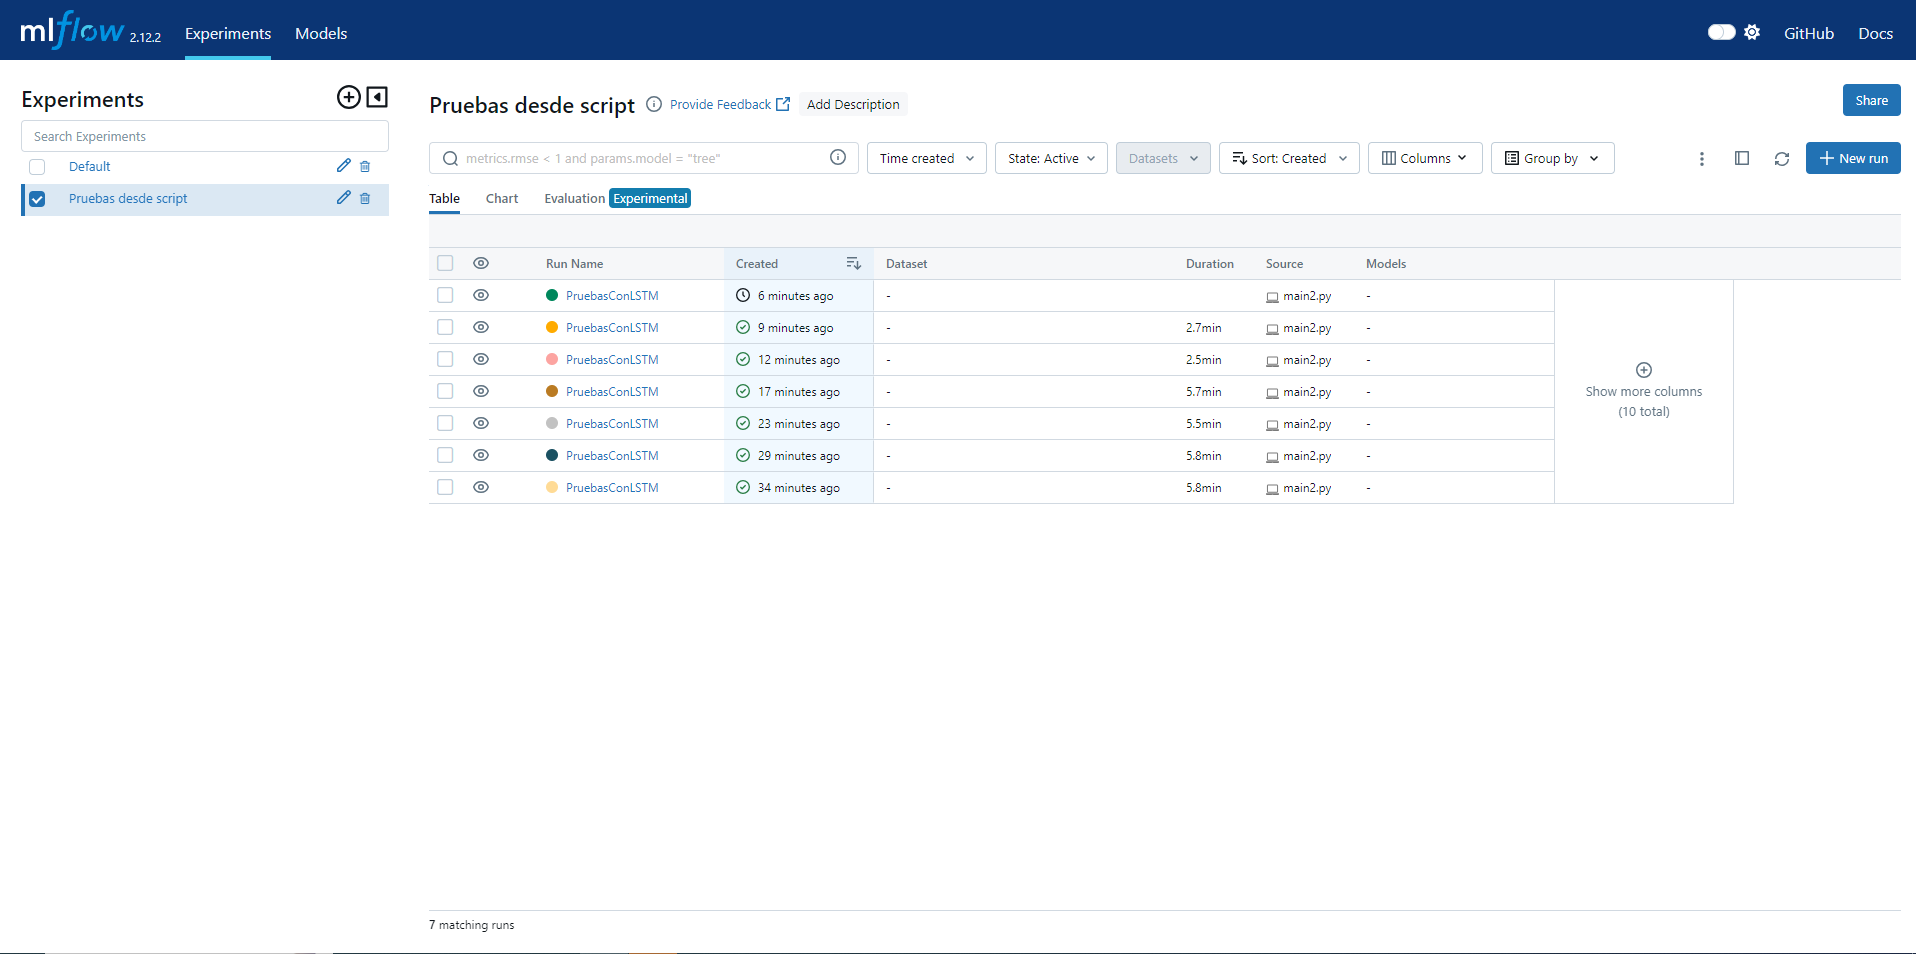

Cada uno de los entrenamientos ha sido realizado con distintos valores de hiperparámetros por lo que el resultado obtenido para cada uno de ellos es distintos. Accediendo a la ventana de comparación de MLFLow, se puede generar una tabla que permita conocer los valores de los hiperparámetros con los que ha sido entrenado y el resultado del mismo.

.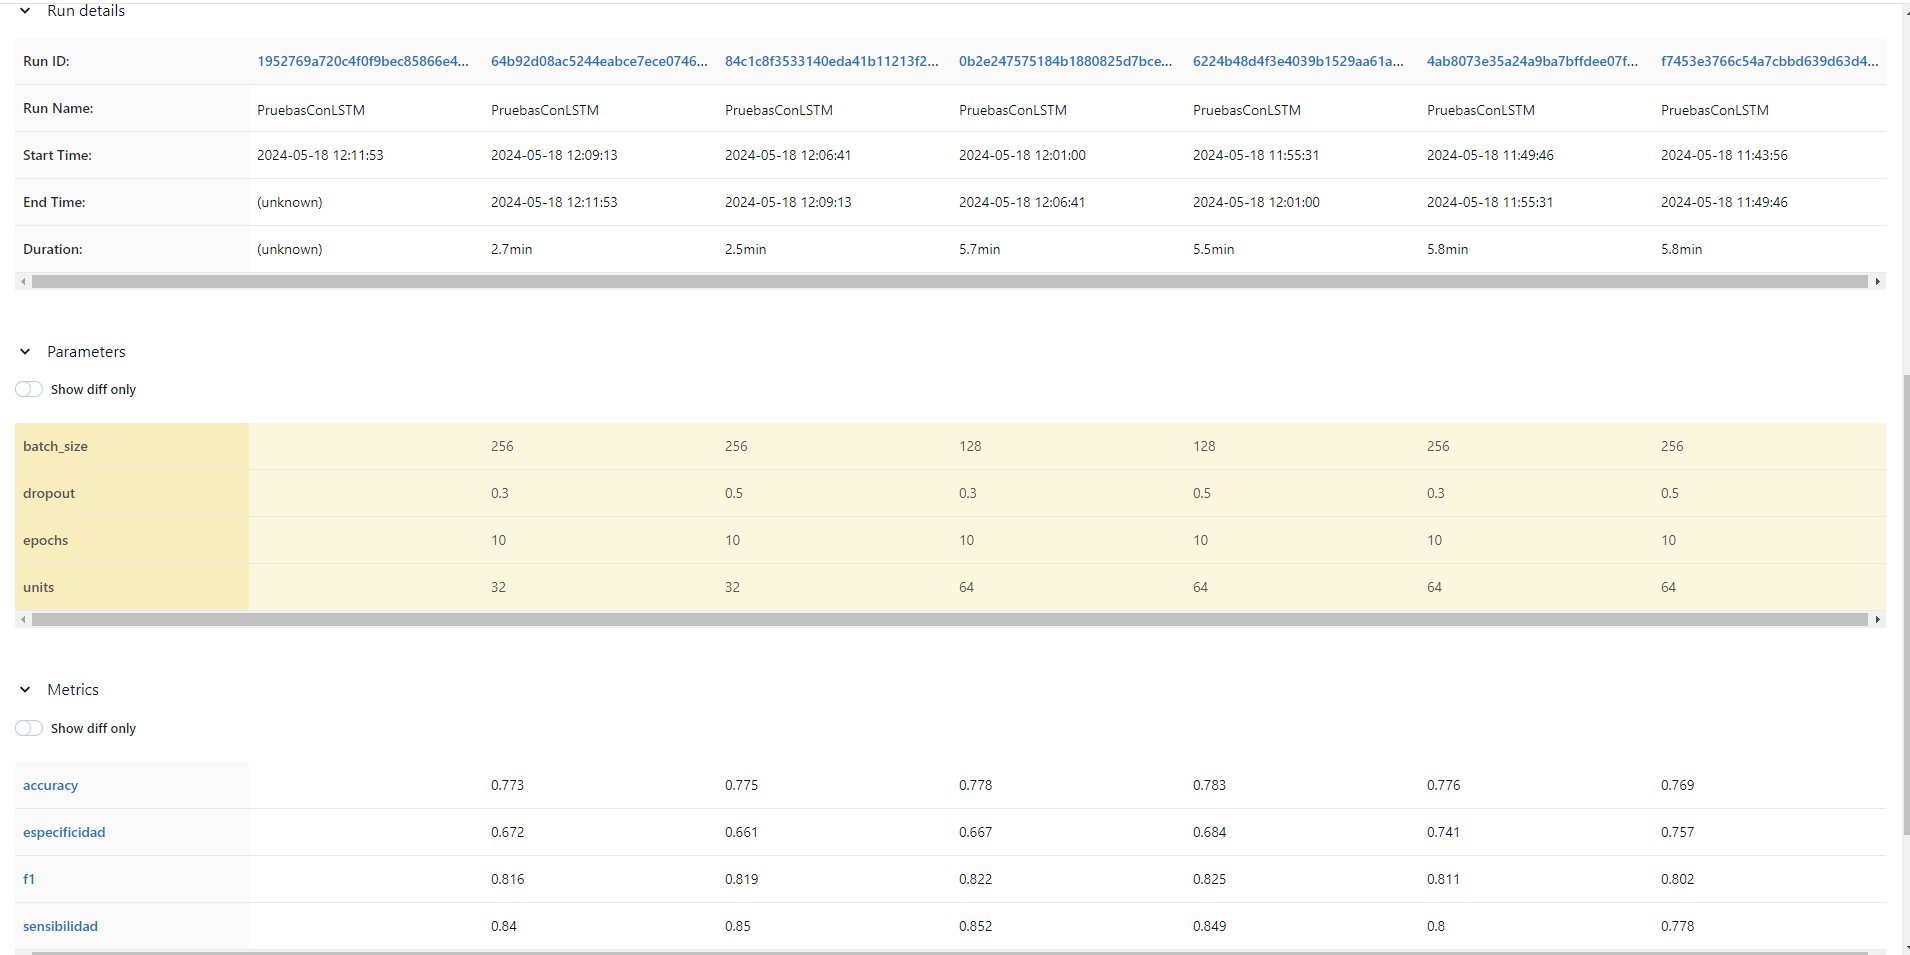

La primera conclusión que se puede extraer de los datos es que en el séptimo entrenamiento ha ocurrido un error que ha impedido que ha provocado que no se ejecute ni el séptimo ni el octavo entrenamiento. Observando el historial de entrenamiento, se aprecia como la ejecución se ha interrumpido de forma abrupta por lo que al haberse interrumpido, en MLFlow no se puede acceder a las métricas. Ejecutar todos los entrenamientos lleva su tiempo y como en este caso ya se han obtenido seis entrenamiento distintos, no voy a ejecutar de nuevo los ocho ya que considero que la comparación puede realizarse.

Fijandome unicamente entre los seis entrenamientos que se han realizado se puede apreciar como el accuracy para cada uno de ellos es distinto pero con una variación mínima. El peor rendimiento es el corrrespondiente al sexto entrenamiento (rendimiento de 0.773) y el mejor el correspondiente al tercer entrenamiento (0.783). La diferencia entre los dos extremos es mínima por lo que es posible afirmar que cualquiera de los modelos generados van a tener una buen rendimiento a la hora de utilizarlo.

Por otro lado, aparte de conocer el rendimiento, creo que también era interesante conocer las otras métricas de clasificación para comprobar que el modelo no se estuviera sesgando hacia una clase predomiante. En principio, en este caso no iba a ocurrir ya que durante el preprocesamiento se han balanceado los datos pero siempre es bueno conocer el valor de estas métricas. En principio las métricas obtenidos para cada modelo son muy parecidas y todas presentan unos valores muy buenos por lo que cualquiera de los modelos podría ser utilizado. Lo que habría que plantearse es el uso que se le quiere dar al modelo. Es decir, si se desea tener un modelo que clasifique perfectamente tanto los negativos como los positivos, la métrica a utilizar sería el accuracy pero si se quisiera el mejor modelo que clasificará correctamente los negativos, la métrica a utilizar sería la especificidad. Todo depende del uso que se le quiera dar al modelo.

Por último, resaltar lo útil que puede ser esta herramienta porque de una forma sencilla e intuitiva permite generar una comparación entre modelos y conocer los hiperparámetros con los que ha sido entrenado. Esto puede ser útil para conocer cuales son los valores de los hiperparámetros que generan el mejor rendimiento o también puede ser útil para obtener una evolución del rendimiento del modelo en función de los datos de entrada (en ese caso habría que fijar los valores de los hiperparámetros). Además, MLFlow permite generar gráficos que pueden ser interesantes, como puede ser la comparación entre hiperparámetros y métricas, lo cual es interesante desde un punto de vista de entender el modelo.

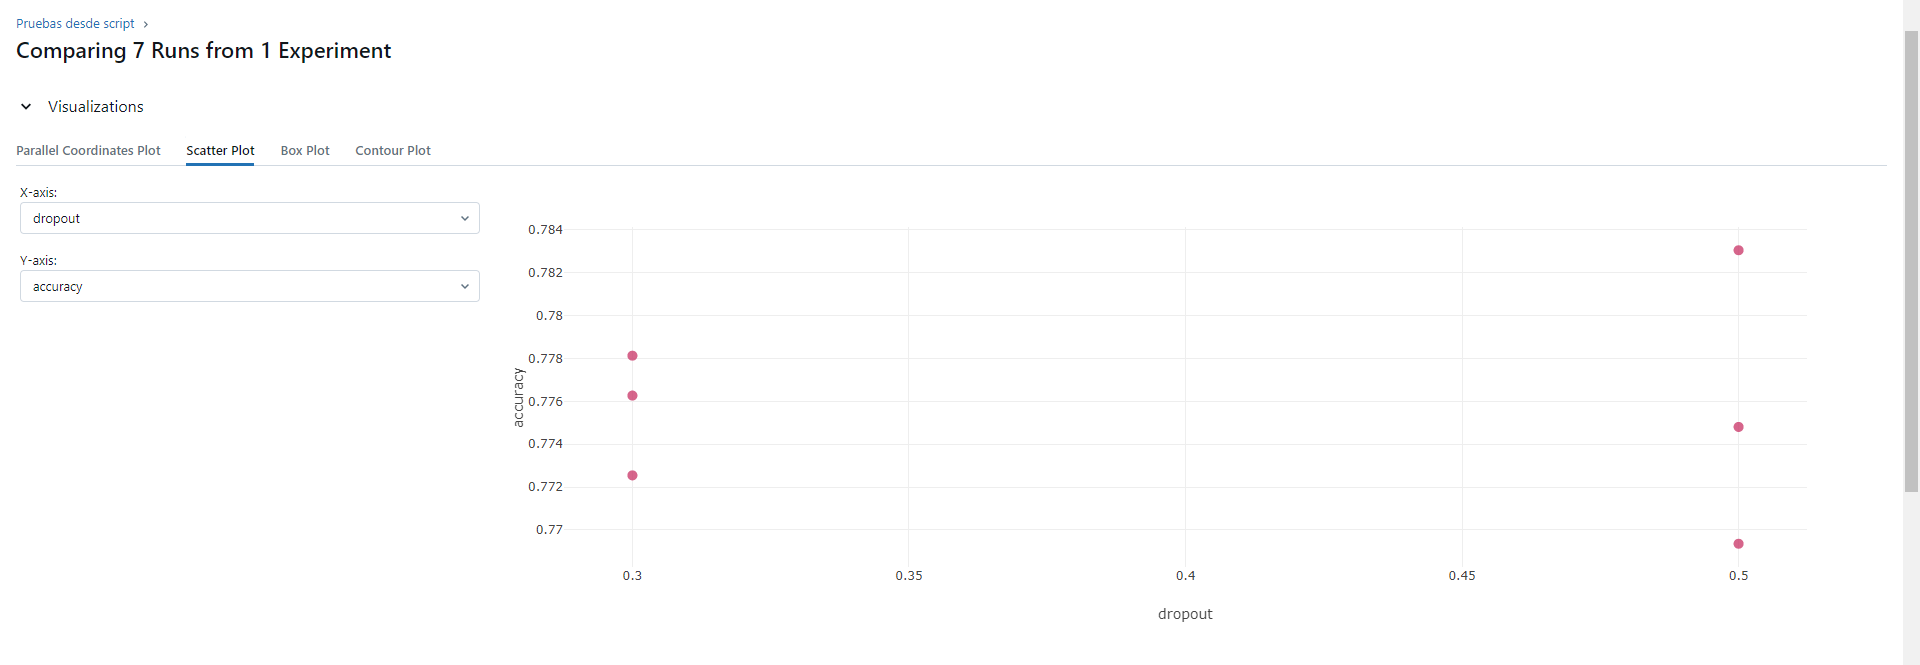

En definitiva, MLFlow es una herramienta que puede ser muy interesante desde el punto de vista de negocio de una empresa. Me parece que esta herramienta permitir entender a una persona que no sabe nada de programación cual es el mejor modelo y el motivo. Es por eso que creo que esta herramienta puede ser muy útil a la hora de tomar decisiones ya que sin conocer que es lo que está ocurriendo, una persona puede argumentar el motivo por el que se decanta por un modelo u otro.

#Apartado 2: FastAPI

##Implementación de la API

En el segundo apartado de la práctica se soicita la generación de cinco módulos app.get haciendo uso de la función FastAPI. Además se solicita que dos de estos cinco módulos sean utilizando la página Hugging Face. En el enunciado no se especifican la función de cada uno de los módulos por lo que la elección es libre. En mi opinión me parece que Hugging Face es una página muy interesante dado que su versatilidad: se pueden descargar modelos que realicen resumenes, que respondan a preguntas, que traduzcan... Dado que la posibilidad de implementación son infinitas, lo que voy a desarrollar cinco módulos cada uno de ellos distintos.

El primero de ellos va a ser un módulo muy sencillo. Simplemente va a ser un módulo que cuando se le llame va a indicar cual es la fecha y la hora actual. Para ello voy a hacer uso de las funciones current_date y current_time. Dado que current_date se genera en inglés, la respuesta de la función va a ser también en inglés.

El segundo módulo que se va a implementar va a ser un modelo QA al cual el usuario va a introducir una pregunta y un contexto y el modelo va a generar la respuesta a la pregunta. Para este módulo voy a utilizar el modelo Roberta dado que es mucho más completo que un modelo base simple. El modelo ha sido entrenado en español por lo que su rendimiento suele ser mejor si el contexto y la pregunta son en español.

El tercer módulo va ser un modelo de resumen: se va a introducir un párrafo al modelo y este va a generar el resumen del mismo. El modelo que se va a utilizar es el de summarization de Hugging Face que ha sido entrenado en inglés por lo que el párrafo que se va introducir para comprobar su funcionamiento va a ser también en inglés.

El cuarto módulo va ser un modelo de traducción: el modelo recibirá un input en inglés y lo traducirá al español. En este caso tras haber investigado Hugging Face voy a utilizar el modelo Helsinki dado que es muy popular y su rendimiento es muy bueno.

Finalmente, el último modelo va a ser un clasificador de reseñas de Amazon. Dado que en el primer apartado de la práctica se ha implementado un clasificador de reseñas binario, he decidido también implementar un clasificador de reseñas pero en este caso multiclase. El modelo va a intentar predecir la puntuación de la reseña en función del comentario (la puntuación puede ser 1, 2, 3, 4 o 5). Para ello, voy a utilizar un modelo bert de Hugging Face que permite clasificar reseñas escritas en esapañol.

Definidos los módulos, procedo a su implementación. Para ello, lo primero instalo las librerías pyngrok y FastAPI.

In [3]:
!pip install pyngrok

In [4]:
!pip install FastAPI

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 92.0/92.0 kB 3.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 71.9/71.9 kB 9.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 75.6/75.6 kB 8.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 53.6/53.6 kB 6.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 142.5/142.5 kB 12.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 60.8/60.8 kB 7.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 307.7/307.7 kB 12.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 47.2/47.2 kB 5.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 77.9/77.9 kB 9.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.3/58.3 kB 7.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 341.4/341.4 kB 13.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.4/3.4 MB 26.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━

Seguidamente, genero el fichero main. Lo primero que hago es para cada módulo descarga su modelo correspondiente y luego definir cada uno de los distintos módulos.

In [37]:
%%writefile main_API.py
from fastapi import FastAPI, Query
from transformers import pipeline
from datetime import datetime

#Inicalizo los modelos necesarios: todos los modelos proceden de Hugging Face.
qa_model = pipeline('question-answering', model='BSC-LT/roberta-base-bne-sqac')
summary_model = pipeline("summarization")
translation_model = pipeline("translation", model="Helsinki-NLP/opus-mt-en-es")
sentiment_analysis_model_es = pipeline("sentiment-analysis", model="nlptown/bert-base-multilingual-uncased-sentiment")


app = FastAPI()

# Módulo: Fecha y hora actual
@app.get('/date')
def get_current_date_and_time():
    now = datetime.now()
    current_date = now.strftime("%b %d")
    current_time = now.strftime("%H.%M")
    return {'message': f'Today is {current_date} and the current time is {current_time}'}



# Módulo: Pregunta y respuesta (español)
@app.get('/pregunta-respuesta')
def pregunta_respuesta(question: str = Query(..., title="Pregunta", description="Introduce tu pregunta"),
                       context: str = Query(..., title="Contexto", description="Introduce el contexto")):
    # Realizar la pregunta al modelo de pregunta-respuesta
    result = qa_model(question=question, context=context)

    # Devolver la respuesta obtenida del modelo
    return {'Respuesta': result['answer']}




# Módulo para resumir párrafos (inglés)
@app.get('/summary')
def resumen_parrafo_ingles(Paragraph: str = Query(..., title="Párrafo", description="Introduce the paragraph")):
    # Generar el resumen del párrafo utilizando el modelo de resumen de Hugging Face
    summary = summary_model(Paragraph, max_length=50, min_length=10, do_sample=False)[0]['summary_text']

    # Devolver el resumen generado
    return {'resumen': summary}



# Módulo para traducir del inglés al español
@app.get('/traducir')
def traducir_espanol(Texto: str = Query(..., title="Texto", description="Introduce el texto en inglés a traducir")):
    # Realizar la traducción de inglés a español utilizando el modelo de traducción de Hugging Face
    translated_text = translation_model(Texto)[0]['translation_text']

    # Devolver el texto traducido
    return {'texto_traducido': translated_text}



# Módulo para clasificar las reseñas de Amazon (español)
@app.get('/análisis-reseña')
def categorizacion_valoraciones(Reseña: str = Query(..., title="Reseña", description="Introduce la reseña de Amazon")):
    # Analizar el sentimiento de la reseña utilizando el modelo de análisis de sentimiento en español
    sentiment = sentiment_analysis_model_es(Reseña)[0]

    # Devolver el sentimiento analizado
    return {'sentimiento': sentiment['label'], 'puntaje': sentiment['score']}




Overwriting main_API.py


A continuación, elimino todos los posibles procesos de ngrok y realizo la conexión.

In [38]:
import nest_asyncio
from pyngrok import ngrok, conf
NGROK_TOKEN = "2geAw6PtOFifVBxQqB2p94osoli_3Gjgb5J4z7t2TESPgmT2Y"
conf.get_default().auth_token = NGROK_TOKEN
ngrok_tunnel = ngrok.connect(8000)
print('Public URL:', ngrok_tunnel.public_url)
nest_asyncio.apply()

Public URL: https://b29f-34-125-14-90.ngrok-free.app


Por último, incializo la conexión.

In [39]:
!uvicorn main_API:app --host 0.0.0.0 --port 8000 --reload


INFO:     Will watch for changes in these directories: ['/content']
INFO:     Uvicorn running on http://0.0.0.0:8000 (Press CTRL+C to quit)
INFO:     Started reloader process [11053] using WatchFiles
2024-05-18 21:06:05.510993: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-05-18 21:06:05.511062: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-05-18 21:06:05.512597: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-05-18 21:06:07.077800: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
No model was supplied, defaulted to sshle

##Resultados obtenidos

Por medio de capturas de pantallas se presentan los la interfaz obtenida. La primera captura de pantalla muestra una visión global de la interfaz con los cinco módulos. Como puede apreciarse todos ellos son de tipo get y en la descripicón indica el objetivo de cada uno.

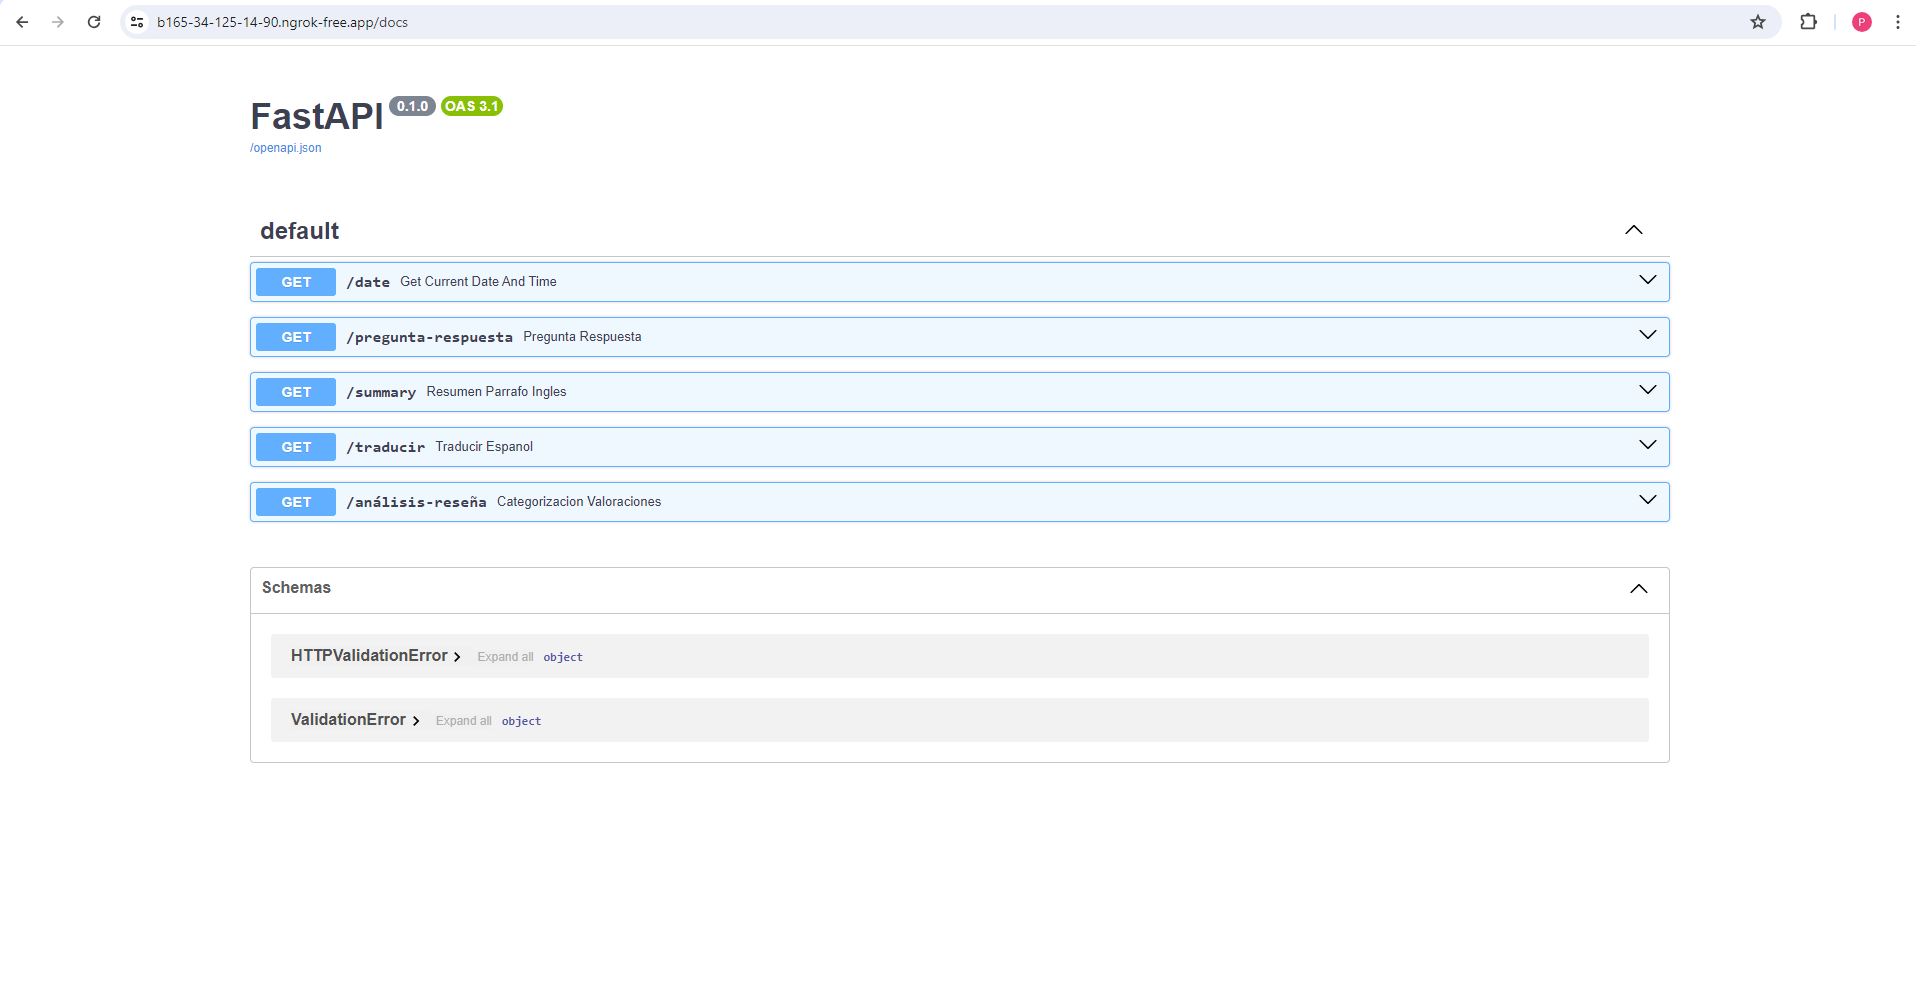

Lo que se va a presentar para cada módulo son dos capturas de pantallas: una donde se muestra recuadrada en rojo la respuesta de cada uno de los módulos y una segunda donde se observa la respuesta cuando se ejectua directamente sobre la URL. Tal y cual se puede observar el resultado obtenidos por cualquiera de los dos métodos es el mismo.

###Módulo: Fecha y hora actual

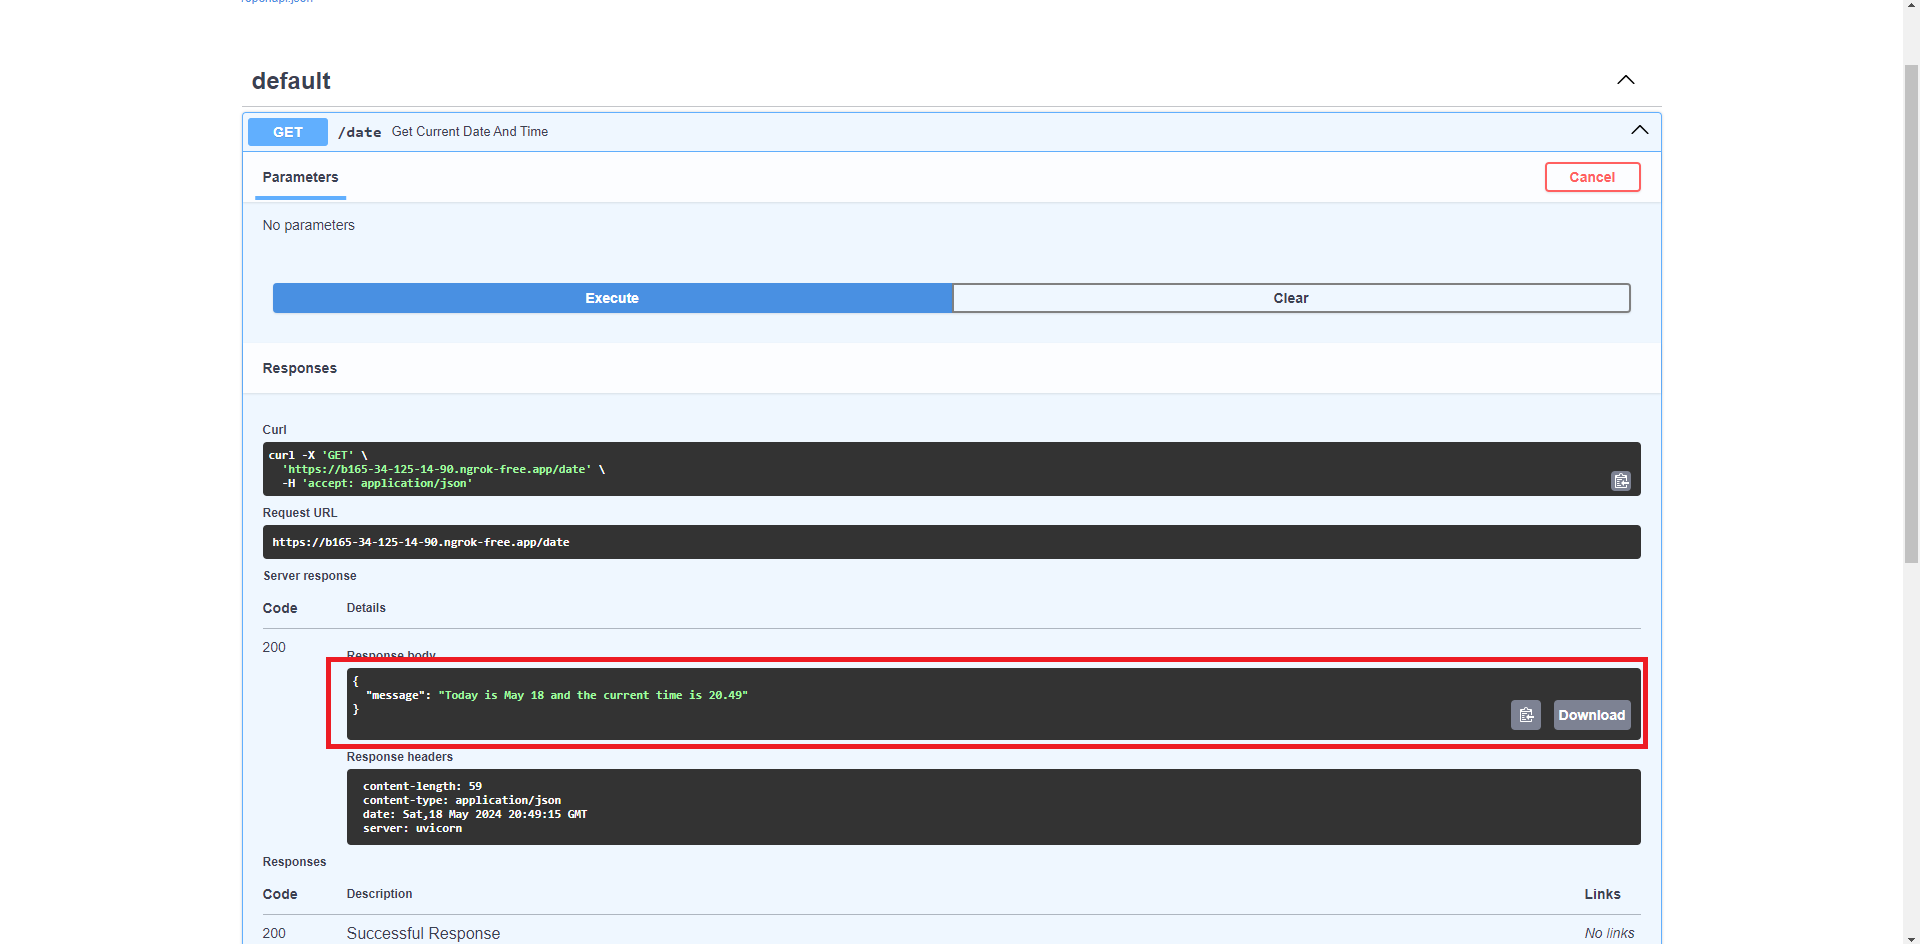

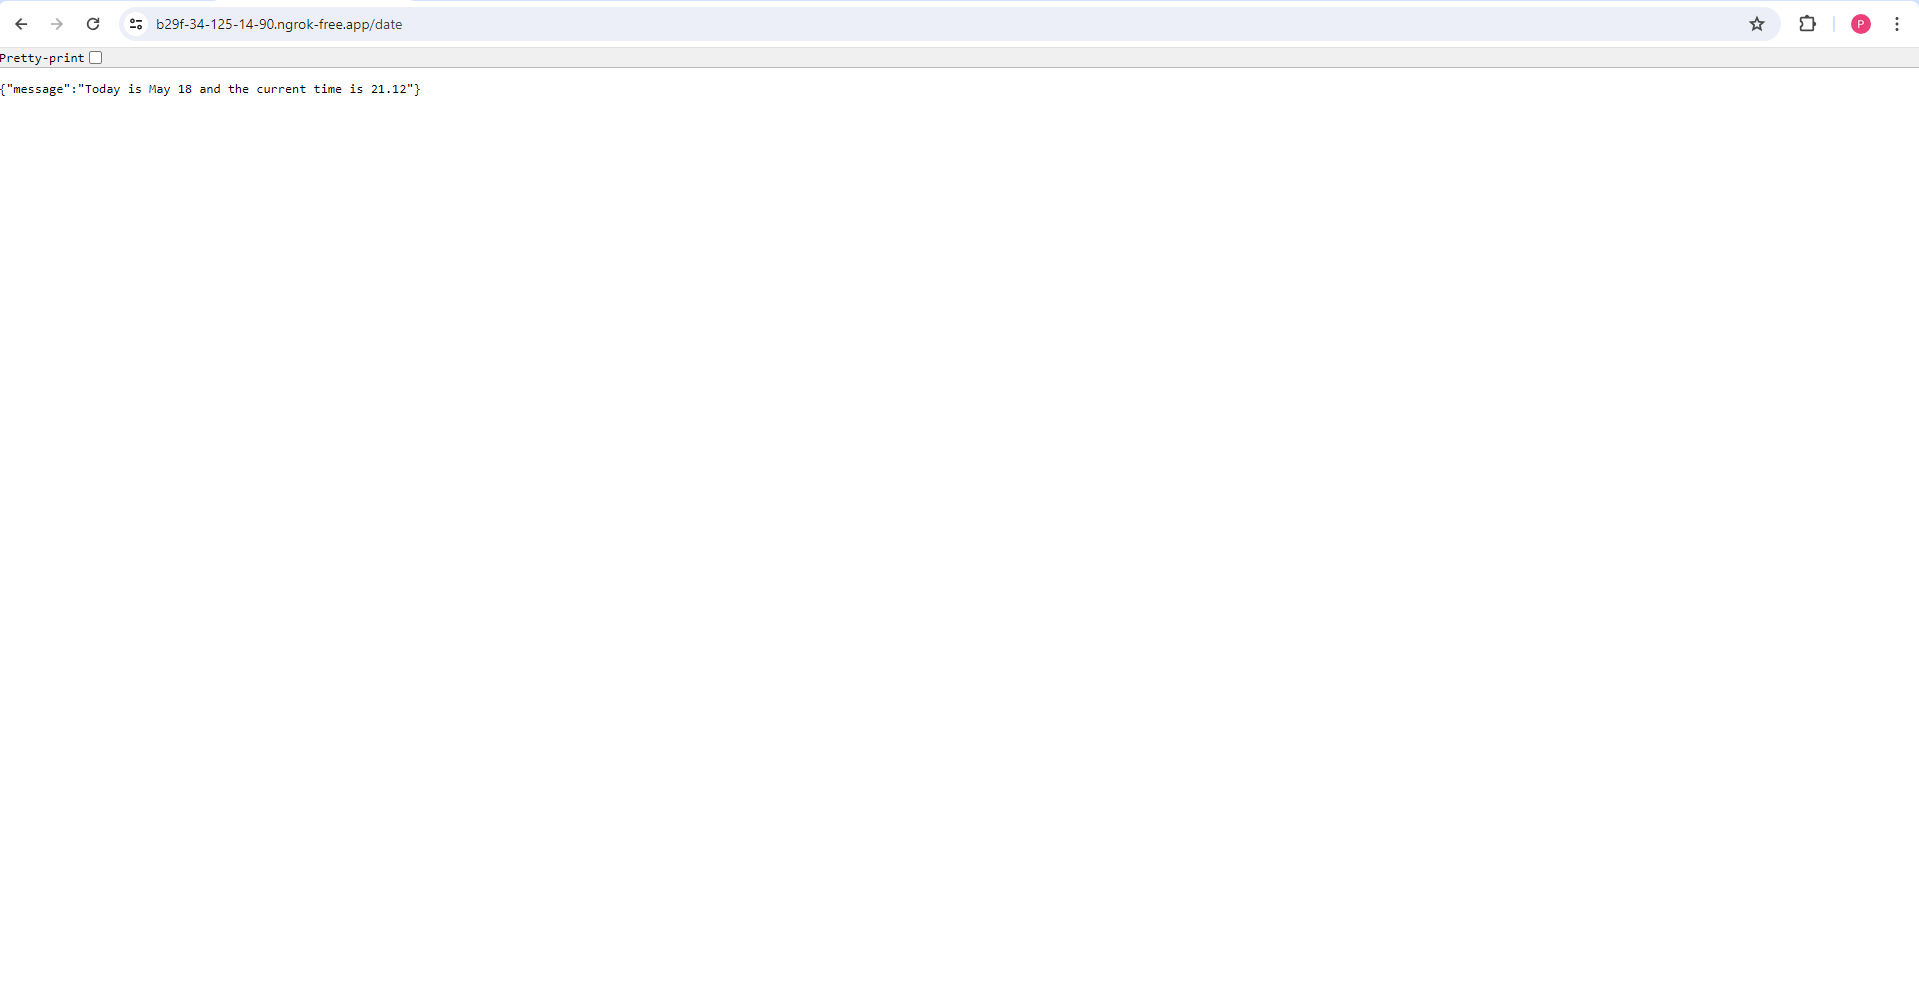

##Módulo: Pregunta-Respuesta

Para el módulo pregunta-respuesta, la pregunta y contexto que se han utilizado han sido:

* Pregunta: ¿Cuantas comunidades autónomas tiene España?
* Contexto: Tras los pactos autonómicos de 1981 y 1992, España se vertebra en 17 comunidades autónomas (una de ellas comunidad foral) y dos ciudades autónomas.


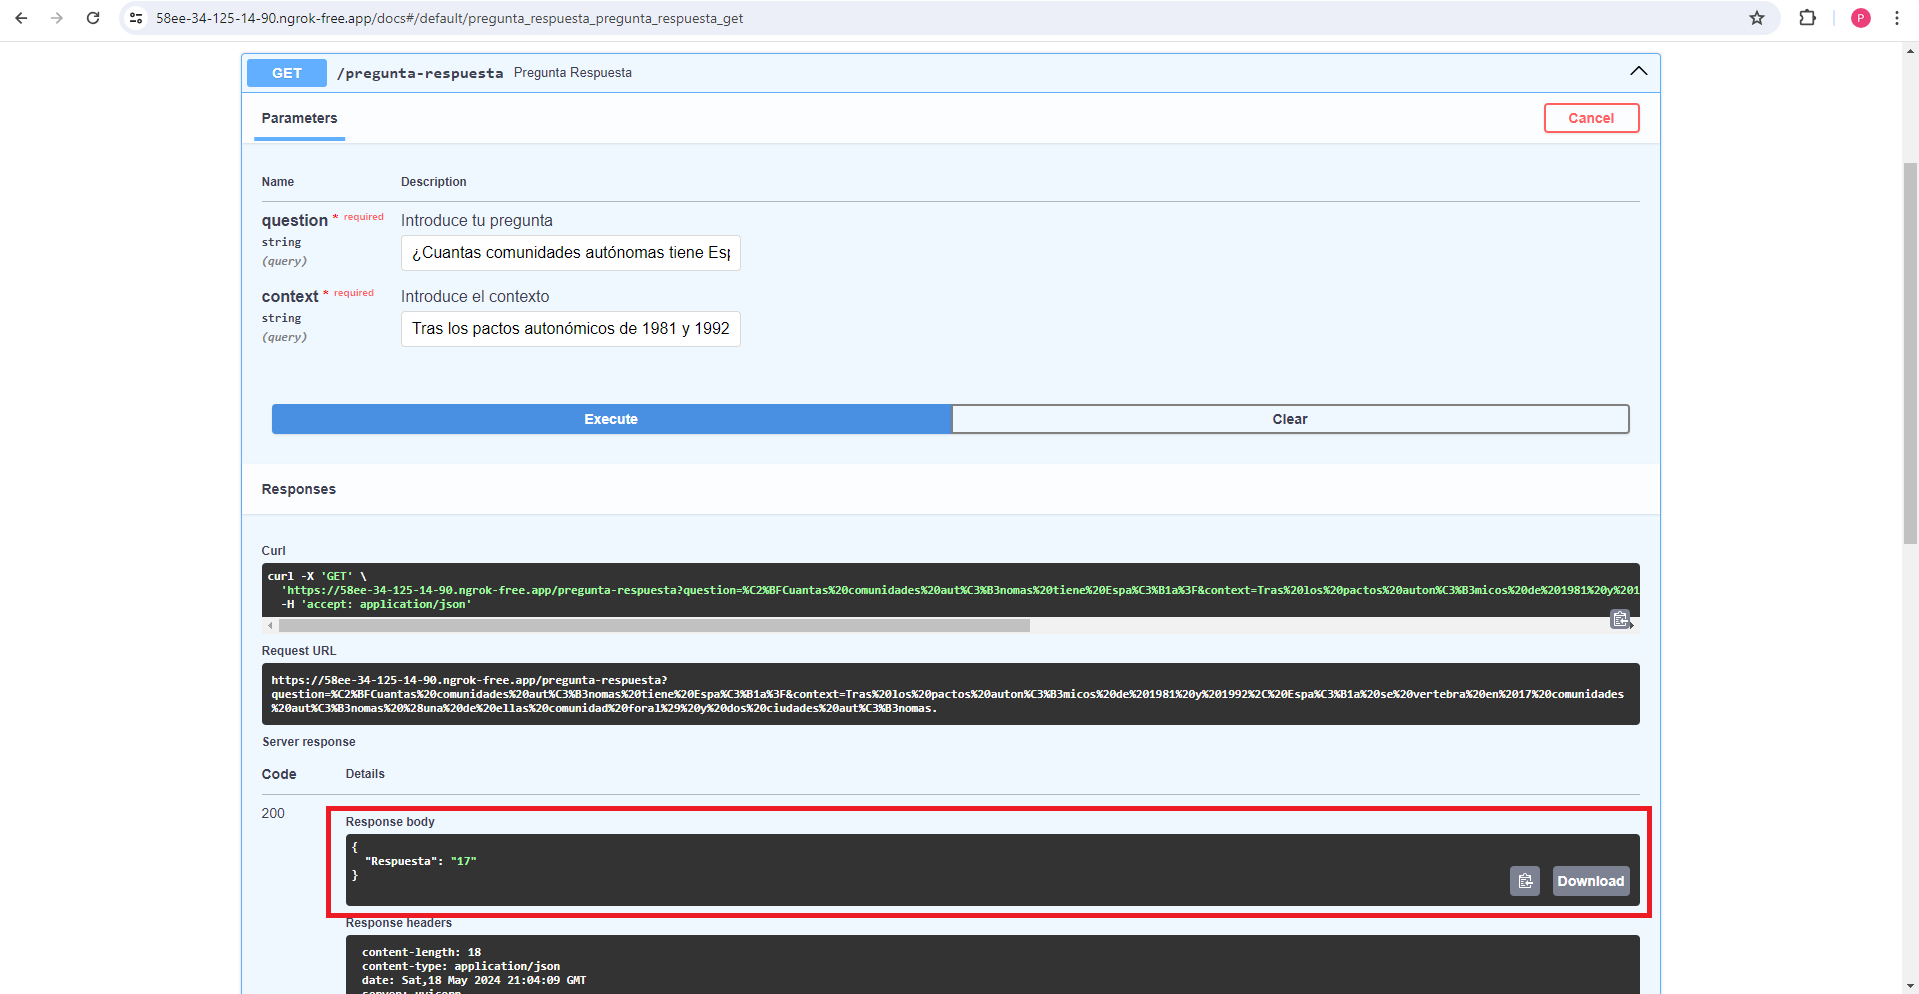

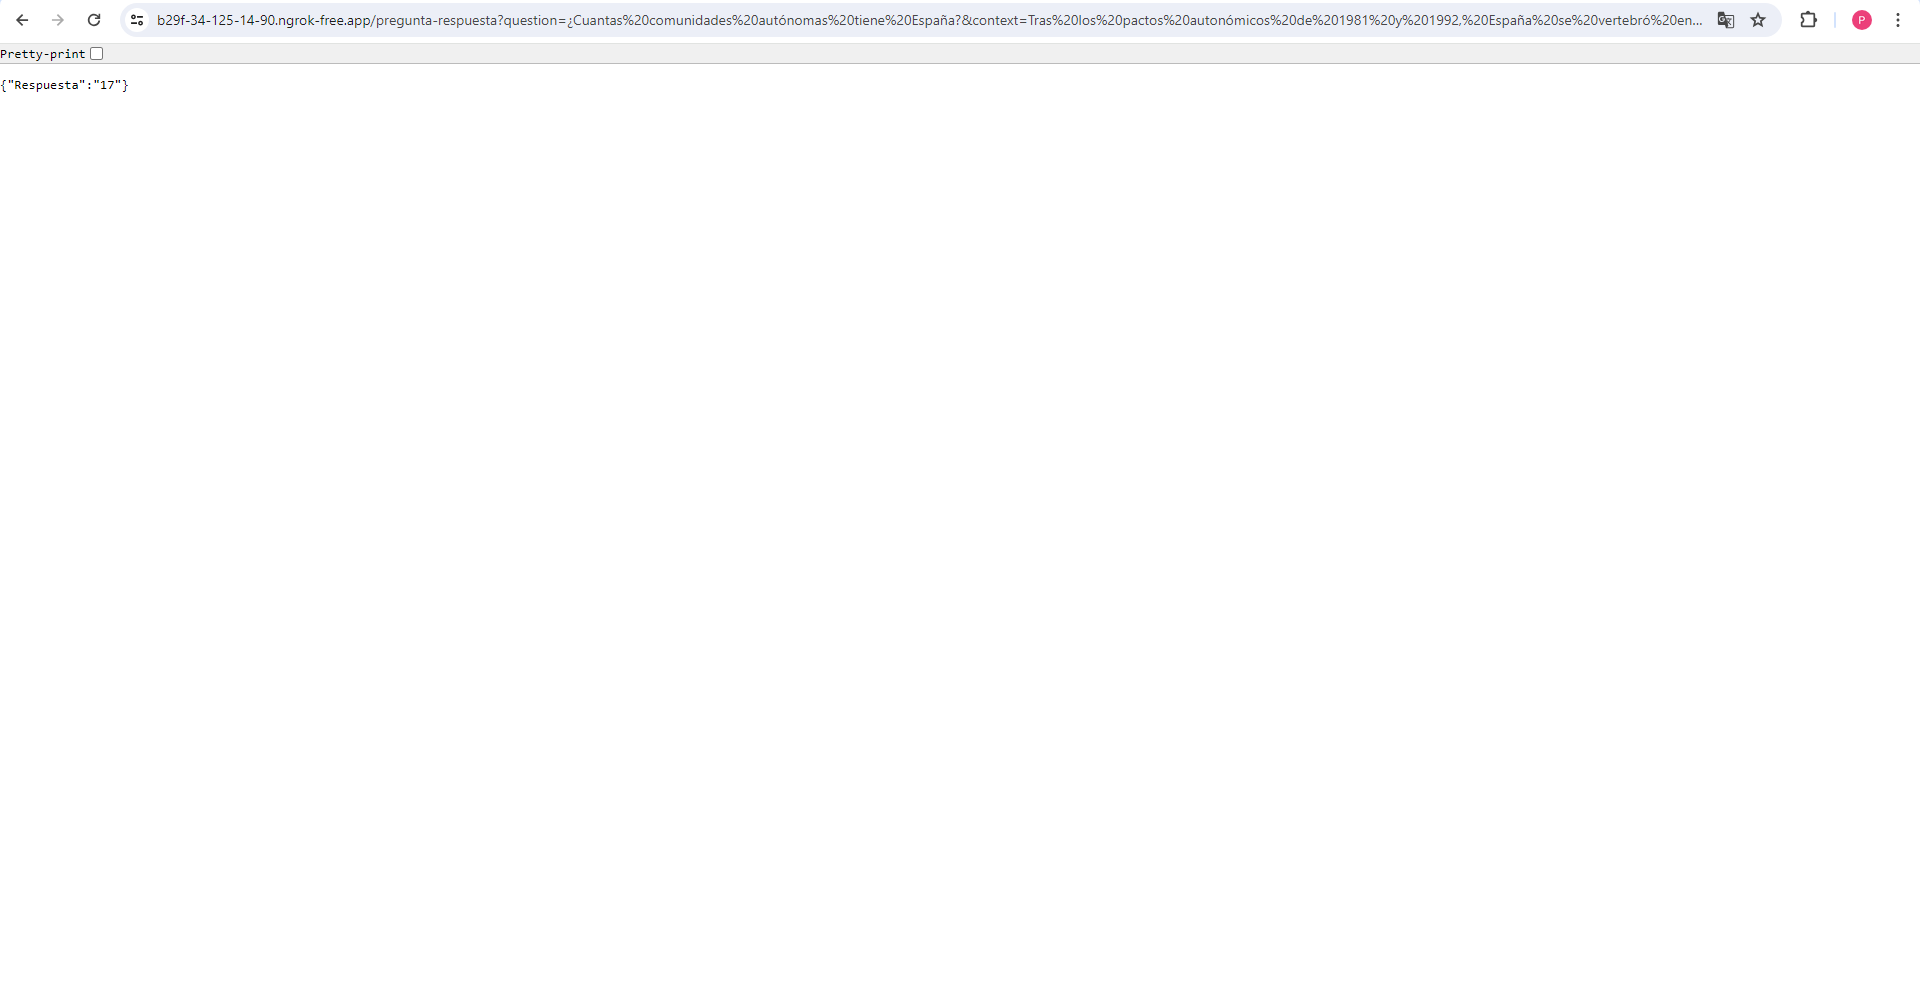

##Módulo: Summary

El texto elegido para probar el módulo de summary ha sidola descripción en wikipedia sobre el estado de Minnesota.

* Minnesota (/ˌmɪnəˈsoʊtə/ ⓘ MIN-ə-SOH-tə) is a state in the Upper Midwestern region of the United States. It is the 12th largest U.S. state in area and the 22nd most populous, with over 5.75 million residents. Minnesota is known as the "Land of 10,000 Lakes" but actually has 14,380 bodies of fresh water covering at least ten acres each;[7] roughly a third of the state is forested; much of the remainder is prairie and farmland. More than 60% of Minnesotans (about 3.7 million) live in the Minneapolis–Saint Paul metropolitan area, known as the "Twin Cities", the state's main political, economic, and cultural hub[8] and the 16th-largest metropolitan area in the U.S. Other minor metropolitan and micropolitan statistical areas include Duluth, Mankato, Moorhead, Rochester, and St. Cloud.[9]



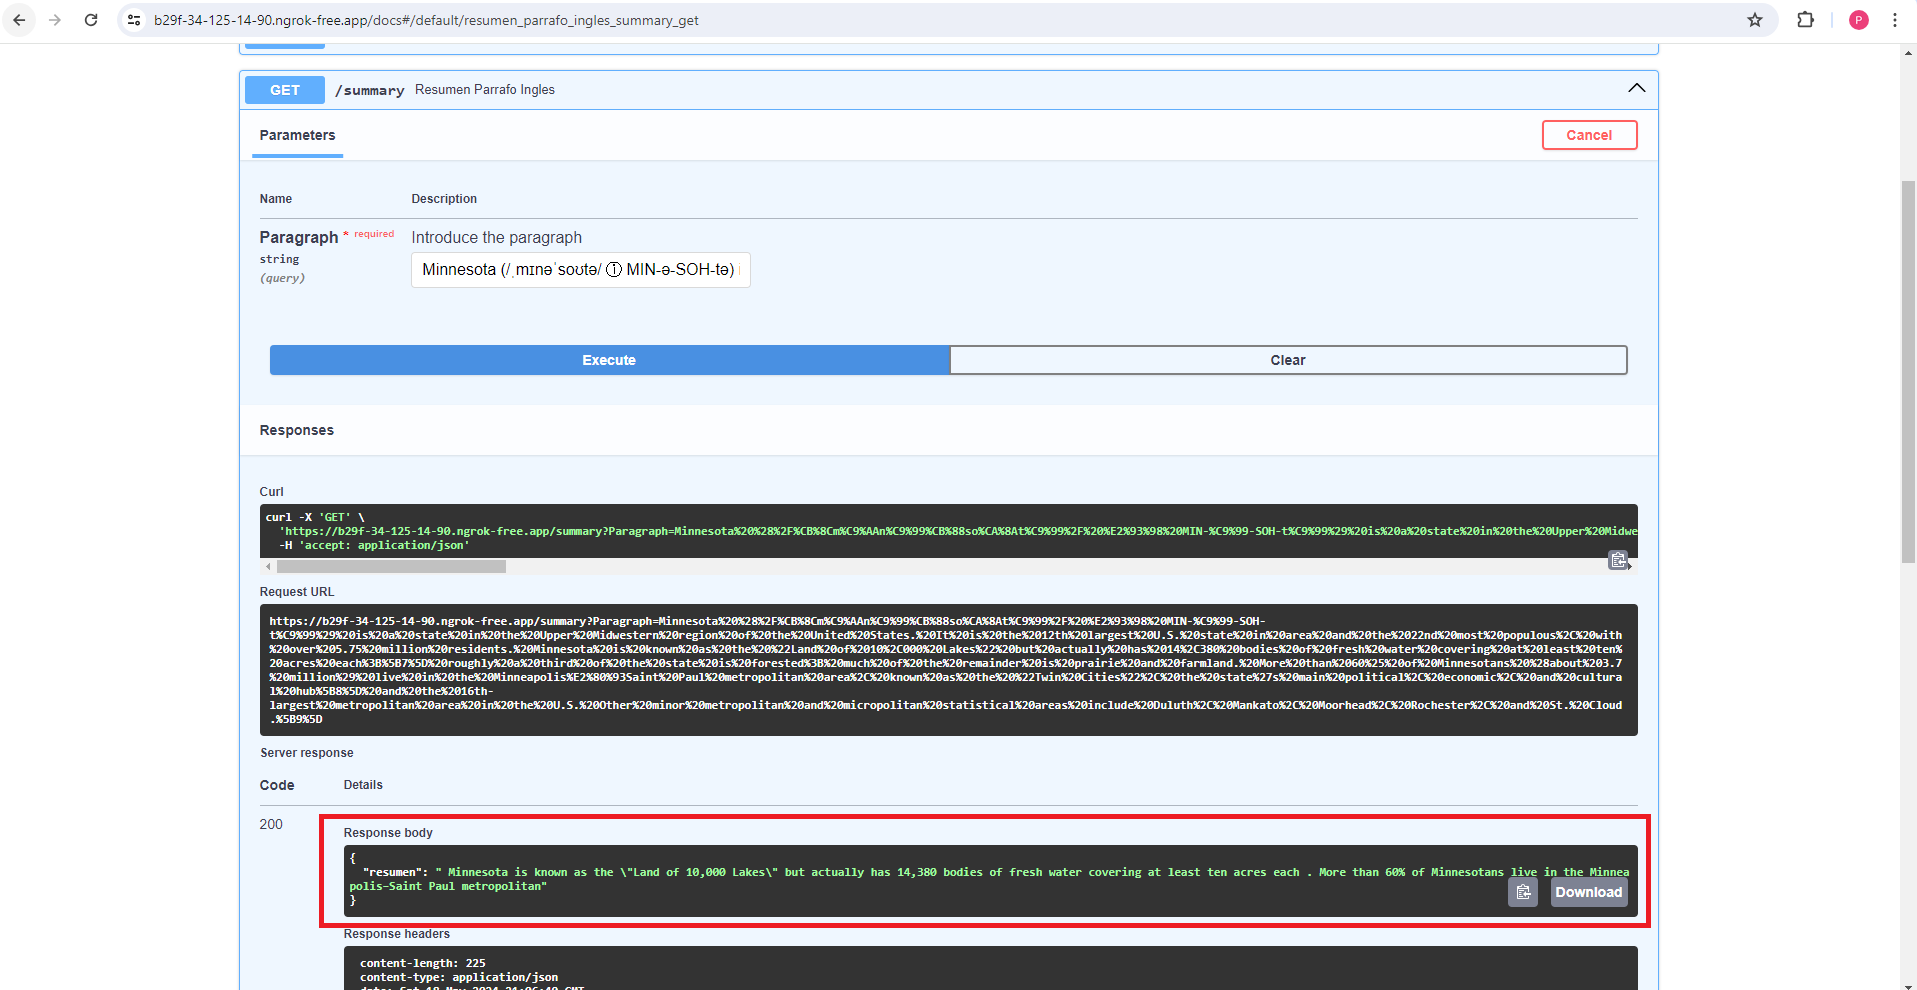

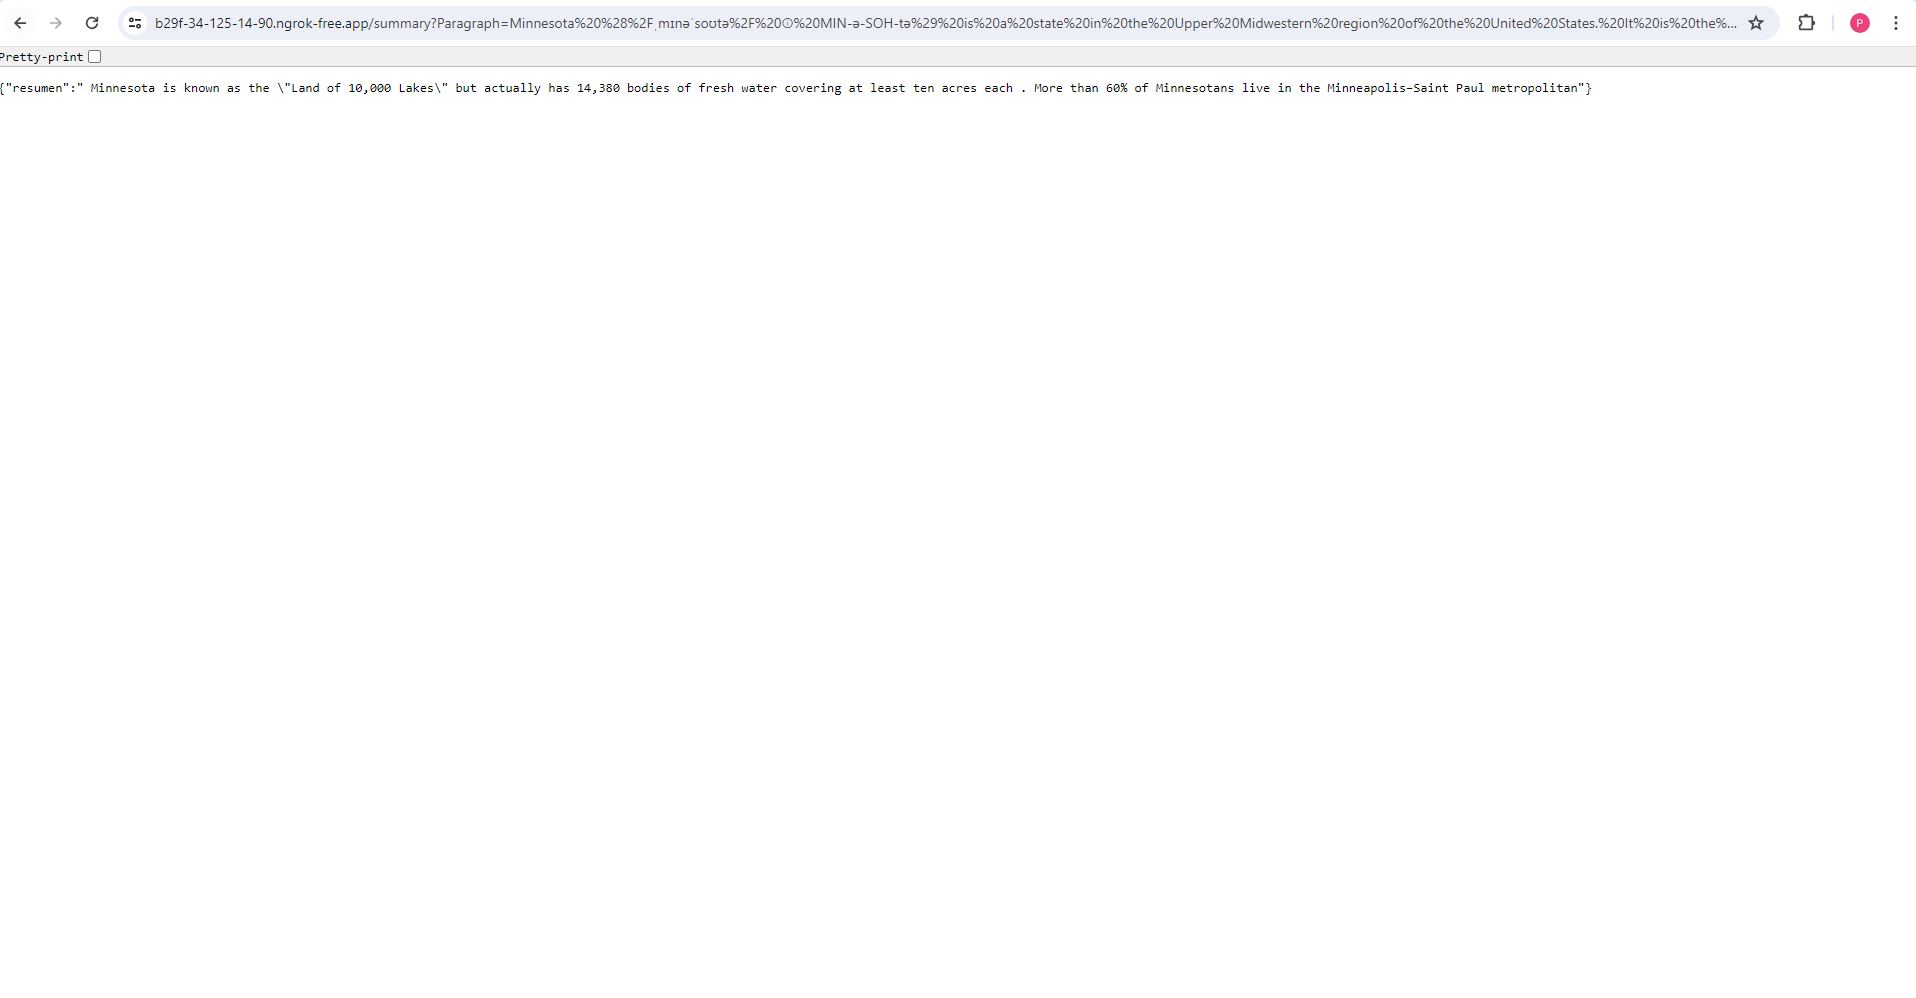

##Módulo: Traductor

Para probar el módulo traductor se ha probado el mismo párrafo que se ha utlizado para probar el resumen. Este es:

* Minnesota (/ˌmɪnəˈsoʊtə/ ⓘ MIN-ə-SOH-tə) is a state in the Upper Midwestern region of the United States. It is the 12th largest U.S. state in area and the 22nd most populous, with over 5.75 million residents. Minnesota is known as the "Land of 10,000 Lakes" but actually has 14,380 bodies of fresh water covering at least ten acres each;[7] roughly a third of the state is forested; much of the remainder is prairie and farmland. More than 60% of Minnesotans (about 3.7 million) live in the Minneapolis–Saint Paul metropolitan area, known as the "Twin Cities", the state's main political, economic, and cultural hub[8] and the 16th-largest metropolitan area in the U.S. Other minor metropolitan and micropolitan statistical areas include Duluth, Mankato, Moorhead, Rochester, and St. Cloud.[9]

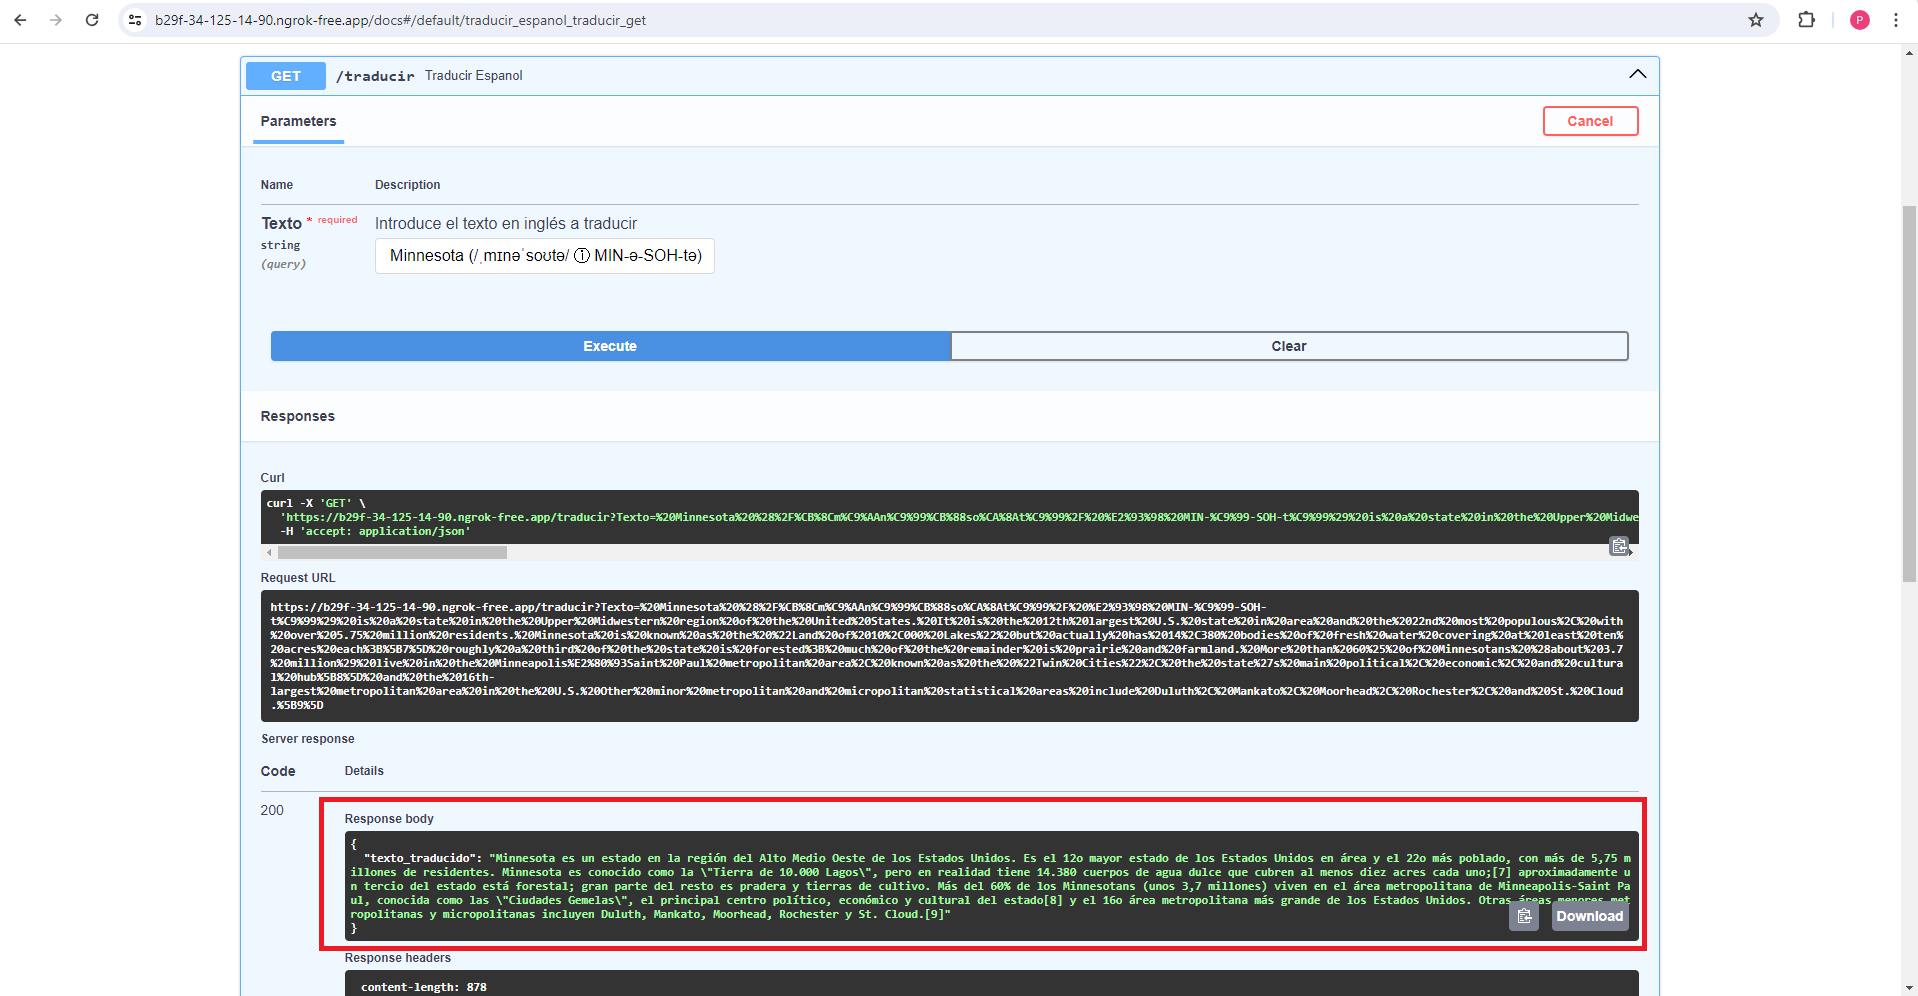

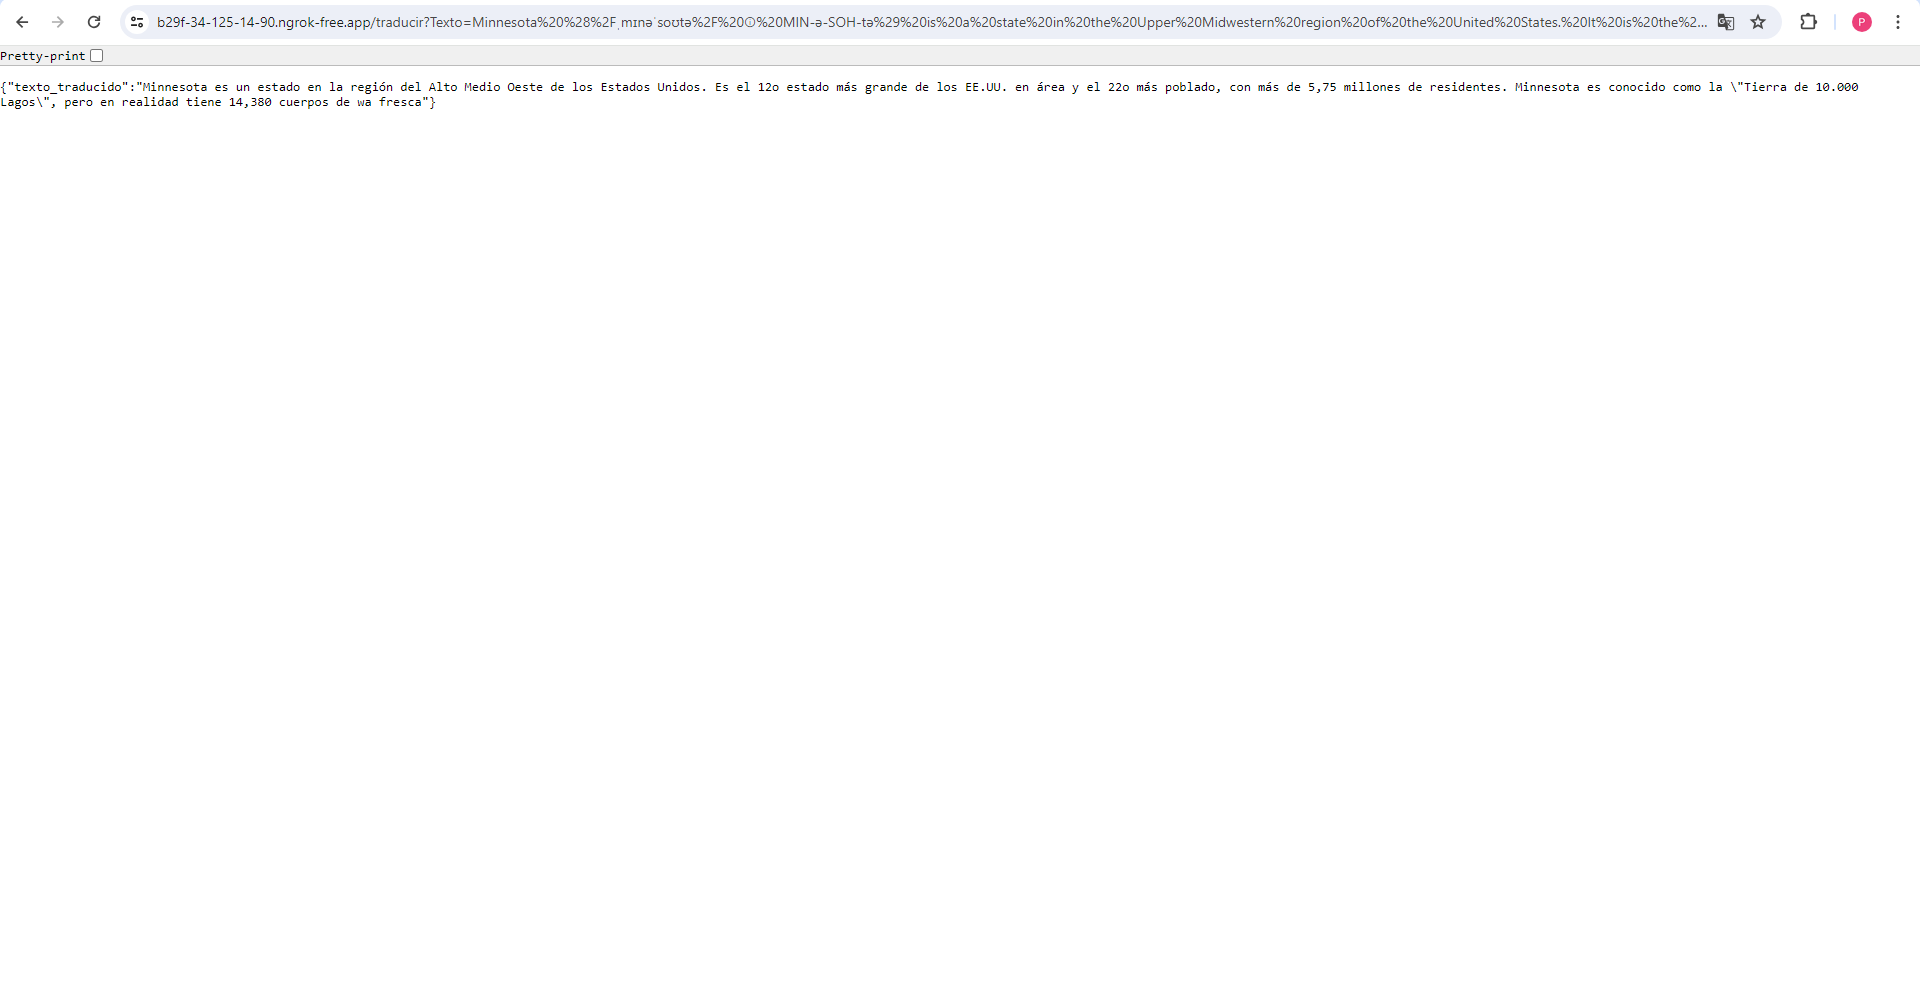

##Módulo: Análisis reseña

Por último, la reseña que se ha escogido ha sido una aleatoria de Amazon. Se adjunta la captura de pantalla con la reseña utilizada.

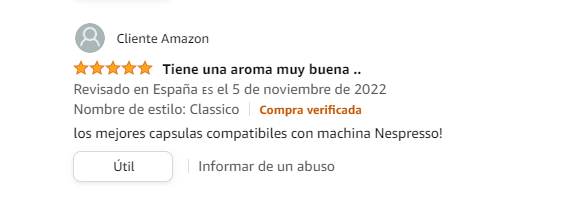

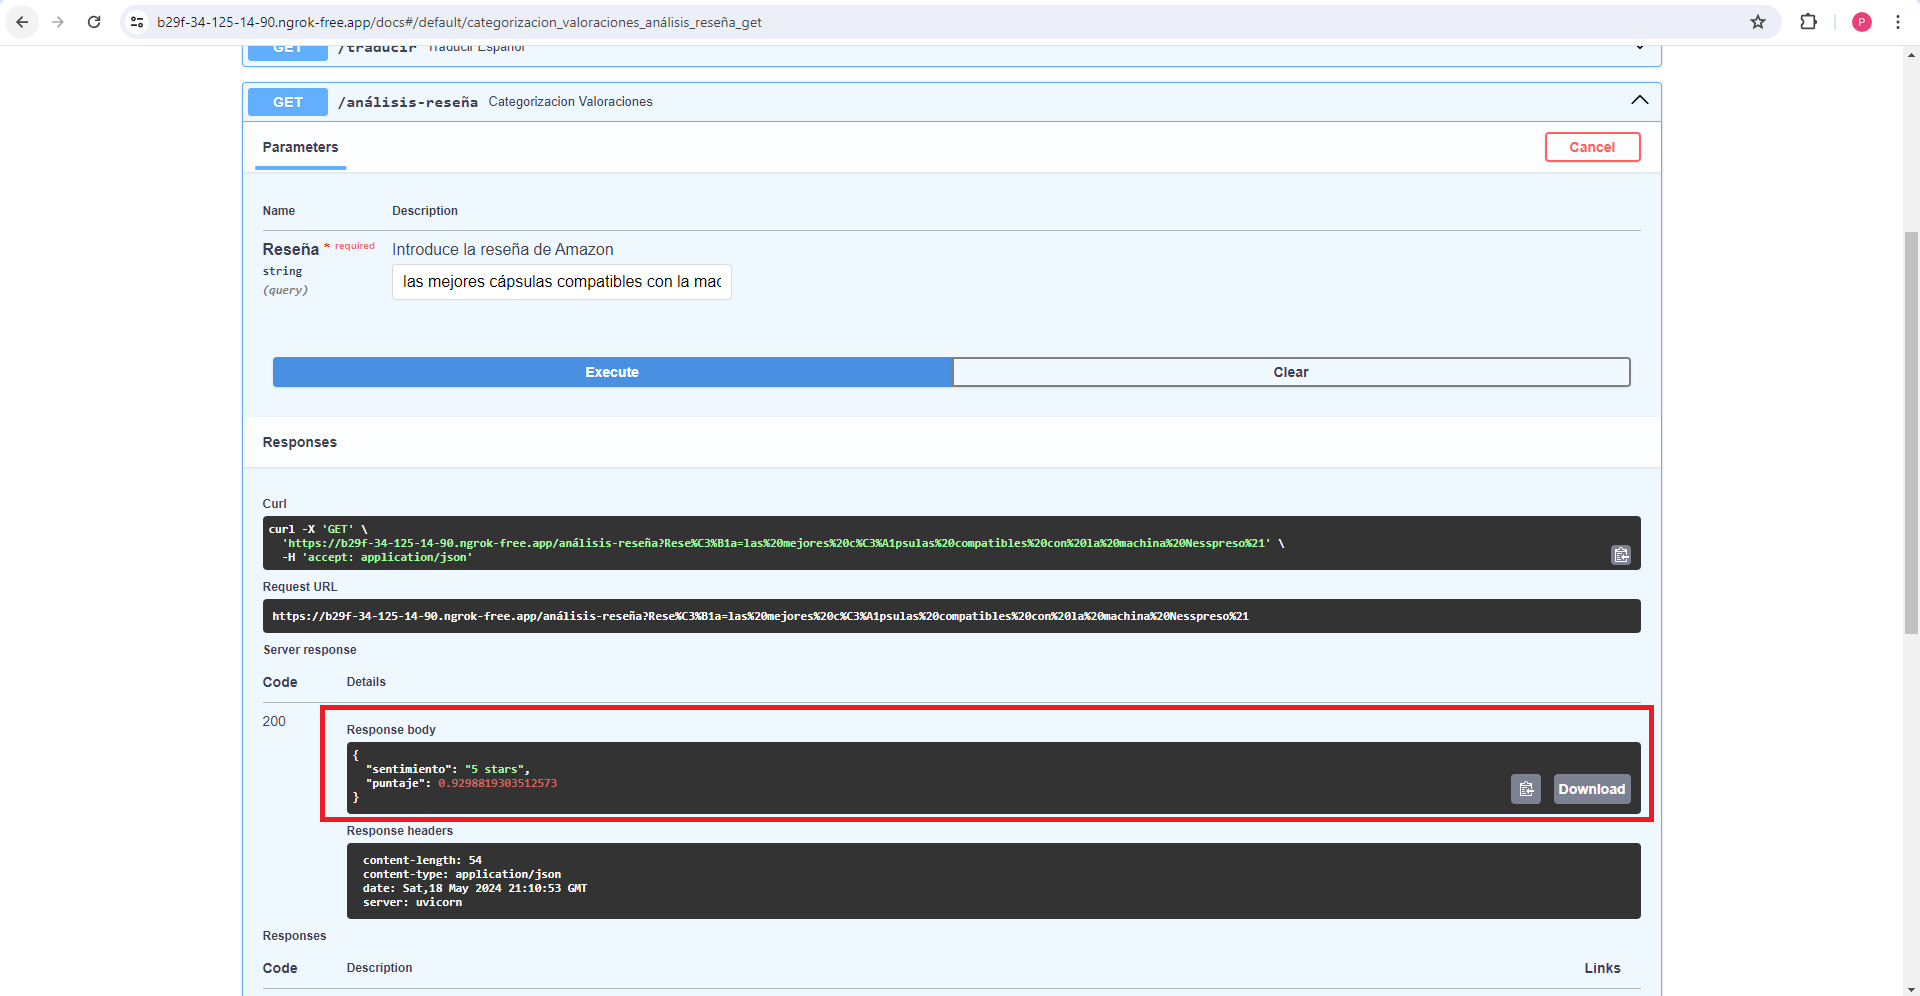

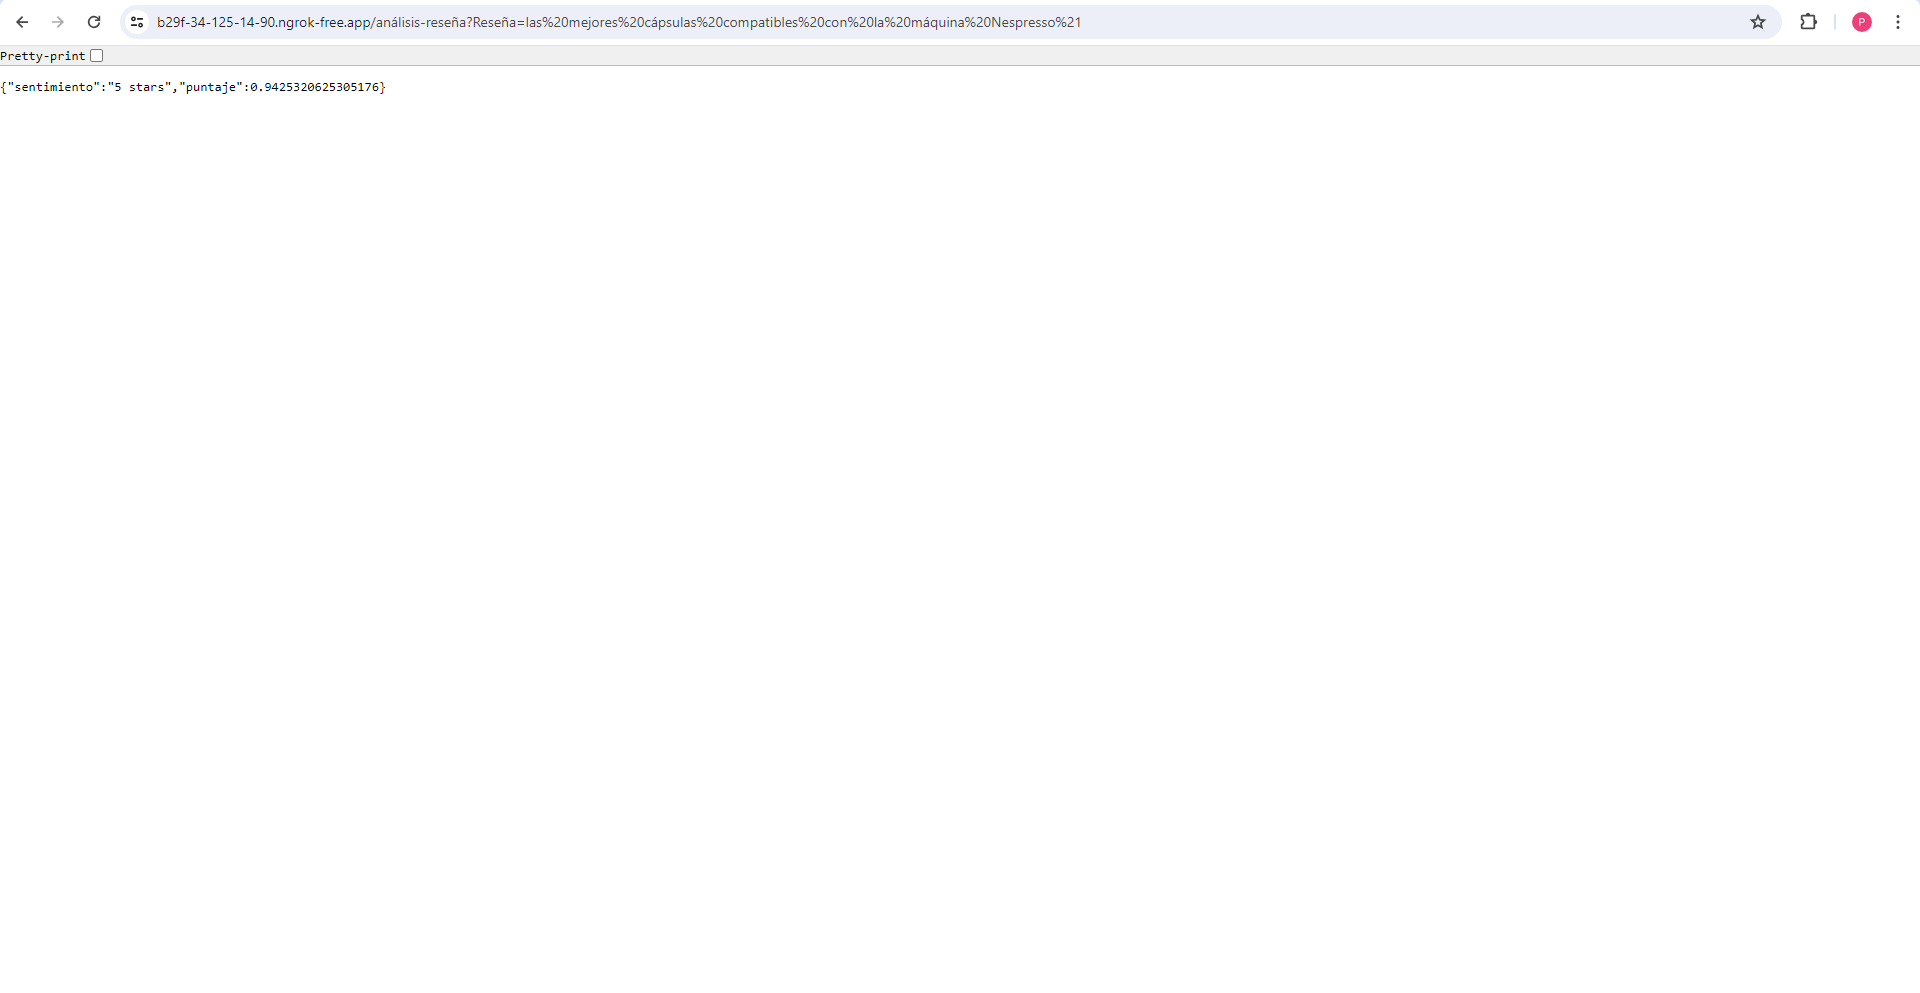

##Conclusiones

La utilización de la libraría FastAPI es sin duda alguna muy interesante ya que permite programar una interfaz de forma muy sencilla, el cual puede ser muy interesante de utilizar tanto a nivel profesional como personal. Como puede observarse, los pasos para programar la API son muy sencillos pero el hecho de que se pueda automatizar junto con un modelo de Hugging Face, hace que sus ventajas sean incalculables. En este ejercicio se han implementado cinco modelos sencillos, pero siguiendo con esta misma metodología se podría implementar algo mucho más complejo que ofrezca una mayor utilidad.

Además, como ocurría en el apartado 1, el hecho de implementar una API hace que sea mucho más accesible para todo el mundo el acceso a Python y a la inteligencia artificial. No es necesario que una persona sepa programar un modelo sino que simplemente haciendo las llamadas correspondientes a la API puede obtener la respuesta que necesite. Es por eso que esto es un gran avance porque simplifica considerablemente el uso de IA.

#Agradecimientos

Para finalizar esta práctica deseo agradecer a nuestro profesor Julen por todas las horas que ha invertido en preparar las clases, impartirlas, transmitir todos los conocimientos, resolver todas las dudas y estar pendiente de que entendamos los conceptos claves del despliegue de algoritmos en la red. Aunque este módulo haya sido corto creo que nos ha permitido conocer como es posible acercar la IA a gente que no posee conocimientos informáticos y como se puede hacer para que todo el mundo pueda utilizarla. Además, a mi personalmente que me gusta mucho la toma de decisiones en una empresa, creo que este módulo me ha sido muy útil porque me ha abierto la mente a posibles aplicaciones que se pueden implementar. Es por eso que quiero expresar mi absluto agradecimiento a nuestro profesor Julen.


Por último, agradezco también a la academia Keepcoding por haber introducido este módulo en el bootcamp, el cual creo que va a ser muy beneficioso para mi futuro.